## Probability maps animation

This notebook creates an animation showing the evolution of the predicted time-dependent deposit probability from 170Ma-present. The notebook `02-create_probability_maps.ipynb` must have been run previously.

In [1]:
use_extracted_data = False


In [2]:
import glob
import os
import tempfile

import cartopy.crs as ccrs
import pandas as pd
import pygplates
from gplately import (
    PlateReconstruction,
    PlotTopologies,
)
from joblib import Parallel, delayed
from moviepy.video.io.ImageSequenceClip import ImageSequenceClip

from lib.check_files import (
    check_plate_model,
    check_prepared_data,
)
from lib.visualisation import plot

# Suppress occasional joblib warnings
%env PYTHONWARNINGS=ignore::UserWarning

NOTEBOOK = "get_ipython" in dir()


env: PYTHONWARNINGS=ignore::UserWarning


In [3]:
n_jobs = int(os.environ.get("N_JOBS", 8))
verbose = True
lon_0 = 0.0
projection = ccrs.Mollweide(lon_0)

output_dir = os.path.join("outputs", "global")

imshow_kwargs = dict(
    vmin=0,
    vmax=60,
    cmap="viridis"
)

### Load plate model files

In [4]:
model_dir = "plate_model"
check_plate_model(model_dir, verbose=True)
feature_filenames = glob.glob(
    os.path.join(
        model_dir,
        r"*.gpml",
    )
)
rotation_filenames = glob.glob(
    os.path.join(
        model_dir,
        r"*.rot",
    )
)
coastlines_filename = os.path.join(
    model_dir,
    "StaticGeometries",
    "AgeGridInput",
    "CombinedTerranes.gpml",
)

reconstruction = PlateReconstruction(
    rotation_model=rotation_filenames,
    topology_features=pygplates.FeatureCollection(
        [
            i for i in pygplates.FeaturesFunctionArgument(
                feature_filenames
            ).get_features()
            if i.get_feature_type().to_qualified_string()
            != "gpml:TopologicalSlabBoundary"
        ]
        
    ),
)
gplot = PlotTopologies(
    plate_reconstruction=reconstruction,
    coastlines=coastlines_filename,
)


### Load training data

In [5]:
if use_extracted_data:
    data_dir = "extracted_data"
else:
    data_dir = "prepared_data"
    check_prepared_data(data_dir, verbose=True)
training_filename = os.path.join(data_dir, "training_data_global.csv")
training_data = pd.read_csv(training_filename)
positives = training_data[training_data["label"] == "positive"]


### Example plot

PU example plot:


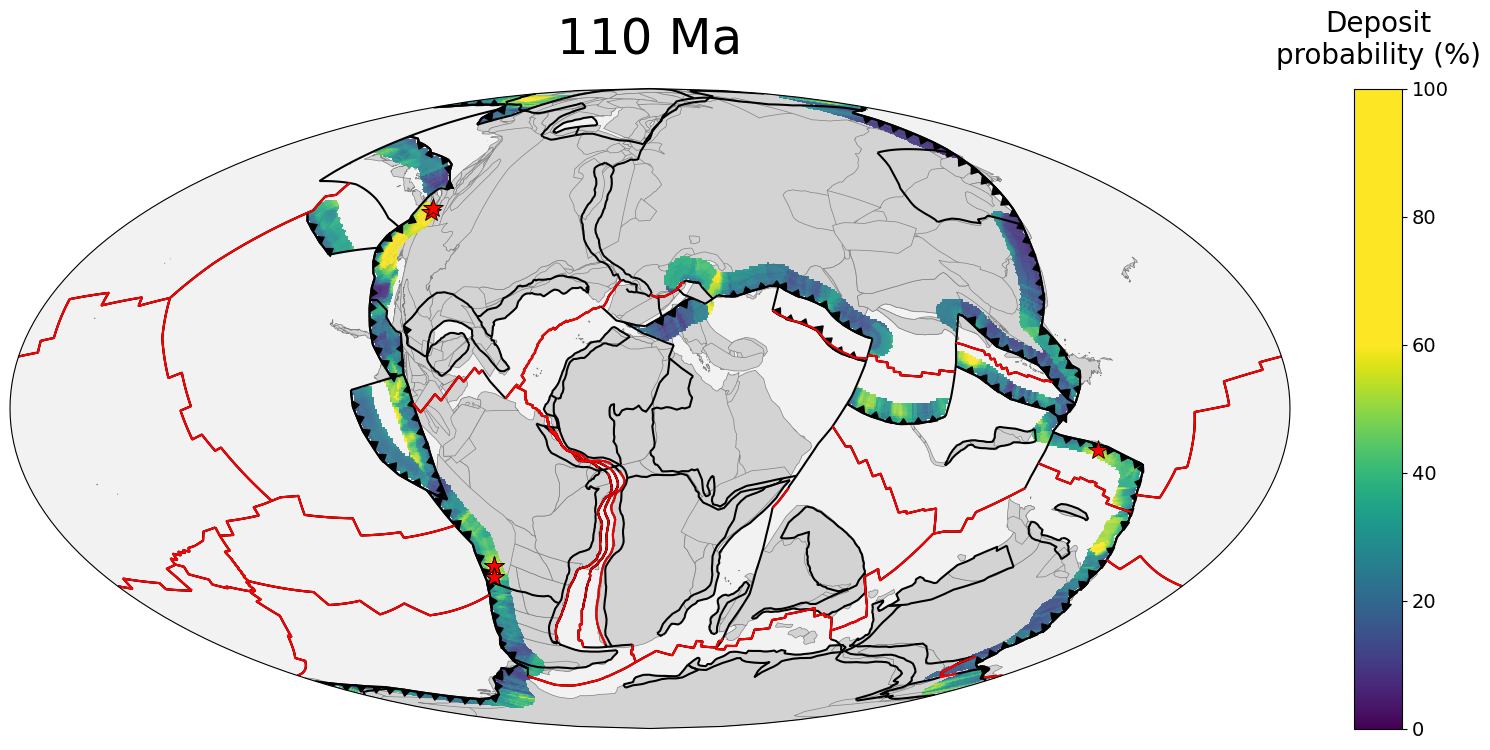

In [6]:
# Example plot (only in notebook)
if NOTEBOOK:
    t_example = 110  # Ma
    gplot.time = t_example
    algorithm = "PU"
    probs_dir = os.path.join(output_dir, algorithm, "probability_grids")

    print(f"{algorithm} example plot:")
    fig = plot(
        gplot=gplot,
        probabilities=os.path.join(
            probs_dir,
            f"probability_grid_{t_example:0.0f}Ma.nc",
        ),
        positives=positives,
        projection=projection,
        time=t_example,
        central_meridian=lon_0,
        imshow_kwargs=imshow_kwargs,
    )


### Create all plots

In [7]:
times = range(171)
gplot_kw = dict(
    rotation_model=rotation_filenames,
    topology_features=feature_filenames,
    coastlines=coastlines_filename,
)

for algorithm in ("PU", "SVM"):
    output_filename = os.path.join(
        output_dir,
        algorithm,
        "probability_animation.mp4",
    )
    probs_dir = os.path.join(output_dir, algorithm, "probability_grids")

    # Create all plots
    with tempfile.TemporaryDirectory() as tmpdir, \
            Parallel(n_jobs=n_jobs, verbose=int(verbose)) as parallel:
        output_filenames = [
            os.path.join(tmpdir, f"image_{t:0.0f}Ma.png")
            for t in times
        ]
        parallel(
            delayed(plot)(
                gplot=gplot_kw,
                probabilities=os.path.join(
                    probs_dir,
                    f"probability_grid_{t:0.0f}Ma.nc",
                ),
                projection=projection,
                time=t,
                positives=positives[
                    (positives["age (Ma)"] - float(t)).abs()
                    <= 2.5
                ],
                output_filename=o,
                central_meridian=lon_0,
                imshow_kwargs=imshow_kwargs,
            )
            for t, o in zip(times, output_filenames)
        )

        with ImageSequenceClip(output_filenames[::-1], fps=5) as clip:
            clip.write_videofile(
                output_filename,
                fps=30,
                codec="mpeg4",
                bitrate="5000k",
                audio=False,
                threads=n_jobs,
                logger="bar" if verbose else None,
                ffmpeg_params=[
                    "-vf",
                    "pad=ceil(iw/2)*2:ceil(ih/2)*2",
                ],
            )


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:  1.3min


[Parallel(n_jobs=8)]: Done 171 out of 171 | elapsed:  5.4min finished


Moviepy - Building video outputs/global/PU/probability_animation.mp4.
Moviepy - Writing video outputs/global/PU/probability_animation.mp4



t:   0%|                             | 0/1026 [00:00<?, ?it/s, now=None]

t:   0%|                     | 2/1026 [00:00<01:05, 15.62it/s, now=None]

t:   0%|                     | 4/1026 [00:00<01:52,  9.12it/s, now=None]

t:   1%|                     | 6/1026 [00:00<02:06,  8.05it/s, now=None]

t:   1%|▏                    | 7/1026 [00:00<02:08,  7.96it/s, now=None]

t:   1%|▏                    | 8/1026 [00:01<02:42,  6.25it/s, now=None]

t:   1%|▏                    | 9/1026 [00:01<02:36,  6.48it/s, now=None]

t:   1%|▏                   | 10/1026 [00:01<02:28,  6.85it/s, now=None]

t:   1%|▏                   | 11/1026 [00:01<02:18,  7.30it/s, now=None]

t:   1%|▏                   | 12/1026 [00:01<02:12,  7.67it/s, now=None]

t:   1%|▎                   | 13/1026 [00:01<02:06,  7.98it/s, now=None]

t:   1%|▎                   | 14/1026 [00:01<02:40,  6.32it/s, now=None]

t:   1%|▎                   | 15/1026 [00:02<02:27,  6.87it/s, now=None]

t:   2%|▎                   | 16/1026 [00:02<02:17,  7.34it/s, now=None]

t:   2%|▎                   | 17/1026 [00:02<02:11,  7.70it/s, now=None]

t:   2%|▎                   | 18/1026 [00:02<02:06,  7.97it/s, now=None]

t:   2%|▎                   | 19/1026 [00:02<02:03,  8.19it/s, now=None]

t:   2%|▍                   | 20/1026 [00:02<02:37,  6.41it/s, now=None]

t:   2%|▍                   | 21/1026 [00:02<02:24,  6.98it/s, now=None]

t:   2%|▍                   | 22/1026 [00:02<02:15,  7.43it/s, now=None]

t:   2%|▍                   | 23/1026 [00:03<02:09,  7.76it/s, now=None]

t:   2%|▍                   | 24/1026 [00:03<02:05,  8.01it/s, now=None]

t:   2%|▍                   | 25/1026 [00:03<02:01,  8.21it/s, now=None]

t:   3%|▌                   | 26/1026 [00:03<02:36,  6.40it/s, now=None]

t:   3%|▌                   | 27/1026 [00:03<02:26,  6.83it/s, now=None]

t:   3%|▌                   | 28/1026 [00:03<02:16,  7.31it/s, now=None]

t:   3%|▌                   | 29/1026 [00:03<02:09,  7.70it/s, now=None]

t:   3%|▌                   | 30/1026 [00:04<02:05,  7.93it/s, now=None]

t:   3%|▌                   | 31/1026 [00:04<02:04,  7.98it/s, now=None]

t:   3%|▌                   | 32/1026 [00:04<02:38,  6.29it/s, now=None]

t:   3%|▋                   | 33/1026 [00:04<02:24,  6.87it/s, now=None]

t:   3%|▋                   | 34/1026 [00:04<02:14,  7.35it/s, now=None]

t:   3%|▋                   | 35/1026 [00:04<02:10,  7.61it/s, now=None]

t:   4%|▋                   | 36/1026 [00:04<02:07,  7.74it/s, now=None]

t:   4%|▋                   | 37/1026 [00:04<02:06,  7.79it/s, now=None]

t:   4%|▋                   | 38/1026 [00:05<02:40,  6.17it/s, now=None]

t:   4%|▊                   | 39/1026 [00:05<02:28,  6.65it/s, now=None]

t:   4%|▊                   | 40/1026 [00:05<02:20,  7.02it/s, now=None]

t:   4%|▊                   | 41/1026 [00:05<02:14,  7.32it/s, now=None]

t:   4%|▊                   | 42/1026 [00:05<02:07,  7.70it/s, now=None]

t:   4%|▊                   | 43/1026 [00:05<02:05,  7.83it/s, now=None]

t:   4%|▊                   | 44/1026 [00:06<02:37,  6.22it/s, now=None]

t:   4%|▉                   | 45/1026 [00:06<02:26,  6.70it/s, now=None]

t:   4%|▉                   | 46/1026 [00:06<02:16,  7.18it/s, now=None]

t:   5%|▉                   | 47/1026 [00:06<02:11,  7.45it/s, now=None]

t:   5%|▉                   | 48/1026 [00:06<02:08,  7.61it/s, now=None]

t:   5%|▉                   | 49/1026 [00:06<02:06,  7.72it/s, now=None]

t:   5%|▉                   | 50/1026 [00:06<02:34,  6.30it/s, now=None]

t:   5%|▉                   | 51/1026 [00:07<02:24,  6.75it/s, now=None]

t:   5%|█                   | 52/1026 [00:07<02:17,  7.07it/s, now=None]

t:   5%|█                   | 53/1026 [00:07<02:12,  7.35it/s, now=None]

t:   5%|█                   | 54/1026 [00:07<02:08,  7.55it/s, now=None]

t:   5%|█                   | 55/1026 [00:07<02:05,  7.72it/s, now=None]

t:   5%|█                   | 56/1026 [00:07<02:36,  6.18it/s, now=None]

t:   6%|█                   | 57/1026 [00:07<02:25,  6.65it/s, now=None]

t:   6%|█▏                  | 58/1026 [00:07<02:17,  7.03it/s, now=None]

t:   6%|█▏                  | 59/1026 [00:08<02:12,  7.30it/s, now=None]

t:   6%|█▏                  | 60/1026 [00:08<02:09,  7.48it/s, now=None]

t:   6%|█▏                  | 61/1026 [00:08<02:06,  7.65it/s, now=None]

t:   6%|█▏                  | 62/1026 [00:08<02:37,  6.10it/s, now=None]

t:   6%|█▏                  | 63/1026 [00:08<02:23,  6.72it/s, now=None]

t:   6%|█▏                  | 64/1026 [00:08<02:13,  7.21it/s, now=None]

t:   6%|█▎                  | 65/1026 [00:08<02:09,  7.43it/s, now=None]

t:   6%|█▎                  | 66/1026 [00:09<02:03,  7.77it/s, now=None]

t:   7%|█▎                  | 67/1026 [00:09<02:02,  7.82it/s, now=None]

t:   7%|█▎                  | 68/1026 [00:09<02:34,  6.18it/s, now=None]

t:   7%|█▎                  | 69/1026 [00:09<02:24,  6.65it/s, now=None]

t:   7%|█▎                  | 70/1026 [00:09<02:16,  7.02it/s, now=None]

t:   7%|█▍                  | 71/1026 [00:09<02:11,  7.29it/s, now=None]

t:   7%|█▍                  | 72/1026 [00:09<02:04,  7.65it/s, now=None]

t:   7%|█▍                  | 73/1026 [00:10<01:59,  7.94it/s, now=None]

t:   7%|█▍                  | 74/1026 [00:10<02:30,  6.35it/s, now=None]

t:   7%|█▍                  | 75/1026 [00:10<02:21,  6.74it/s, now=None]

t:   7%|█▍                  | 76/1026 [00:10<02:11,  7.23it/s, now=None]

t:   8%|█▌                  | 77/1026 [00:10<02:08,  7.39it/s, now=None]

t:   8%|█▌                  | 78/1026 [00:10<02:06,  7.48it/s, now=None]

t:   8%|█▌                  | 79/1026 [00:10<02:01,  7.77it/s, now=None]

t:   8%|█▌                  | 80/1026 [00:11<02:34,  6.14it/s, now=None]

t:   8%|█▌                  | 81/1026 [00:11<02:20,  6.72it/s, now=None]

t:   8%|█▌                  | 82/1026 [00:11<02:13,  7.05it/s, now=None]

t:   8%|█▌                  | 83/1026 [00:11<02:06,  7.47it/s, now=None]

t:   8%|█▋                  | 84/1026 [00:11<02:04,  7.58it/s, now=None]

t:   8%|█▋                  | 85/1026 [00:11<02:02,  7.69it/s, now=None]

t:   8%|█▋                  | 86/1026 [00:11<02:33,  6.13it/s, now=None]

t:   8%|█▋                  | 87/1026 [00:12<02:23,  6.57it/s, now=None]

t:   9%|█▋                  | 88/1026 [00:12<02:15,  6.91it/s, now=None]

t:   9%|█▋                  | 89/1026 [00:12<02:10,  7.19it/s, now=None]

t:   9%|█▊                  | 90/1026 [00:12<02:06,  7.38it/s, now=None]

t:   9%|█▊                  | 91/1026 [00:12<02:04,  7.51it/s, now=None]

t:   9%|█▊                  | 92/1026 [00:12<02:33,  6.09it/s, now=None]

t:   9%|█▊                  | 93/1026 [00:12<02:21,  6.58it/s, now=None]

t:   9%|█▊                  | 94/1026 [00:13<02:13,  6.96it/s, now=None]

t:   9%|█▊                  | 95/1026 [00:13<02:05,  7.43it/s, now=None]

t:   9%|█▊                  | 96/1026 [00:13<02:02,  7.60it/s, now=None]

t:   9%|█▉                  | 97/1026 [00:13<01:59,  7.77it/s, now=None]

t:  10%|█▉                  | 98/1026 [00:13<02:30,  6.15it/s, now=None]

t:  10%|█▉                  | 99/1026 [00:13<02:21,  6.57it/s, now=None]

t:  10%|█▊                 | 100/1026 [00:13<02:13,  6.95it/s, now=None]

t:  10%|█▊                 | 101/1026 [00:14<02:07,  7.23it/s, now=None]

t:  10%|█▉                 | 102/1026 [00:14<02:04,  7.43it/s, now=None]

t:  10%|█▉                 | 103/1026 [00:14<02:02,  7.52it/s, now=None]

t:  10%|█▉                 | 104/1026 [00:14<02:32,  6.05it/s, now=None]

t:  10%|█▉                 | 105/1026 [00:14<02:21,  6.50it/s, now=None]

t:  10%|█▉                 | 106/1026 [00:14<02:10,  7.04it/s, now=None]

t:  10%|█▉                 | 107/1026 [00:14<02:02,  7.48it/s, now=None]

t:  11%|██                 | 108/1026 [00:15<01:57,  7.79it/s, now=None]

t:  11%|██                 | 109/1026 [00:15<01:56,  7.85it/s, now=None]

t:  11%|██                 | 110/1026 [00:15<02:27,  6.20it/s, now=None]

t:  11%|██                 | 111/1026 [00:15<02:18,  6.62it/s, now=None]

t:  11%|██                 | 112/1026 [00:15<02:11,  6.98it/s, now=None]

t:  11%|██                 | 113/1026 [00:15<02:05,  7.25it/s, now=None]

t:  11%|██                 | 114/1026 [00:15<01:59,  7.63it/s, now=None]

t:  11%|██▏                | 115/1026 [00:16<01:54,  7.93it/s, now=None]

t:  11%|██▏                | 116/1026 [00:16<02:25,  6.24it/s, now=None]

t:  11%|██▏                | 117/1026 [00:16<02:16,  6.67it/s, now=None]

t:  12%|██▏                | 118/1026 [00:16<02:09,  7.01it/s, now=None]

t:  12%|██▏                | 119/1026 [00:16<02:04,  7.29it/s, now=None]

t:  12%|██▏                | 120/1026 [00:16<01:58,  7.62it/s, now=None]

t:  12%|██▏                | 121/1026 [00:16<01:57,  7.68it/s, now=None]

t:  12%|██▎                | 122/1026 [00:17<02:28,  6.08it/s, now=None]

t:  12%|██▎                | 123/1026 [00:17<02:18,  6.53it/s, now=None]

t:  12%|██▎                | 124/1026 [00:17<02:11,  6.86it/s, now=None]

t:  12%|██▎                | 125/1026 [00:17<02:05,  7.16it/s, now=None]

t:  12%|██▎                | 126/1026 [00:17<02:02,  7.36it/s, now=None]

t:  12%|██▎                | 127/1026 [00:17<01:59,  7.53it/s, now=None]

t:  12%|██▎                | 128/1026 [00:18<02:27,  6.07it/s, now=None]

t:  13%|██▍                | 129/1026 [00:18<02:17,  6.54it/s, now=None]

t:  13%|██▍                | 130/1026 [00:18<02:09,  6.91it/s, now=None]

t:  13%|██▍                | 131/1026 [00:18<02:04,  7.19it/s, now=None]

t:  13%|██▍                | 132/1026 [00:18<02:00,  7.40it/s, now=None]

t:  13%|██▍                | 133/1026 [00:18<01:58,  7.56it/s, now=None]

t:  13%|██▍                | 134/1026 [00:18<02:26,  6.08it/s, now=None]

t:  13%|██▌                | 135/1026 [00:19<02:16,  6.52it/s, now=None]

t:  13%|██▌                | 136/1026 [00:19<02:09,  6.88it/s, now=None]

t:  13%|██▌                | 137/1026 [00:19<02:04,  7.17it/s, now=None]

t:  13%|██▌                | 138/1026 [00:19<01:57,  7.56it/s, now=None]

t:  14%|██▌                | 139/1026 [00:19<01:55,  7.68it/s, now=None]

t:  14%|██▌                | 140/1026 [00:19<02:21,  6.27it/s, now=None]

t:  14%|██▌                | 141/1026 [00:19<02:12,  6.68it/s, now=None]

t:  14%|██▋                | 142/1026 [00:19<02:06,  7.00it/s, now=None]

t:  14%|██▋                | 143/1026 [00:20<01:58,  7.42it/s, now=None]

t:  14%|██▋                | 144/1026 [00:20<01:56,  7.55it/s, now=None]

t:  14%|██▋                | 145/1026 [00:20<01:54,  7.67it/s, now=None]

t:  14%|██▋                | 146/1026 [00:20<02:23,  6.13it/s, now=None]

t:  14%|██▋                | 147/1026 [00:20<02:13,  6.56it/s, now=None]

t:  14%|██▋                | 148/1026 [00:20<02:06,  6.93it/s, now=None]

t:  15%|██▊                | 149/1026 [00:20<02:01,  7.19it/s, now=None]

t:  15%|██▊                | 150/1026 [00:21<01:58,  7.37it/s, now=None]

t:  15%|██▊                | 151/1026 [00:21<01:56,  7.54it/s, now=None]

t:  15%|██▊                | 152/1026 [00:21<02:23,  6.09it/s, now=None]

t:  15%|██▊                | 153/1026 [00:21<02:13,  6.56it/s, now=None]

t:  15%|██▊                | 154/1026 [00:21<02:07,  6.86it/s, now=None]

t:  15%|██▊                | 155/1026 [00:21<02:01,  7.16it/s, now=None]

t:  15%|██▉                | 156/1026 [00:21<01:57,  7.38it/s, now=None]

t:  15%|██▉                | 157/1026 [00:22<01:52,  7.74it/s, now=None]

t:  15%|██▉                | 158/1026 [00:22<02:20,  6.16it/s, now=None]

t:  15%|██▉                | 159/1026 [00:22<02:11,  6.59it/s, now=None]

t:  16%|██▉                | 160/1026 [00:22<02:05,  6.91it/s, now=None]

t:  16%|██▉                | 161/1026 [00:22<02:00,  7.20it/s, now=None]

t:  16%|███                | 162/1026 [00:22<01:57,  7.38it/s, now=None]

t:  16%|███                | 163/1026 [00:22<01:52,  7.69it/s, now=None]

t:  16%|███                | 164/1026 [00:23<02:20,  6.14it/s, now=None]

t:  16%|███                | 165/1026 [00:23<02:10,  6.60it/s, now=None]

t:  16%|███                | 166/1026 [00:23<02:03,  6.96it/s, now=None]

t:  16%|███                | 167/1026 [00:23<01:58,  7.24it/s, now=None]

t:  16%|███                | 168/1026 [00:23<01:55,  7.43it/s, now=None]

t:  16%|███▏               | 169/1026 [00:23<01:53,  7.58it/s, now=None]

t:  17%|███▏               | 170/1026 [00:24<02:20,  6.11it/s, now=None]

t:  17%|███▏               | 171/1026 [00:24<02:10,  6.56it/s, now=None]

t:  17%|███▏               | 172/1026 [00:24<02:03,  6.89it/s, now=None]

t:  17%|███▏               | 173/1026 [00:24<01:58,  7.19it/s, now=None]

t:  17%|███▏               | 174/1026 [00:24<01:55,  7.37it/s, now=None]

t:  17%|███▏               | 175/1026 [00:24<01:53,  7.51it/s, now=None]

t:  17%|███▎               | 176/1026 [00:24<02:20,  6.06it/s, now=None]

t:  17%|███▎               | 177/1026 [00:25<02:07,  6.66it/s, now=None]

t:  17%|███▎               | 178/1026 [00:25<02:00,  7.01it/s, now=None]

t:  17%|███▎               | 179/1026 [00:25<01:56,  7.28it/s, now=None]

t:  18%|███▎               | 180/1026 [00:25<01:53,  7.48it/s, now=None]

t:  18%|███▎               | 181/1026 [00:25<01:50,  7.62it/s, now=None]

t:  18%|███▎               | 182/1026 [00:25<02:17,  6.12it/s, now=None]

t:  18%|███▍               | 183/1026 [00:25<02:08,  6.55it/s, now=None]

t:  18%|███▍               | 184/1026 [00:26<02:02,  6.88it/s, now=None]

t:  18%|███▍               | 185/1026 [00:26<01:54,  7.35it/s, now=None]

t:  18%|███▍               | 186/1026 [00:26<01:52,  7.49it/s, now=None]

t:  18%|███▍               | 187/1026 [00:26<01:50,  7.60it/s, now=None]

t:  18%|███▍               | 188/1026 [00:26<02:17,  6.12it/s, now=None]

t:  18%|███▌               | 189/1026 [00:26<02:07,  6.58it/s, now=None]

t:  19%|███▌               | 190/1026 [00:26<02:00,  6.95it/s, now=None]

t:  19%|███▌               | 191/1026 [00:27<01:55,  7.23it/s, now=None]

t:  19%|███▌               | 192/1026 [00:27<01:52,  7.45it/s, now=None]

t:  19%|███▌               | 193/1026 [00:27<01:49,  7.59it/s, now=None]

t:  19%|███▌               | 194/1026 [00:27<02:17,  6.07it/s, now=None]

t:  19%|███▌               | 195/1026 [00:27<02:07,  6.51it/s, now=None]

t:  19%|███▋               | 196/1026 [00:27<02:00,  6.86it/s, now=None]

t:  19%|███▋               | 197/1026 [00:27<01:55,  7.15it/s, now=None]

t:  19%|███▋               | 198/1026 [00:28<01:49,  7.53it/s, now=None]

t:  19%|███▋               | 199/1026 [00:28<01:45,  7.82it/s, now=None]

t:  19%|███▋               | 200/1026 [00:28<02:12,  6.21it/s, now=None]

t:  20%|███▋               | 201/1026 [00:28<02:04,  6.65it/s, now=None]

t:  20%|███▋               | 202/1026 [00:28<01:55,  7.15it/s, now=None]

t:  20%|███▊               | 203/1026 [00:28<01:51,  7.35it/s, now=None]

t:  20%|███▊               | 204/1026 [00:28<01:49,  7.49it/s, now=None]

t:  20%|███▊               | 205/1026 [00:28<01:45,  7.81it/s, now=None]

t:  20%|███▊               | 206/1026 [00:29<02:11,  6.22it/s, now=None]

t:  20%|███▊               | 207/1026 [00:29<02:03,  6.63it/s, now=None]

t:  20%|███▊               | 208/1026 [00:29<01:57,  6.96it/s, now=None]

t:  20%|███▊               | 209/1026 [00:29<01:53,  7.20it/s, now=None]

t:  20%|███▉               | 210/1026 [00:29<01:50,  7.36it/s, now=None]

t:  21%|███▉               | 211/1026 [00:29<01:48,  7.50it/s, now=None]

t:  21%|███▉               | 212/1026 [00:30<02:14,  6.03it/s, now=None]

t:  21%|███▉               | 213/1026 [00:30<02:05,  6.48it/s, now=None]

t:  21%|███▉               | 214/1026 [00:30<01:58,  6.83it/s, now=None]

t:  21%|███▉               | 215/1026 [00:30<01:53,  7.13it/s, now=None]

t:  21%|████               | 216/1026 [00:30<01:50,  7.34it/s, now=None]

t:  21%|████               | 217/1026 [00:30<01:47,  7.52it/s, now=None]

t:  21%|████               | 218/1026 [00:30<02:13,  6.05it/s, now=None]

t:  21%|████               | 219/1026 [00:31<02:04,  6.50it/s, now=None]

t:  21%|████               | 220/1026 [00:31<01:54,  7.03it/s, now=None]

t:  22%|████               | 221/1026 [00:31<01:50,  7.30it/s, now=None]

t:  22%|████               | 222/1026 [00:31<01:47,  7.50it/s, now=None]

t:  22%|████▏              | 223/1026 [00:31<01:45,  7.65it/s, now=None]

t:  22%|████▏              | 224/1026 [00:31<02:10,  6.16it/s, now=None]

t:  22%|████▏              | 225/1026 [00:31<02:01,  6.61it/s, now=None]

t:  22%|████▏              | 226/1026 [00:32<01:52,  7.14it/s, now=None]

t:  22%|████▏              | 227/1026 [00:32<01:48,  7.38it/s, now=None]

t:  22%|████▏              | 228/1026 [00:32<01:45,  7.54it/s, now=None]

t:  22%|████▏              | 229/1026 [00:32<01:43,  7.68it/s, now=None]

t:  22%|████▎              | 230/1026 [00:32<02:08,  6.17it/s, now=None]

t:  23%|████▎              | 231/1026 [00:32<02:00,  6.62it/s, now=None]

t:  23%|████▎              | 232/1026 [00:32<01:51,  7.13it/s, now=None]

t:  23%|████▎              | 233/1026 [00:33<01:48,  7.33it/s, now=None]

t:  23%|████▎              | 234/1026 [00:33<01:46,  7.40it/s, now=None]

t:  23%|████▎              | 235/1026 [00:33<01:44,  7.57it/s, now=None]

t:  23%|████▎              | 236/1026 [00:33<02:08,  6.15it/s, now=None]

t:  23%|████▍              | 237/1026 [00:33<01:59,  6.61it/s, now=None]

t:  23%|████▍              | 238/1026 [00:33<01:53,  6.95it/s, now=None]

t:  23%|████▍              | 239/1026 [00:33<01:48,  7.26it/s, now=None]

t:  23%|████▍              | 240/1026 [00:34<01:45,  7.47it/s, now=None]

t:  23%|████▍              | 241/1026 [00:34<01:40,  7.82it/s, now=None]

t:  24%|████▍              | 242/1026 [00:34<02:06,  6.19it/s, now=None]

t:  24%|████▌              | 243/1026 [00:34<01:57,  6.64it/s, now=None]

t:  24%|████▌              | 244/1026 [00:34<01:51,  6.99it/s, now=None]

t:  24%|████▌              | 245/1026 [00:34<01:47,  7.26it/s, now=None]

t:  24%|████▌              | 246/1026 [00:34<01:42,  7.65it/s, now=None]

t:  24%|████▌              | 247/1026 [00:34<01:41,  7.71it/s, now=None]

t:  24%|████▌              | 248/1026 [00:35<02:02,  6.34it/s, now=None]

t:  24%|████▌              | 249/1026 [00:35<01:54,  6.77it/s, now=None]

t:  24%|████▋              | 250/1026 [00:35<01:49,  7.09it/s, now=None]

t:  24%|████▋              | 251/1026 [00:35<01:45,  7.33it/s, now=None]

t:  25%|████▋              | 252/1026 [00:35<01:43,  7.50it/s, now=None]

t:  25%|████▋              | 253/1026 [00:35<01:38,  7.84it/s, now=None]

t:  25%|████▋              | 254/1026 [00:36<02:01,  6.37it/s, now=None]

t:  25%|████▋              | 255/1026 [00:36<01:54,  6.75it/s, now=None]

t:  25%|████▋              | 256/1026 [00:36<01:48,  7.07it/s, now=None]

t:  25%|████▊              | 257/1026 [00:36<01:42,  7.48it/s, now=None]

t:  25%|████▊              | 258/1026 [00:36<01:41,  7.55it/s, now=None]

t:  25%|████▊              | 259/1026 [00:36<01:40,  7.64it/s, now=None]

t:  25%|████▊              | 260/1026 [00:36<02:04,  6.15it/s, now=None]

t:  25%|████▊              | 261/1026 [00:37<01:53,  6.75it/s, now=None]

t:  26%|████▊              | 262/1026 [00:37<01:48,  7.02it/s, now=None]

t:  26%|████▊              | 263/1026 [00:37<01:44,  7.29it/s, now=None]

t:  26%|████▉              | 264/1026 [00:37<01:41,  7.48it/s, now=None]

t:  26%|████▉              | 265/1026 [00:37<01:40,  7.56it/s, now=None]

t:  26%|████▉              | 266/1026 [00:37<02:01,  6.26it/s, now=None]

t:  26%|████▉              | 267/1026 [00:37<01:53,  6.71it/s, now=None]

t:  26%|████▉              | 268/1026 [00:38<01:47,  7.03it/s, now=None]

t:  26%|████▉              | 269/1026 [00:38<01:41,  7.44it/s, now=None]

t:  26%|█████              | 270/1026 [00:38<01:40,  7.51it/s, now=None]

t:  26%|█████              | 271/1026 [00:38<01:38,  7.63it/s, now=None]

t:  27%|█████              | 272/1026 [00:38<02:02,  6.15it/s, now=None]

t:  27%|█████              | 273/1026 [00:38<01:54,  6.60it/s, now=None]

t:  27%|█████              | 274/1026 [00:38<01:48,  6.95it/s, now=None]

t:  27%|█████              | 275/1026 [00:39<01:44,  7.20it/s, now=None]

t:  27%|█████              | 276/1026 [00:39<01:41,  7.38it/s, now=None]

t:  27%|█████▏             | 277/1026 [00:39<01:36,  7.74it/s, now=None]

t:  27%|█████▏             | 278/1026 [00:39<02:00,  6.20it/s, now=None]

t:  27%|█████▏             | 279/1026 [00:39<01:52,  6.63it/s, now=None]

t:  27%|█████▏             | 280/1026 [00:39<01:46,  7.01it/s, now=None]

t:  27%|█████▏             | 281/1026 [00:39<01:42,  7.29it/s, now=None]

t:  27%|█████▏             | 282/1026 [00:39<01:37,  7.63it/s, now=None]

t:  28%|█████▏             | 283/1026 [00:40<01:36,  7.72it/s, now=None]

t:  28%|█████▎             | 284/1026 [00:40<01:59,  6.19it/s, now=None]

t:  28%|█████▎             | 285/1026 [00:40<01:51,  6.62it/s, now=None]

t:  28%|█████▎             | 286/1026 [00:40<01:46,  6.97it/s, now=None]

t:  28%|█████▎             | 287/1026 [00:40<01:41,  7.25it/s, now=None]

t:  28%|█████▎             | 288/1026 [00:40<01:36,  7.62it/s, now=None]

t:  28%|█████▎             | 289/1026 [00:40<01:35,  7.72it/s, now=None]

t:  28%|█████▎             | 290/1026 [00:41<01:56,  6.29it/s, now=None]

t:  28%|█████▍             | 291/1026 [00:41<01:49,  6.72it/s, now=None]

t:  28%|█████▍             | 292/1026 [00:41<01:44,  7.03it/s, now=None]

t:  29%|█████▍             | 293/1026 [00:41<01:38,  7.47it/s, now=None]

t:  29%|█████▍             | 294/1026 [00:41<01:35,  7.64it/s, now=None]

t:  29%|█████▍             | 295/1026 [00:41<01:34,  7.72it/s, now=None]

t:  29%|█████▍             | 296/1026 [00:42<01:58,  6.16it/s, now=None]

t:  29%|█████▌             | 297/1026 [00:42<01:50,  6.60it/s, now=None]

t:  29%|█████▌             | 298/1026 [00:42<01:45,  6.92it/s, now=None]

t:  29%|█████▌             | 299/1026 [00:42<01:40,  7.22it/s, now=None]

t:  29%|█████▌             | 300/1026 [00:42<01:37,  7.43it/s, now=None]

t:  29%|█████▌             | 301/1026 [00:42<01:35,  7.60it/s, now=None]

t:  29%|█████▌             | 302/1026 [00:42<01:58,  6.11it/s, now=None]

t:  30%|█████▌             | 303/1026 [00:43<01:49,  6.59it/s, now=None]

t:  30%|█████▋             | 304/1026 [00:43<01:44,  6.94it/s, now=None]

t:  30%|█████▋             | 305/1026 [00:43<01:38,  7.32it/s, now=None]

t:  30%|█████▋             | 306/1026 [00:43<01:36,  7.50it/s, now=None]

t:  30%|█████▋             | 307/1026 [00:43<01:34,  7.63it/s, now=None]

t:  30%|█████▋             | 308/1026 [00:43<01:57,  6.13it/s, now=None]

t:  30%|█████▋             | 309/1026 [00:43<01:48,  6.59it/s, now=None]

t:  30%|█████▋             | 310/1026 [00:44<01:42,  6.97it/s, now=None]

t:  30%|█████▊             | 311/1026 [00:44<01:39,  7.16it/s, now=None]

t:  30%|█████▊             | 312/1026 [00:44<01:36,  7.37it/s, now=None]

t:  31%|█████▊             | 313/1026 [00:44<01:32,  7.71it/s, now=None]

t:  31%|█████▊             | 314/1026 [00:44<01:55,  6.16it/s, now=None]

t:  31%|█████▊             | 315/1026 [00:44<01:45,  6.72it/s, now=None]

t:  31%|█████▊             | 316/1026 [00:44<01:41,  7.01it/s, now=None]

t:  31%|█████▊             | 317/1026 [00:45<01:38,  7.22it/s, now=None]

t:  31%|█████▉             | 318/1026 [00:45<01:36,  7.37it/s, now=None]

t:  31%|█████▉             | 319/1026 [00:45<01:31,  7.72it/s, now=None]

t:  31%|█████▉             | 320/1026 [00:45<01:54,  6.14it/s, now=None]

t:  31%|█████▉             | 321/1026 [00:45<01:46,  6.61it/s, now=None]

t:  31%|█████▉             | 322/1026 [00:45<01:41,  6.96it/s, now=None]

t:  31%|█████▉             | 323/1026 [00:45<01:37,  7.23it/s, now=None]

t:  32%|██████             | 324/1026 [00:45<01:34,  7.44it/s, now=None]

t:  32%|██████             | 325/1026 [00:46<01:32,  7.60it/s, now=None]

t:  32%|██████             | 326/1026 [00:46<01:55,  6.07it/s, now=None]

t:  32%|██████             | 327/1026 [00:46<01:47,  6.51it/s, now=None]

t:  32%|██████             | 328/1026 [00:46<01:41,  6.86it/s, now=None]

t:  32%|██████             | 329/1026 [00:46<01:35,  7.32it/s, now=None]

t:  32%|██████             | 330/1026 [00:46<01:30,  7.68it/s, now=None]

t:  32%|██████▏            | 331/1026 [00:46<01:27,  7.94it/s, now=None]

t:  32%|██████▏            | 332/1026 [00:47<01:50,  6.27it/s, now=None]

t:  32%|██████▏            | 333/1026 [00:47<01:43,  6.70it/s, now=None]

t:  33%|██████▏            | 334/1026 [00:47<01:36,  7.18it/s, now=None]

t:  33%|██████▏            | 335/1026 [00:47<01:33,  7.40it/s, now=None]

t:  33%|██████▏            | 336/1026 [00:47<01:31,  7.56it/s, now=None]

t:  33%|██████▏            | 337/1026 [00:47<01:27,  7.87it/s, now=None]

t:  33%|██████▎            | 338/1026 [00:48<01:51,  6.19it/s, now=None]

t:  33%|██████▎            | 339/1026 [00:48<01:44,  6.59it/s, now=None]

t:  33%|██████▎            | 340/1026 [00:48<01:39,  6.91it/s, now=None]

t:  33%|██████▎            | 341/1026 [00:48<01:35,  7.16it/s, now=None]

t:  33%|██████▎            | 342/1026 [00:48<01:33,  7.34it/s, now=None]

t:  33%|██████▎            | 343/1026 [00:48<01:31,  7.50it/s, now=None]

t:  34%|██████▎            | 344/1026 [00:48<01:52,  6.05it/s, now=None]

t:  34%|██████▍            | 345/1026 [00:49<01:44,  6.53it/s, now=None]

t:  34%|██████▍            | 346/1026 [00:49<01:38,  6.89it/s, now=None]

t:  34%|██████▍            | 347/1026 [00:49<01:32,  7.34it/s, now=None]

t:  34%|██████▍            | 348/1026 [00:49<01:30,  7.51it/s, now=None]

t:  34%|██████▍            | 349/1026 [00:49<01:28,  7.66it/s, now=None]

t:  34%|██████▍            | 350/1026 [00:49<01:48,  6.24it/s, now=None]

t:  34%|██████▌            | 351/1026 [00:49<01:41,  6.67it/s, now=None]

t:  34%|██████▌            | 352/1026 [00:50<01:36,  6.98it/s, now=None]

t:  34%|██████▌            | 353/1026 [00:50<01:33,  7.22it/s, now=None]

t:  35%|██████▌            | 354/1026 [00:50<01:28,  7.59it/s, now=None]

t:  35%|██████▌            | 355/1026 [00:50<01:27,  7.66it/s, now=None]

t:  35%|██████▌            | 356/1026 [00:50<01:49,  6.11it/s, now=None]

t:  35%|██████▌            | 357/1026 [00:50<01:41,  6.57it/s, now=None]

t:  35%|██████▋            | 358/1026 [00:50<01:36,  6.92it/s, now=None]

t:  35%|██████▋            | 359/1026 [00:51<01:32,  7.21it/s, now=None]

t:  35%|██████▋            | 360/1026 [00:51<01:29,  7.42it/s, now=None]

t:  35%|██████▋            | 361/1026 [00:51<01:25,  7.75it/s, now=None]

t:  35%|██████▋            | 362/1026 [00:51<01:47,  6.16it/s, now=None]

t:  35%|██████▋            | 363/1026 [00:51<01:38,  6.74it/s, now=None]

t:  35%|██████▋            | 364/1026 [00:51<01:34,  7.02it/s, now=None]

t:  36%|██████▊            | 365/1026 [00:51<01:31,  7.23it/s, now=None]

t:  36%|██████▊            | 366/1026 [00:52<01:29,  7.38it/s, now=None]

t:  36%|██████▊            | 367/1026 [00:52<01:28,  7.47it/s, now=None]

t:  36%|██████▊            | 368/1026 [00:52<01:49,  6.03it/s, now=None]

t:  36%|██████▊            | 369/1026 [00:52<01:38,  6.65it/s, now=None]

t:  36%|██████▊            | 370/1026 [00:52<01:33,  7.01it/s, now=None]

t:  36%|██████▊            | 371/1026 [00:52<01:28,  7.44it/s, now=None]

t:  36%|██████▉            | 372/1026 [00:52<01:26,  7.59it/s, now=None]

t:  36%|██████▉            | 373/1026 [00:52<01:24,  7.71it/s, now=None]

t:  36%|██████▉            | 374/1026 [00:53<01:46,  6.10it/s, now=None]

t:  37%|██████▉            | 375/1026 [00:53<01:39,  6.55it/s, now=None]

t:  37%|██████▉            | 376/1026 [00:53<01:34,  6.89it/s, now=None]

t:  37%|██████▉            | 377/1026 [00:53<01:28,  7.32it/s, now=None]

t:  37%|███████            | 378/1026 [00:53<01:26,  7.49it/s, now=None]

t:  37%|███████            | 379/1026 [00:53<01:25,  7.60it/s, now=None]

t:  37%|███████            | 380/1026 [00:54<01:45,  6.11it/s, now=None]

t:  37%|███████            | 381/1026 [00:54<01:37,  6.58it/s, now=None]

t:  37%|███████            | 382/1026 [00:54<01:32,  6.93it/s, now=None]

t:  37%|███████            | 383/1026 [00:54<01:29,  7.22it/s, now=None]

t:  37%|███████            | 384/1026 [00:54<01:26,  7.45it/s, now=None]

t:  38%|███████▏           | 385/1026 [00:54<01:24,  7.61it/s, now=None]

t:  38%|███████▏           | 386/1026 [00:54<01:42,  6.22it/s, now=None]

t:  38%|███████▏           | 387/1026 [00:55<01:36,  6.63it/s, now=None]

t:  38%|███████▏           | 388/1026 [00:55<01:29,  7.14it/s, now=None]

t:  38%|███████▏           | 389/1026 [00:55<01:26,  7.33it/s, now=None]

t:  38%|███████▏           | 390/1026 [00:55<01:23,  7.65it/s, now=None]

t:  38%|███████▏           | 391/1026 [00:55<01:21,  7.75it/s, now=None]

t:  38%|███████▎           | 392/1026 [00:55<01:42,  6.21it/s, now=None]

t:  38%|███████▎           | 393/1026 [00:55<01:35,  6.65it/s, now=None]

t:  38%|███████▎           | 394/1026 [00:56<01:30,  7.01it/s, now=None]

t:  38%|███████▎           | 395/1026 [00:56<01:25,  7.42it/s, now=None]

t:  39%|███████▎           | 396/1026 [00:56<01:22,  7.60it/s, now=None]

t:  39%|███████▎           | 397/1026 [00:56<01:21,  7.74it/s, now=None]

t:  39%|███████▎           | 398/1026 [00:56<01:41,  6.20it/s, now=None]

t:  39%|███████▍           | 399/1026 [00:56<01:34,  6.66it/s, now=None]

t:  39%|███████▍           | 400/1026 [00:56<01:29,  6.98it/s, now=None]

t:  39%|███████▍           | 401/1026 [00:57<01:26,  7.26it/s, now=None]

t:  39%|███████▍           | 402/1026 [00:57<01:23,  7.47it/s, now=None]

t:  39%|███████▍           | 403/1026 [00:57<01:21,  7.62it/s, now=None]

t:  39%|███████▍           | 404/1026 [00:57<01:41,  6.14it/s, now=None]

t:  39%|███████▌           | 405/1026 [00:57<01:34,  6.58it/s, now=None]

t:  40%|███████▌           | 406/1026 [00:57<01:29,  6.94it/s, now=None]

t:  40%|███████▌           | 407/1026 [00:57<01:25,  7.20it/s, now=None]

t:  40%|███████▌           | 408/1026 [00:57<01:21,  7.59it/s, now=None]

t:  40%|███████▌           | 409/1026 [00:58<01:20,  7.64it/s, now=None]

t:  40%|███████▌           | 410/1026 [00:58<01:40,  6.15it/s, now=None]

t:  40%|███████▌           | 411/1026 [00:58<01:33,  6.60it/s, now=None]

t:  40%|███████▋           | 412/1026 [00:58<01:28,  6.91it/s, now=None]

t:  40%|███████▋           | 413/1026 [00:58<01:23,  7.37it/s, now=None]

t:  40%|███████▋           | 414/1026 [00:58<01:21,  7.52it/s, now=None]

t:  40%|███████▋           | 415/1026 [00:58<01:19,  7.66it/s, now=None]

t:  41%|███████▋           | 416/1026 [00:59<01:38,  6.18it/s, now=None]

t:  41%|███████▋           | 417/1026 [00:59<01:31,  6.64it/s, now=None]

t:  41%|███████▋           | 418/1026 [00:59<01:26,  6.99it/s, now=None]

t:  41%|███████▊           | 419/1026 [00:59<01:21,  7.43it/s, now=None]

t:  41%|███████▊           | 420/1026 [00:59<01:19,  7.62it/s, now=None]

t:  41%|███████▊           | 421/1026 [00:59<01:18,  7.74it/s, now=None]

t:  41%|███████▊           | 422/1026 [01:00<01:37,  6.21it/s, now=None]

t:  41%|███████▊           | 423/1026 [01:00<01:31,  6.61it/s, now=None]

t:  41%|███████▊           | 424/1026 [01:00<01:26,  6.96it/s, now=None]

t:  41%|███████▊           | 425/1026 [01:00<01:22,  7.24it/s, now=None]

t:  42%|███████▉           | 426/1026 [01:00<01:20,  7.41it/s, now=None]

t:  42%|███████▉           | 427/1026 [01:00<01:16,  7.78it/s, now=None]

t:  42%|███████▉           | 428/1026 [01:00<01:35,  6.24it/s, now=None]

t:  42%|███████▉           | 429/1026 [01:01<01:29,  6.69it/s, now=None]

t:  42%|███████▉           | 430/1026 [01:01<01:25,  7.01it/s, now=None]

t:  42%|███████▉           | 431/1026 [01:01<01:21,  7.27it/s, now=None]

t:  42%|████████           | 432/1026 [01:01<01:20,  7.42it/s, now=None]

t:  42%|████████           | 433/1026 [01:01<01:18,  7.55it/s, now=None]

t:  42%|████████           | 434/1026 [01:01<01:36,  6.11it/s, now=None]

t:  42%|████████           | 435/1026 [01:01<01:29,  6.57it/s, now=None]

t:  42%|████████           | 436/1026 [01:02<01:23,  7.10it/s, now=None]

t:  43%|████████           | 437/1026 [01:02<01:20,  7.32it/s, now=None]

t:  43%|████████           | 438/1026 [01:02<01:16,  7.67it/s, now=None]

t:  43%|████████▏          | 439/1026 [01:02<01:15,  7.77it/s, now=None]

t:  43%|████████▏          | 440/1026 [01:02<01:34,  6.22it/s, now=None]

t:  43%|████████▏          | 441/1026 [01:02<01:27,  6.66it/s, now=None]

t:  43%|████████▏          | 442/1026 [01:02<01:23,  6.99it/s, now=None]

t:  43%|████████▏          | 443/1026 [01:03<01:20,  7.26it/s, now=None]

t:  43%|████████▏          | 444/1026 [01:03<01:17,  7.47it/s, now=None]

t:  43%|████████▏          | 445/1026 [01:03<01:15,  7.65it/s, now=None]

t:  43%|████████▎          | 446/1026 [01:03<01:34,  6.17it/s, now=None]

t:  44%|████████▎          | 447/1026 [01:03<01:27,  6.60it/s, now=None]

t:  44%|████████▎          | 448/1026 [01:03<01:21,  7.13it/s, now=None]

t:  44%|████████▎          | 449/1026 [01:03<01:18,  7.35it/s, now=None]

t:  44%|████████▎          | 450/1026 [01:03<01:16,  7.54it/s, now=None]

t:  44%|████████▎          | 451/1026 [01:04<01:15,  7.63it/s, now=None]

t:  44%|████████▎          | 452/1026 [01:04<01:33,  6.15it/s, now=None]

t:  44%|████████▍          | 453/1026 [01:04<01:24,  6.77it/s, now=None]

t:  44%|████████▍          | 454/1026 [01:04<01:20,  7.09it/s, now=None]

t:  44%|████████▍          | 455/1026 [01:04<01:17,  7.36it/s, now=None]

t:  44%|████████▍          | 456/1026 [01:04<01:15,  7.53it/s, now=None]

t:  45%|████████▍          | 457/1026 [01:04<01:14,  7.67it/s, now=None]

t:  45%|████████▍          | 458/1026 [01:05<01:31,  6.18it/s, now=None]

t:  45%|████████▌          | 459/1026 [01:05<01:26,  6.55it/s, now=None]

t:  45%|████████▌          | 460/1026 [01:05<01:21,  6.93it/s, now=None]

t:  45%|████████▌          | 461/1026 [01:05<01:16,  7.41it/s, now=None]

t:  45%|████████▌          | 462/1026 [01:05<01:14,  7.56it/s, now=None]

t:  45%|████████▌          | 463/1026 [01:05<01:11,  7.83it/s, now=None]

t:  45%|████████▌          | 464/1026 [01:06<01:30,  6.22it/s, now=None]

t:  45%|████████▌          | 465/1026 [01:06<01:24,  6.67it/s, now=None]

t:  45%|████████▋          | 466/1026 [01:06<01:19,  7.00it/s, now=None]

t:  46%|████████▋          | 467/1026 [01:06<01:16,  7.29it/s, now=None]

t:  46%|████████▋          | 468/1026 [01:06<01:14,  7.48it/s, now=None]

t:  46%|████████▋          | 469/1026 [01:06<01:13,  7.62it/s, now=None]

t:  46%|████████▋          | 470/1026 [01:06<01:30,  6.15it/s, now=None]

t:  46%|████████▋          | 471/1026 [01:07<01:23,  6.62it/s, now=None]

t:  46%|████████▋          | 472/1026 [01:07<01:20,  6.92it/s, now=None]

t:  46%|████████▊          | 473/1026 [01:07<01:16,  7.21it/s, now=None]

t:  46%|████████▊          | 474/1026 [01:07<01:12,  7.59it/s, now=None]

t:  46%|████████▊          | 475/1026 [01:07<01:10,  7.86it/s, now=None]

t:  46%|████████▊          | 476/1026 [01:07<01:27,  6.25it/s, now=None]

t:  46%|████████▊          | 477/1026 [01:07<01:22,  6.69it/s, now=None]

t:  47%|████████▊          | 478/1026 [01:07<01:16,  7.20it/s, now=None]

t:  47%|████████▊          | 479/1026 [01:08<01:13,  7.39it/s, now=None]

t:  47%|████████▉          | 480/1026 [01:08<01:12,  7.56it/s, now=None]

t:  47%|████████▉          | 481/1026 [01:08<01:10,  7.69it/s, now=None]

t:  47%|████████▉          | 482/1026 [01:08<01:27,  6.21it/s, now=None]

t:  47%|████████▉          | 483/1026 [01:08<01:21,  6.65it/s, now=None]

t:  47%|████████▉          | 484/1026 [01:08<01:17,  6.99it/s, now=None]

t:  47%|████████▉          | 485/1026 [01:08<01:12,  7.45it/s, now=None]

t:  47%|█████████          | 486/1026 [01:09<01:11,  7.57it/s, now=None]

t:  47%|█████████          | 487/1026 [01:09<01:10,  7.69it/s, now=None]

t:  48%|█████████          | 488/1026 [01:09<01:26,  6.21it/s, now=None]

t:  48%|█████████          | 489/1026 [01:09<01:20,  6.67it/s, now=None]

t:  48%|█████████          | 490/1026 [01:09<01:16,  7.01it/s, now=None]

t:  48%|█████████          | 491/1026 [01:09<01:13,  7.25it/s, now=None]

t:  48%|█████████          | 492/1026 [01:09<01:09,  7.65it/s, now=None]

t:  48%|█████████▏         | 493/1026 [01:10<01:08,  7.76it/s, now=None]

t:  48%|█████████▏         | 494/1026 [01:10<01:25,  6.21it/s, now=None]

t:  48%|█████████▏         | 495/1026 [01:10<01:19,  6.66it/s, now=None]

t:  48%|█████████▏         | 496/1026 [01:10<01:15,  6.98it/s, now=None]

t:  48%|█████████▏         | 497/1026 [01:10<01:12,  7.26it/s, now=None]

t:  49%|█████████▏         | 498/1026 [01:10<01:11,  7.43it/s, now=None]

t:  49%|█████████▏         | 499/1026 [01:10<01:09,  7.56it/s, now=None]

t:  49%|█████████▎         | 500/1026 [01:11<01:25,  6.12it/s, now=None]

t:  49%|█████████▎         | 501/1026 [01:11<01:19,  6.59it/s, now=None]

t:  49%|█████████▎         | 502/1026 [01:11<01:15,  6.95it/s, now=None]

t:  49%|█████████▎         | 503/1026 [01:11<01:12,  7.24it/s, now=None]

t:  49%|█████████▎         | 504/1026 [01:11<01:10,  7.45it/s, now=None]

t:  49%|█████████▎         | 505/1026 [01:11<01:08,  7.60it/s, now=None]

t:  49%|█████████▎         | 506/1026 [01:12<01:24,  6.12it/s, now=None]

t:  49%|█████████▍         | 507/1026 [01:12<01:18,  6.57it/s, now=None]

t:  50%|█████████▍         | 508/1026 [01:12<01:14,  6.92it/s, now=None]

t:  50%|█████████▍         | 509/1026 [01:12<01:11,  7.18it/s, now=None]

t:  50%|█████████▍         | 510/1026 [01:12<01:10,  7.37it/s, now=None]

t:  50%|█████████▍         | 511/1026 [01:12<01:08,  7.52it/s, now=None]

t:  50%|█████████▍         | 512/1026 [01:12<01:24,  6.11it/s, now=None]

t:  50%|█████████▌         | 513/1026 [01:13<01:18,  6.57it/s, now=None]

t:  50%|█████████▌         | 514/1026 [01:13<01:13,  6.93it/s, now=None]

t:  50%|█████████▌         | 515/1026 [01:13<01:08,  7.41it/s, now=None]

t:  50%|█████████▌         | 516/1026 [01:13<01:07,  7.58it/s, now=None]

t:  50%|█████████▌         | 517/1026 [01:13<01:05,  7.72it/s, now=None]

t:  50%|█████████▌         | 518/1026 [01:13<01:21,  6.27it/s, now=None]

t:  51%|█████████▌         | 519/1026 [01:13<01:16,  6.65it/s, now=None]

t:  51%|█████████▋         | 520/1026 [01:14<01:12,  6.95it/s, now=None]

t:  51%|█████████▋         | 521/1026 [01:14<01:10,  7.18it/s, now=None]

t:  51%|█████████▋         | 522/1026 [01:14<01:08,  7.33it/s, now=None]

t:  51%|█████████▋         | 523/1026 [01:14<01:07,  7.49it/s, now=None]

t:  51%|█████████▋         | 524/1026 [01:14<01:22,  6.05it/s, now=None]

t:  51%|█████████▋         | 525/1026 [01:14<01:16,  6.54it/s, now=None]

t:  51%|█████████▋         | 526/1026 [01:14<01:12,  6.90it/s, now=None]

t:  51%|█████████▊         | 527/1026 [01:15<01:09,  7.20it/s, now=None]

t:  51%|█████████▊         | 528/1026 [01:15<01:07,  7.42it/s, now=None]

t:  52%|█████████▊         | 529/1026 [01:15<01:05,  7.58it/s, now=None]

t:  52%|█████████▊         | 530/1026 [01:15<01:21,  6.12it/s, now=None]

t:  52%|█████████▊         | 531/1026 [01:15<01:15,  6.55it/s, now=None]

t:  52%|█████████▊         | 532/1026 [01:15<01:11,  6.92it/s, now=None]

t:  52%|█████████▊         | 533/1026 [01:15<01:08,  7.19it/s, now=None]

t:  52%|█████████▉         | 534/1026 [01:15<01:04,  7.59it/s, now=None]

t:  52%|█████████▉         | 535/1026 [01:16<01:03,  7.68it/s, now=None]

t:  52%|█████████▉         | 536/1026 [01:16<01:19,  6.18it/s, now=None]

t:  52%|█████████▉         | 537/1026 [01:16<01:13,  6.65it/s, now=None]

t:  52%|█████████▉         | 538/1026 [01:16<01:09,  6.99it/s, now=None]

t:  53%|█████████▉         | 539/1026 [01:16<01:07,  7.19it/s, now=None]

t:  53%|██████████         | 540/1026 [01:16<01:05,  7.38it/s, now=None]

t:  53%|██████████         | 541/1026 [01:16<01:04,  7.53it/s, now=None]

t:  53%|██████████         | 542/1026 [01:17<01:19,  6.07it/s, now=None]

t:  53%|██████████         | 543/1026 [01:17<01:14,  6.51it/s, now=None]

t:  53%|██████████         | 544/1026 [01:17<01:08,  7.03it/s, now=None]

t:  53%|██████████         | 545/1026 [01:17<01:06,  7.27it/s, now=None]

t:  53%|██████████         | 546/1026 [01:17<01:02,  7.64it/s, now=None]

t:  53%|██████████▏        | 547/1026 [01:17<01:00,  7.91it/s, now=None]

t:  53%|██████████▏        | 548/1026 [01:18<01:16,  6.24it/s, now=None]

t:  54%|██████████▏        | 549/1026 [01:18<01:11,  6.65it/s, now=None]

t:  54%|██████████▏        | 550/1026 [01:18<01:08,  6.96it/s, now=None]

t:  54%|██████████▏        | 551/1026 [01:18<01:04,  7.40it/s, now=None]

t:  54%|██████████▏        | 552/1026 [01:18<01:02,  7.53it/s, now=None]

t:  54%|██████████▏        | 553/1026 [01:18<01:00,  7.85it/s, now=None]

t:  54%|██████████▎        | 554/1026 [01:18<01:15,  6.22it/s, now=None]

t:  54%|██████████▎        | 555/1026 [01:19<01:11,  6.61it/s, now=None]

t:  54%|██████████▎        | 556/1026 [01:19<01:07,  6.94it/s, now=None]

t:  54%|██████████▎        | 557/1026 [01:19<01:05,  7.20it/s, now=None]

t:  54%|██████████▎        | 558/1026 [01:19<01:01,  7.58it/s, now=None]

t:  54%|██████████▎        | 559/1026 [01:19<01:00,  7.67it/s, now=None]

t:  55%|██████████▎        | 560/1026 [01:19<01:15,  6.17it/s, now=None]

t:  55%|██████████▍        | 561/1026 [01:19<01:10,  6.60it/s, now=None]

t:  55%|██████████▍        | 562/1026 [01:20<01:05,  7.09it/s, now=None]

t:  55%|██████████▍        | 563/1026 [01:20<01:03,  7.32it/s, now=None]

t:  55%|██████████▍        | 564/1026 [01:20<01:00,  7.64it/s, now=None]

t:  55%|██████████▍        | 565/1026 [01:20<00:59,  7.69it/s, now=None]

t:  55%|██████████▍        | 566/1026 [01:20<01:14,  6.15it/s, now=None]

t:  55%|██████████▌        | 567/1026 [01:20<01:09,  6.58it/s, now=None]

t:  55%|██████████▌        | 568/1026 [01:20<01:06,  6.90it/s, now=None]

t:  55%|██████████▌        | 569/1026 [01:20<01:02,  7.35it/s, now=None]

t:  56%|██████████▌        | 570/1026 [01:21<00:59,  7.70it/s, now=None]

t:  56%|██████████▌        | 571/1026 [01:21<00:58,  7.75it/s, now=None]

t:  56%|██████████▌        | 572/1026 [01:21<01:13,  6.20it/s, now=None]

t:  56%|██████████▌        | 573/1026 [01:21<01:06,  6.78it/s, now=None]

t:  56%|██████████▋        | 574/1026 [01:21<01:03,  7.09it/s, now=None]

t:  56%|██████████▋        | 575/1026 [01:21<01:00,  7.48it/s, now=None]

t:  56%|██████████▋        | 576/1026 [01:21<00:59,  7.59it/s, now=None]

t:  56%|██████████▋        | 577/1026 [01:22<00:57,  7.87it/s, now=None]

t:  56%|██████████▋        | 578/1026 [01:22<01:10,  6.37it/s, now=None]

t:  56%|██████████▋        | 579/1026 [01:22<01:06,  6.77it/s, now=None]

t:  57%|██████████▋        | 580/1026 [01:22<01:03,  7.07it/s, now=None]

t:  57%|██████████▊        | 581/1026 [01:22<01:00,  7.33it/s, now=None]

t:  57%|██████████▊        | 582/1026 [01:22<00:59,  7.48it/s, now=None]

t:  57%|██████████▊        | 583/1026 [01:22<00:58,  7.58it/s, now=None]

t:  57%|██████████▊        | 584/1026 [01:23<01:12,  6.12it/s, now=None]

t:  57%|██████████▊        | 585/1026 [01:23<01:05,  6.69it/s, now=None]

t:  57%|██████████▊        | 586/1026 [01:23<01:02,  7.00it/s, now=None]

t:  57%|██████████▊        | 587/1026 [01:23<00:59,  7.44it/s, now=None]

t:  57%|██████████▉        | 588/1026 [01:23<00:57,  7.60it/s, now=None]

t:  57%|██████████▉        | 589/1026 [01:23<00:56,  7.72it/s, now=None]

t:  58%|██████████▉        | 590/1026 [01:24<01:10,  6.19it/s, now=None]

t:  58%|██████████▉        | 591/1026 [01:24<01:05,  6.61it/s, now=None]

t:  58%|██████████▉        | 592/1026 [01:24<01:02,  6.94it/s, now=None]

t:  58%|██████████▉        | 593/1026 [01:24<00:59,  7.22it/s, now=None]

t:  58%|███████████        | 594/1026 [01:24<00:58,  7.42it/s, now=None]

t:  58%|███████████        | 595/1026 [01:24<00:56,  7.58it/s, now=None]

t:  58%|███████████        | 596/1026 [01:24<01:10,  6.13it/s, now=None]

t:  58%|███████████        | 597/1026 [01:25<01:05,  6.58it/s, now=None]

t:  58%|███████████        | 598/1026 [01:25<01:01,  6.93it/s, now=None]

t:  58%|███████████        | 599/1026 [01:25<00:59,  7.22it/s, now=None]

t:  58%|███████████        | 600/1026 [01:25<00:56,  7.59it/s, now=None]

t:  59%|███████████▏       | 601/1026 [01:25<00:55,  7.70it/s, now=None]

t:  59%|███████████▏       | 602/1026 [01:25<01:08,  6.15it/s, now=None]

t:  59%|███████████▏       | 603/1026 [01:25<01:04,  6.59it/s, now=None]

t:  59%|███████████▏       | 604/1026 [01:25<01:00,  6.93it/s, now=None]

t:  59%|███████████▏       | 605/1026 [01:26<00:58,  7.21it/s, now=None]

t:  59%|███████████▏       | 606/1026 [01:26<00:57,  7.34it/s, now=None]

t:  59%|███████████▏       | 607/1026 [01:26<00:56,  7.48it/s, now=None]

t:  59%|███████████▎       | 608/1026 [01:26<01:09,  6.05it/s, now=None]

t:  59%|███████████▎       | 609/1026 [01:26<01:04,  6.51it/s, now=None]

t:  59%|███████████▎       | 610/1026 [01:26<01:00,  6.87it/s, now=None]

t:  60%|███████████▎       | 611/1026 [01:26<00:57,  7.17it/s, now=None]

t:  60%|███████████▎       | 612/1026 [01:27<00:56,  7.37it/s, now=None]

t:  60%|███████████▎       | 613/1026 [01:27<00:54,  7.53it/s, now=None]

t:  60%|███████████▎       | 614/1026 [01:27<01:07,  6.10it/s, now=None]

t:  60%|███████████▍       | 615/1026 [01:27<01:02,  6.54it/s, now=None]

t:  60%|███████████▍       | 616/1026 [01:27<00:59,  6.90it/s, now=None]

t:  60%|███████████▍       | 617/1026 [01:27<00:56,  7.21it/s, now=None]

t:  60%|███████████▍       | 618/1026 [01:27<00:55,  7.41it/s, now=None]

t:  60%|███████████▍       | 619/1026 [01:28<00:54,  7.54it/s, now=None]

t:  60%|███████████▍       | 620/1026 [01:28<01:06,  6.10it/s, now=None]

t:  61%|███████████▌       | 621/1026 [01:28<01:00,  6.68it/s, now=None]

t:  61%|███████████▌       | 622/1026 [01:28<00:57,  7.01it/s, now=None]

t:  61%|███████████▌       | 623/1026 [01:28<00:55,  7.28it/s, now=None]

t:  61%|███████████▌       | 624/1026 [01:28<00:53,  7.47it/s, now=None]

t:  61%|███████████▌       | 625/1026 [01:28<00:52,  7.60it/s, now=None]

t:  61%|███████████▌       | 626/1026 [01:29<01:05,  6.12it/s, now=None]

t:  61%|███████████▌       | 627/1026 [01:29<01:01,  6.50it/s, now=None]

t:  61%|███████████▋       | 628/1026 [01:29<00:57,  6.87it/s, now=None]

t:  61%|███████████▋       | 629/1026 [01:29<00:55,  7.15it/s, now=None]

t:  61%|███████████▋       | 630/1026 [01:29<00:53,  7.35it/s, now=None]

t:  62%|███████████▋       | 631/1026 [01:29<00:51,  7.69it/s, now=None]

t:  62%|███████████▋       | 632/1026 [01:30<01:03,  6.17it/s, now=None]

t:  62%|███████████▋       | 633/1026 [01:30<00:59,  6.61it/s, now=None]

t:  62%|███████████▋       | 634/1026 [01:30<00:56,  6.94it/s, now=None]

t:  62%|███████████▊       | 635/1026 [01:30<00:54,  7.13it/s, now=None]

t:  62%|███████████▊       | 636/1026 [01:30<00:53,  7.34it/s, now=None]

t:  62%|███████████▊       | 637/1026 [01:30<00:51,  7.53it/s, now=None]

t:  62%|███████████▊       | 638/1026 [01:30<01:03,  6.08it/s, now=None]

t:  62%|███████████▊       | 639/1026 [01:31<00:59,  6.52it/s, now=None]

t:  62%|███████████▊       | 640/1026 [01:31<00:56,  6.86it/s, now=None]

t:  62%|███████████▊       | 641/1026 [01:31<00:53,  7.13it/s, now=None]

t:  63%|███████████▉       | 642/1026 [01:31<00:52,  7.34it/s, now=None]

t:  63%|███████████▉       | 643/1026 [01:31<00:51,  7.47it/s, now=None]

t:  63%|███████████▉       | 644/1026 [01:31<01:02,  6.07it/s, now=None]

t:  63%|███████████▉       | 645/1026 [01:31<00:58,  6.49it/s, now=None]

t:  63%|███████████▉       | 646/1026 [01:32<00:55,  6.85it/s, now=None]

t:  63%|███████████▉       | 647/1026 [01:32<00:53,  7.14it/s, now=None]

t:  63%|████████████       | 648/1026 [01:32<00:51,  7.33it/s, now=None]

t:  63%|████████████       | 649/1026 [01:32<00:50,  7.48it/s, now=None]

t:  63%|████████████       | 650/1026 [01:32<01:02,  6.04it/s, now=None]

t:  63%|████████████       | 651/1026 [01:32<00:57,  6.50it/s, now=None]

t:  64%|████████████       | 652/1026 [01:32<00:53,  7.01it/s, now=None]

t:  64%|████████████       | 653/1026 [01:33<00:51,  7.24it/s, now=None]

t:  64%|████████████       | 654/1026 [01:33<00:50,  7.42it/s, now=None]

t:  64%|████████████▏      | 655/1026 [01:33<00:49,  7.56it/s, now=None]

t:  64%|████████████▏      | 656/1026 [01:33<01:00,  6.11it/s, now=None]

t:  64%|████████████▏      | 657/1026 [01:33<00:55,  6.68it/s, now=None]

t:  64%|████████████▏      | 658/1026 [01:33<00:51,  7.17it/s, now=None]

t:  64%|████████████▏      | 659/1026 [01:33<00:48,  7.56it/s, now=None]

t:  64%|████████████▏      | 660/1026 [01:34<00:46,  7.84it/s, now=None]

t:  64%|████████████▏      | 661/1026 [01:34<00:46,  7.88it/s, now=None]

t:  65%|████████████▎      | 662/1026 [01:34<00:58,  6.23it/s, now=None]

t:  65%|████████████▎      | 663/1026 [01:34<00:54,  6.63it/s, now=None]

t:  65%|████████████▎      | 664/1026 [01:34<00:52,  6.95it/s, now=None]

t:  65%|████████████▎      | 665/1026 [01:34<00:50,  7.19it/s, now=None]

t:  65%|████████████▎      | 666/1026 [01:34<00:48,  7.38it/s, now=None]

t:  65%|████████████▎      | 667/1026 [01:35<00:47,  7.49it/s, now=None]

t:  65%|████████████▎      | 668/1026 [01:35<00:58,  6.08it/s, now=None]

t:  65%|████████████▍      | 669/1026 [01:35<00:53,  6.66it/s, now=None]

t:  65%|████████████▍      | 670/1026 [01:35<00:50,  7.00it/s, now=None]

t:  65%|████████████▍      | 671/1026 [01:35<00:48,  7.25it/s, now=None]

t:  65%|████████████▍      | 672/1026 [01:35<00:47,  7.43it/s, now=None]

t:  66%|████████████▍      | 673/1026 [01:35<00:46,  7.57it/s, now=None]

t:  66%|████████████▍      | 674/1026 [01:36<00:57,  6.10it/s, now=None]

t:  66%|████████████▌      | 675/1026 [01:36<00:53,  6.54it/s, now=None]

t:  66%|████████████▌      | 676/1026 [01:36<00:50,  6.87it/s, now=None]

t:  66%|████████████▌      | 677/1026 [01:36<00:49,  7.10it/s, now=None]

t:  66%|████████████▌      | 678/1026 [01:36<00:47,  7.35it/s, now=None]

t:  66%|████████████▌      | 679/1026 [01:36<00:45,  7.68it/s, now=None]

t:  66%|████████████▌      | 680/1026 [01:36<00:56,  6.10it/s, now=None]

t:  66%|████████████▌      | 681/1026 [01:37<00:51,  6.69it/s, now=None]

t:  66%|████████████▋      | 682/1026 [01:37<00:49,  7.02it/s, now=None]

t:  67%|████████████▋      | 683/1026 [01:37<00:47,  7.28it/s, now=None]

t:  67%|████████████▋      | 684/1026 [01:37<00:44,  7.65it/s, now=None]

t:  67%|████████████▋      | 685/1026 [01:37<00:43,  7.90it/s, now=None]

t:  67%|████████████▋      | 686/1026 [01:37<00:54,  6.24it/s, now=None]

t:  67%|████████████▋      | 687/1026 [01:37<00:51,  6.65it/s, now=None]

t:  67%|████████████▋      | 688/1026 [01:38<00:48,  6.96it/s, now=None]

t:  67%|████████████▊      | 689/1026 [01:38<00:45,  7.39it/s, now=None]

t:  67%|████████████▊      | 690/1026 [01:38<00:43,  7.71it/s, now=None]

t:  67%|████████████▊      | 691/1026 [01:38<00:43,  7.74it/s, now=None]

t:  67%|████████████▊      | 692/1026 [01:38<00:53,  6.20it/s, now=None]

t:  68%|████████████▊      | 693/1026 [01:38<00:50,  6.64it/s, now=None]

t:  68%|████████████▊      | 694/1026 [01:38<00:47,  6.96it/s, now=None]

t:  68%|████████████▊      | 695/1026 [01:39<00:45,  7.24it/s, now=None]

t:  68%|████████████▉      | 696/1026 [01:39<00:44,  7.45it/s, now=None]

t:  68%|████████████▉      | 697/1026 [01:39<00:42,  7.77it/s, now=None]

t:  68%|████████████▉      | 698/1026 [01:39<00:53,  6.16it/s, now=None]

t:  68%|████████████▉      | 699/1026 [01:39<00:49,  6.58it/s, now=None]

t:  68%|████████████▉      | 700/1026 [01:39<00:47,  6.91it/s, now=None]

t:  68%|████████████▉      | 701/1026 [01:39<00:45,  7.18it/s, now=None]

t:  68%|█████████████      | 702/1026 [01:40<00:43,  7.37it/s, now=None]

t:  69%|█████████████      | 703/1026 [01:40<00:42,  7.52it/s, now=None]

t:  69%|█████████████      | 704/1026 [01:40<00:51,  6.19it/s, now=None]

t:  69%|█████████████      | 705/1026 [01:40<00:48,  6.63it/s, now=None]

t:  69%|█████████████      | 706/1026 [01:40<00:45,  6.97it/s, now=None]

t:  69%|█████████████      | 707/1026 [01:40<00:44,  7.22it/s, now=None]

t:  69%|█████████████      | 708/1026 [01:40<00:43,  7.37it/s, now=None]

t:  69%|█████████████▏     | 709/1026 [01:41<00:42,  7.53it/s, now=None]

t:  69%|█████████████▏     | 710/1026 [01:41<00:51,  6.12it/s, now=None]

t:  69%|█████████████▏     | 711/1026 [01:41<00:47,  6.69it/s, now=None]

t:  69%|█████████████▏     | 712/1026 [01:41<00:43,  7.20it/s, now=None]

t:  69%|█████████████▏     | 713/1026 [01:41<00:42,  7.41it/s, now=None]

t:  70%|█████████████▏     | 714/1026 [01:41<00:40,  7.74it/s, now=None]

t:  70%|█████████████▏     | 715/1026 [01:41<00:39,  7.81it/s, now=None]

t:  70%|█████████████▎     | 716/1026 [01:42<00:49,  6.27it/s, now=None]

t:  70%|█████████████▎     | 717/1026 [01:42<00:44,  6.87it/s, now=None]

t:  70%|█████████████▎     | 718/1026 [01:42<00:43,  7.16it/s, now=None]

t:  70%|█████████████▎     | 719/1026 [01:42<00:40,  7.54it/s, now=None]

t:  70%|█████████████▎     | 720/1026 [01:42<00:39,  7.82it/s, now=None]

t:  70%|█████████████▎     | 721/1026 [01:42<00:38,  7.87it/s, now=None]

t:  70%|█████████████▎     | 722/1026 [01:42<00:48,  6.27it/s, now=None]

t:  70%|█████████████▍     | 723/1026 [01:43<00:45,  6.69it/s, now=None]

t:  71%|█████████████▍     | 724/1026 [01:43<00:43,  7.02it/s, now=None]

t:  71%|█████████████▍     | 725/1026 [01:43<00:41,  7.28it/s, now=None]

t:  71%|█████████████▍     | 726/1026 [01:43<00:40,  7.44it/s, now=None]

t:  71%|█████████████▍     | 727/1026 [01:43<00:39,  7.57it/s, now=None]

t:  71%|█████████████▍     | 728/1026 [01:43<00:48,  6.15it/s, now=None]

t:  71%|█████████████▌     | 729/1026 [01:43<00:44,  6.75it/s, now=None]

t:  71%|█████████████▌     | 730/1026 [01:44<00:41,  7.09it/s, now=None]

t:  71%|█████████████▌     | 731/1026 [01:44<00:40,  7.37it/s, now=None]

t:  71%|█████████████▌     | 732/1026 [01:44<00:37,  7.74it/s, now=None]

t:  71%|█████████████▌     | 733/1026 [01:44<00:36,  8.02it/s, now=None]

t:  72%|█████████████▌     | 734/1026 [01:44<00:45,  6.35it/s, now=None]

t:  72%|█████████████▌     | 735/1026 [01:44<00:43,  6.75it/s, now=None]

t:  72%|█████████████▋     | 736/1026 [01:44<00:40,  7.23it/s, now=None]

t:  72%|█████████████▋     | 737/1026 [01:45<00:38,  7.43it/s, now=None]

t:  72%|█████████████▋     | 738/1026 [01:45<00:38,  7.58it/s, now=None]

t:  72%|█████████████▋     | 739/1026 [01:45<00:36,  7.89it/s, now=None]

t:  72%|█████████████▋     | 740/1026 [01:45<00:45,  6.30it/s, now=None]

t:  72%|█████████████▋     | 741/1026 [01:45<00:42,  6.73it/s, now=None]

t:  72%|█████████████▋     | 742/1026 [01:45<00:40,  7.07it/s, now=None]

t:  72%|█████████████▊     | 743/1026 [01:45<00:38,  7.26it/s, now=None]

t:  73%|█████████████▊     | 744/1026 [01:45<00:37,  7.46it/s, now=None]

t:  73%|█████████████▊     | 745/1026 [01:46<00:36,  7.62it/s, now=None]

t:  73%|█████████████▊     | 746/1026 [01:46<00:44,  6.29it/s, now=None]

t:  73%|█████████████▊     | 747/1026 [01:46<00:41,  6.71it/s, now=None]

t:  73%|█████████████▊     | 748/1026 [01:46<00:39,  7.03it/s, now=None]

t:  73%|█████████████▊     | 749/1026 [01:46<00:38,  7.27it/s, now=None]

t:  73%|█████████████▉     | 750/1026 [01:46<00:36,  7.46it/s, now=None]

t:  73%|█████████████▉     | 751/1026 [01:46<00:35,  7.79it/s, now=None]

t:  73%|█████████████▉     | 752/1026 [01:47<00:43,  6.24it/s, now=None]

t:  73%|█████████████▉     | 753/1026 [01:47<00:40,  6.67it/s, now=None]

t:  73%|█████████████▉     | 754/1026 [01:47<00:38,  7.03it/s, now=None]

t:  74%|█████████████▉     | 755/1026 [01:47<00:36,  7.48it/s, now=None]

t:  74%|██████████████     | 756/1026 [01:47<00:35,  7.64it/s, now=None]

t:  74%|██████████████     | 757/1026 [01:47<00:34,  7.74it/s, now=None]

t:  74%|██████████████     | 758/1026 [01:48<00:42,  6.24it/s, now=None]

t:  74%|██████████████     | 759/1026 [01:48<00:39,  6.81it/s, now=None]

t:  74%|██████████████     | 760/1026 [01:48<00:37,  7.09it/s, now=None]

t:  74%|██████████████     | 761/1026 [01:48<00:36,  7.31it/s, now=None]

t:  74%|██████████████     | 762/1026 [01:48<00:35,  7.47it/s, now=None]

t:  74%|██████████████▏    | 763/1026 [01:48<00:35,  7.50it/s, now=None]

t:  74%|██████████████▏    | 764/1026 [01:48<00:43,  6.09it/s, now=None]

t:  75%|██████████████▏    | 765/1026 [01:49<00:39,  6.57it/s, now=None]

t:  75%|██████████████▏    | 766/1026 [01:49<00:37,  6.91it/s, now=None]

t:  75%|██████████████▏    | 767/1026 [01:49<00:35,  7.20it/s, now=None]

t:  75%|██████████████▏    | 768/1026 [01:49<00:35,  7.34it/s, now=None]

t:  75%|██████████████▏    | 769/1026 [01:49<00:33,  7.79it/s, now=None]

t:  75%|██████████████▎    | 770/1026 [01:49<00:40,  6.31it/s, now=None]

t:  75%|██████████████▎    | 771/1026 [01:49<00:37,  6.79it/s, now=None]

t:  75%|██████████████▎    | 772/1026 [01:49<00:35,  7.14it/s, now=None]

t:  75%|██████████████▎    | 773/1026 [01:50<00:33,  7.65it/s, now=None]

t:  75%|██████████████▎    | 774/1026 [01:50<00:32,  7.79it/s, now=None]

t:  76%|██████████████▎    | 775/1026 [01:50<00:31,  7.92it/s, now=None]

t:  76%|██████████████▎    | 776/1026 [01:50<00:39,  6.36it/s, now=None]

t:  76%|██████████████▍    | 777/1026 [01:50<00:36,  6.83it/s, now=None]

t:  76%|██████████████▍    | 778/1026 [01:50<00:34,  7.14it/s, now=None]

t:  76%|██████████████▍    | 779/1026 [01:50<00:33,  7.41it/s, now=None]

t:  76%|██████████████▍    | 780/1026 [01:51<00:32,  7.59it/s, now=None]

t:  76%|██████████████▍    | 781/1026 [01:51<00:31,  7.72it/s, now=None]

t:  76%|██████████████▍    | 782/1026 [01:51<00:39,  6.24it/s, now=None]

t:  76%|██████████████▌    | 783/1026 [01:51<00:36,  6.71it/s, now=None]

t:  76%|██████████████▌    | 784/1026 [01:51<00:34,  7.11it/s, now=None]

t:  77%|██████████████▌    | 785/1026 [01:51<00:32,  7.43it/s, now=None]

t:  77%|██████████████▌    | 786/1026 [01:51<00:31,  7.61it/s, now=None]

t:  77%|██████████████▌    | 787/1026 [01:52<00:30,  7.78it/s, now=None]

t:  77%|██████████████▌    | 788/1026 [01:52<00:37,  6.41it/s, now=None]

t:  77%|██████████████▌    | 789/1026 [01:52<00:34,  6.81it/s, now=None]

t:  77%|██████████████▋    | 790/1026 [01:52<00:33,  7.12it/s, now=None]

t:  77%|██████████████▋    | 791/1026 [01:52<00:31,  7.37it/s, now=None]

t:  77%|██████████████▋    | 792/1026 [01:52<00:31,  7.54it/s, now=None]

t:  77%|██████████████▋    | 793/1026 [01:52<00:30,  7.64it/s, now=None]

t:  77%|██████████████▋    | 794/1026 [01:53<00:37,  6.20it/s, now=None]

t:  77%|██████████████▋    | 795/1026 [01:53<00:34,  6.63it/s, now=None]

t:  78%|██████████████▋    | 796/1026 [01:53<00:32,  6.98it/s, now=None]

t:  78%|██████████████▊    | 797/1026 [01:53<00:30,  7.42it/s, now=None]

t:  78%|██████████████▊    | 798/1026 [01:53<00:30,  7.57it/s, now=None]

t:  78%|██████████████▊    | 799/1026 [01:53<00:29,  7.69it/s, now=None]

t:  78%|██████████████▊    | 800/1026 [01:53<00:36,  6.23it/s, now=None]

t:  78%|██████████████▊    | 801/1026 [01:54<00:33,  6.67it/s, now=None]

t:  78%|██████████████▊    | 802/1026 [01:54<00:32,  7.00it/s, now=None]

t:  78%|██████████████▊    | 803/1026 [01:54<00:30,  7.24it/s, now=None]

t:  78%|██████████████▉    | 804/1026 [01:54<00:29,  7.43it/s, now=None]

t:  78%|██████████████▉    | 805/1026 [01:54<00:29,  7.56it/s, now=None]

t:  79%|██████████████▉    | 806/1026 [01:54<00:35,  6.13it/s, now=None]

t:  79%|██████████████▉    | 807/1026 [01:54<00:33,  6.55it/s, now=None]

t:  79%|██████████████▉    | 808/1026 [01:55<00:30,  7.06it/s, now=None]

t:  79%|██████████████▉    | 809/1026 [01:55<00:29,  7.36it/s, now=None]

t:  79%|███████████████    | 810/1026 [01:55<00:28,  7.65it/s, now=None]

t:  79%|███████████████    | 811/1026 [01:55<00:27,  7.83it/s, now=None]

t:  79%|███████████████    | 812/1026 [01:55<00:34,  6.26it/s, now=None]

t:  79%|███████████████    | 813/1026 [01:55<00:31,  6.80it/s, now=None]

t:  79%|███████████████    | 814/1026 [01:55<00:29,  7.23it/s, now=None]

t:  79%|███████████████    | 815/1026 [01:56<00:27,  7.59it/s, now=None]

t:  80%|███████████████    | 816/1026 [01:56<00:26,  7.89it/s, now=None]

t:  80%|███████████████▏   | 817/1026 [01:56<00:25,  8.09it/s, now=None]

t:  80%|███████████████▏   | 818/1026 [01:56<00:31,  6.56it/s, now=None]

t:  80%|███████████████▏   | 819/1026 [01:56<00:29,  7.06it/s, now=None]

t:  80%|███████████████▏   | 820/1026 [01:56<00:27,  7.44it/s, now=None]

t:  80%|███████████████▏   | 821/1026 [01:56<00:26,  7.75it/s, now=None]

t:  80%|███████████████▏   | 822/1026 [01:56<00:25,  7.98it/s, now=None]

t:  80%|███████████████▏   | 823/1026 [01:57<00:24,  8.14it/s, now=None]

t:  80%|███████████████▎   | 824/1026 [01:57<00:31,  6.44it/s, now=None]

t:  80%|███████████████▎   | 825/1026 [01:57<00:28,  6.96it/s, now=None]

t:  81%|███████████████▎   | 826/1026 [01:57<00:27,  7.39it/s, now=None]

t:  81%|███████████████▎   | 827/1026 [01:57<00:25,  7.72it/s, now=None]

t:  81%|███████████████▎   | 828/1026 [01:57<00:24,  7.93it/s, now=None]

t:  81%|███████████████▎   | 829/1026 [01:57<00:24,  8.06it/s, now=None]

t:  81%|███████████████▎   | 830/1026 [01:58<00:31,  6.32it/s, now=None]

t:  81%|███████████████▍   | 831/1026 [01:58<00:28,  6.82it/s, now=None]

t:  81%|███████████████▍   | 832/1026 [01:58<00:26,  7.24it/s, now=None]

t:  81%|███████████████▍   | 833/1026 [01:58<00:25,  7.60it/s, now=None]

t:  81%|███████████████▍   | 834/1026 [01:58<00:24,  7.81it/s, now=None]

t:  81%|███████████████▍   | 835/1026 [01:58<00:23,  7.98it/s, now=None]

t:  81%|███████████████▍   | 836/1026 [01:58<00:29,  6.39it/s, now=None]

t:  82%|███████████████▌   | 837/1026 [01:59<00:27,  6.85it/s, now=None]

t:  82%|███████████████▌   | 838/1026 [01:59<00:25,  7.25it/s, now=None]

t:  82%|███████████████▌   | 839/1026 [01:59<00:24,  7.58it/s, now=None]

t:  82%|███████████████▌   | 840/1026 [01:59<00:23,  7.81it/s, now=None]

t:  82%|███████████████▌   | 841/1026 [01:59<00:23,  8.03it/s, now=None]

t:  82%|███████████████▌   | 842/1026 [01:59<00:29,  6.34it/s, now=None]

t:  82%|███████████████▌   | 843/1026 [01:59<00:26,  6.84it/s, now=None]

t:  82%|███████████████▋   | 844/1026 [01:59<00:25,  7.24it/s, now=None]

t:  82%|███████████████▋   | 845/1026 [02:00<00:23,  7.56it/s, now=None]

t:  82%|███████████████▋   | 846/1026 [02:00<00:23,  7.82it/s, now=None]

t:  83%|███████████████▋   | 847/1026 [02:00<00:22,  8.02it/s, now=None]

t:  83%|███████████████▋   | 848/1026 [02:00<00:27,  6.36it/s, now=None]

t:  83%|███████████████▋   | 849/1026 [02:00<00:25,  6.90it/s, now=None]

t:  83%|███████████████▋   | 850/1026 [02:00<00:24,  7.31it/s, now=None]

t:  83%|███████████████▊   | 851/1026 [02:00<00:22,  7.63it/s, now=None]

t:  83%|███████████████▊   | 852/1026 [02:01<00:22,  7.87it/s, now=None]

t:  83%|███████████████▊   | 853/1026 [02:01<00:21,  8.05it/s, now=None]

t:  83%|███████████████▊   | 854/1026 [02:01<00:26,  6.52it/s, now=None]

t:  83%|███████████████▊   | 855/1026 [02:01<00:24,  6.92it/s, now=None]

t:  83%|███████████████▊   | 856/1026 [02:01<00:23,  7.34it/s, now=None]

t:  84%|███████████████▊   | 857/1026 [02:01<00:22,  7.67it/s, now=None]

t:  84%|███████████████▉   | 858/1026 [02:01<00:21,  7.93it/s, now=None]

t:  84%|███████████████▉   | 859/1026 [02:01<00:20,  8.13it/s, now=None]

t:  84%|███████████████▉   | 860/1026 [02:02<00:25,  6.45it/s, now=None]

t:  84%|███████████████▉   | 861/1026 [02:02<00:23,  6.97it/s, now=None]

t:  84%|███████████████▉   | 862/1026 [02:02<00:22,  7.40it/s, now=None]

t:  84%|███████████████▉   | 863/1026 [02:02<00:21,  7.74it/s, now=None]

t:  84%|████████████████   | 864/1026 [02:02<00:20,  8.03it/s, now=None]

t:  84%|████████████████   | 865/1026 [02:02<00:19,  8.22it/s, now=None]

t:  84%|████████████████   | 866/1026 [02:03<00:24,  6.47it/s, now=None]

t:  85%|████████████████   | 867/1026 [02:03<00:22,  6.99it/s, now=None]

t:  85%|████████████████   | 868/1026 [02:03<00:21,  7.40it/s, now=None]

t:  85%|████████████████   | 869/1026 [02:03<00:20,  7.75it/s, now=None]

t:  85%|████████████████   | 870/1026 [02:03<00:19,  7.97it/s, now=None]

t:  85%|████████████████▏  | 871/1026 [02:03<00:19,  8.13it/s, now=None]

t:  85%|████████████████▏  | 872/1026 [02:03<00:23,  6.54it/s, now=None]

t:  85%|████████████████▏  | 873/1026 [02:03<00:22,  6.94it/s, now=None]

t:  85%|████████████████▏  | 874/1026 [02:04<00:20,  7.25it/s, now=None]

t:  85%|████████████████▏  | 875/1026 [02:04<00:19,  7.66it/s, now=None]

t:  85%|████████████████▏  | 876/1026 [02:04<00:18,  7.97it/s, now=None]

t:  85%|████████████████▏  | 877/1026 [02:04<00:18,  8.17it/s, now=None]

t:  86%|████████████████▎  | 878/1026 [02:04<00:22,  6.57it/s, now=None]

t:  86%|████████████████▎  | 879/1026 [02:04<00:20,  7.04it/s, now=None]

t:  86%|████████████████▎  | 880/1026 [02:04<00:20,  7.25it/s, now=None]

t:  86%|████████████████▎  | 881/1026 [02:05<00:19,  7.45it/s, now=None]

t:  86%|████████████████▎  | 882/1026 [02:05<00:18,  7.62it/s, now=None]

t:  86%|████████████████▎  | 883/1026 [02:05<00:18,  7.74it/s, now=None]

t:  86%|████████████████▎  | 884/1026 [02:05<00:22,  6.29it/s, now=None]

t:  86%|████████████████▍  | 885/1026 [02:05<00:20,  6.76it/s, now=None]

t:  86%|████████████████▍  | 886/1026 [02:05<00:19,  7.11it/s, now=None]

t:  86%|████████████████▍  | 887/1026 [02:05<00:18,  7.37it/s, now=None]

t:  87%|████████████████▍  | 888/1026 [02:05<00:18,  7.51it/s, now=None]

t:  87%|████████████████▍  | 889/1026 [02:06<00:17,  7.73it/s, now=None]

t:  87%|████████████████▍  | 890/1026 [02:06<00:21,  6.25it/s, now=None]

t:  87%|████████████████▌  | 891/1026 [02:06<00:20,  6.70it/s, now=None]

t:  87%|████████████████▌  | 892/1026 [02:06<00:19,  7.03it/s, now=None]

t:  87%|████████████████▌  | 893/1026 [02:06<00:18,  7.32it/s, now=None]

t:  87%|████████████████▌  | 894/1026 [02:06<00:17,  7.70it/s, now=None]

t:  87%|████████████████▌  | 895/1026 [02:06<00:16,  7.95it/s, now=None]

t:  87%|████████████████▌  | 896/1026 [02:07<00:20,  6.35it/s, now=None]

t:  87%|████████████████▌  | 897/1026 [02:07<00:18,  6.90it/s, now=None]

t:  88%|████████████████▋  | 898/1026 [02:07<00:17,  7.34it/s, now=None]

t:  88%|████████████████▋  | 899/1026 [02:07<00:16,  7.70it/s, now=None]

t:  88%|████████████████▋  | 900/1026 [02:07<00:15,  7.92it/s, now=None]

t:  88%|████████████████▋  | 901/1026 [02:07<00:15,  8.14it/s, now=None]

t:  88%|████████████████▋  | 902/1026 [02:07<00:19,  6.45it/s, now=None]

t:  88%|████████████████▋  | 903/1026 [02:08<00:17,  6.84it/s, now=None]

t:  88%|████████████████▋  | 904/1026 [02:08<00:16,  7.30it/s, now=None]

t:  88%|████████████████▊  | 905/1026 [02:08<00:15,  7.67it/s, now=None]

t:  88%|████████████████▊  | 906/1026 [02:08<00:15,  7.95it/s, now=None]

t:  88%|████████████████▊  | 907/1026 [02:08<00:14,  8.16it/s, now=None]

t:  88%|████████████████▊  | 908/1026 [02:08<00:17,  6.59it/s, now=None]

t:  89%|████████████████▊  | 909/1026 [02:08<00:16,  7.09it/s, now=None]

t:  89%|████████████████▊  | 910/1026 [02:09<00:15,  7.48it/s, now=None]

t:  89%|████████████████▊  | 911/1026 [02:09<00:14,  7.79it/s, now=None]

t:  89%|████████████████▉  | 912/1026 [02:09<00:14,  8.02it/s, now=None]

t:  89%|████████████████▉  | 913/1026 [02:09<00:13,  8.19it/s, now=None]

t:  89%|████████████████▉  | 914/1026 [02:09<00:17,  6.44it/s, now=None]

t:  89%|████████████████▉  | 915/1026 [02:09<00:15,  6.99it/s, now=None]

t:  89%|████████████████▉  | 916/1026 [02:09<00:14,  7.39it/s, now=None]

t:  89%|████████████████▉  | 917/1026 [02:09<00:14,  7.76it/s, now=None]

t:  89%|█████████████████  | 918/1026 [02:10<00:13,  8.00it/s, now=None]

t:  90%|█████████████████  | 919/1026 [02:10<00:13,  8.17it/s, now=None]

t:  90%|█████████████████  | 920/1026 [02:10<00:16,  6.44it/s, now=None]

t:  90%|█████████████████  | 921/1026 [02:10<00:15,  6.98it/s, now=None]

t:  90%|█████████████████  | 922/1026 [02:10<00:14,  7.39it/s, now=None]

t:  90%|█████████████████  | 923/1026 [02:10<00:13,  7.65it/s, now=None]

t:  90%|█████████████████  | 924/1026 [02:10<00:12,  7.87it/s, now=None]

t:  90%|█████████████████▏ | 925/1026 [02:10<00:12,  7.98it/s, now=None]

t:  90%|█████████████████▏ | 926/1026 [02:11<00:15,  6.38it/s, now=None]

t:  90%|█████████████████▏ | 927/1026 [02:11<00:14,  6.74it/s, now=None]

t:  90%|█████████████████▏ | 928/1026 [02:11<00:13,  7.15it/s, now=None]

t:  91%|█████████████████▏ | 929/1026 [02:11<00:12,  7.49it/s, now=None]

t:  91%|█████████████████▏ | 930/1026 [02:11<00:12,  7.76it/s, now=None]

t:  91%|█████████████████▏ | 931/1026 [02:11<00:11,  7.95it/s, now=None]

t:  91%|█████████████████▎ | 932/1026 [02:12<00:14,  6.30it/s, now=None]

t:  91%|█████████████████▎ | 933/1026 [02:12<00:13,  6.80it/s, now=None]

t:  91%|█████████████████▎ | 934/1026 [02:12<00:12,  7.20it/s, now=None]

t:  91%|█████████████████▎ | 935/1026 [02:12<00:12,  7.51it/s, now=None]

t:  91%|█████████████████▎ | 936/1026 [02:12<00:11,  7.74it/s, now=None]

t:  91%|█████████████████▎ | 937/1026 [02:12<00:11,  7.94it/s, now=None]

t:  91%|█████████████████▎ | 938/1026 [02:12<00:14,  6.23it/s, now=None]

t:  92%|█████████████████▍ | 939/1026 [02:13<00:13,  6.57it/s, now=None]

t:  92%|█████████████████▍ | 940/1026 [02:13<00:12,  7.03it/s, now=None]

t:  92%|█████████████████▍ | 941/1026 [02:13<00:11,  7.41it/s, now=None]

t:  92%|█████████████████▍ | 942/1026 [02:13<00:10,  7.71it/s, now=None]

t:  92%|█████████████████▍ | 943/1026 [02:13<00:10,  7.90it/s, now=None]

t:  92%|█████████████████▍ | 944/1026 [02:13<00:12,  6.36it/s, now=None]

t:  92%|█████████████████▌ | 945/1026 [02:13<00:12,  6.71it/s, now=None]

t:  92%|█████████████████▌ | 946/1026 [02:14<00:11,  6.97it/s, now=None]

t:  92%|█████████████████▌ | 947/1026 [02:14<00:10,  7.24it/s, now=None]

t:  92%|█████████████████▌ | 948/1026 [02:14<00:10,  7.62it/s, now=None]

t:  92%|█████████████████▌ | 949/1026 [02:14<00:09,  7.73it/s, now=None]

t:  93%|█████████████████▌ | 950/1026 [02:14<00:12,  6.21it/s, now=None]

t:  93%|█████████████████▌ | 951/1026 [02:14<00:11,  6.81it/s, now=None]

t:  93%|█████████████████▋ | 952/1026 [02:14<00:10,  7.11it/s, now=None]

t:  93%|█████████████████▋ | 953/1026 [02:14<00:09,  7.34it/s, now=None]

t:  93%|█████████████████▋ | 954/1026 [02:15<00:09,  7.47it/s, now=None]

t:  93%|█████████████████▋ | 955/1026 [02:15<00:09,  7.60it/s, now=None]

t:  93%|█████████████████▋ | 956/1026 [02:15<00:11,  6.18it/s, now=None]

t:  93%|█████████████████▋ | 957/1026 [02:15<00:10,  6.63it/s, now=None]

t:  93%|█████████████████▋ | 958/1026 [02:15<00:09,  6.99it/s, now=None]

t:  93%|█████████████████▊ | 959/1026 [02:15<00:09,  7.26it/s, now=None]

t:  94%|█████████████████▊ | 960/1026 [02:15<00:08,  7.62it/s, now=None]

t:  94%|█████████████████▊ | 961/1026 [02:16<00:08,  7.75it/s, now=None]

t:  94%|█████████████████▊ | 962/1026 [02:16<00:10,  6.22it/s, now=None]

t:  94%|█████████████████▊ | 963/1026 [02:16<00:09,  6.66it/s, now=None]

t:  94%|█████████████████▊ | 964/1026 [02:16<00:08,  7.16it/s, now=None]

t:  94%|█████████████████▊ | 965/1026 [02:16<00:08,  7.36it/s, now=None]

t:  94%|█████████████████▉ | 966/1026 [02:16<00:08,  7.47it/s, now=None]

t:  94%|█████████████████▉ | 967/1026 [02:16<00:07,  7.78it/s, now=None]

t:  94%|█████████████████▉ | 968/1026 [02:17<00:09,  6.06it/s, now=None]

t:  94%|█████████████████▉ | 969/1026 [02:17<00:08,  6.53it/s, now=None]

t:  95%|█████████████████▉ | 970/1026 [02:17<00:08,  6.91it/s, now=None]

t:  95%|█████████████████▉ | 971/1026 [02:17<00:07,  7.37it/s, now=None]

t:  95%|██████████████████ | 972/1026 [02:17<00:06,  7.72it/s, now=None]

t:  95%|██████████████████ | 973/1026 [02:17<00:06,  7.99it/s, now=None]

t:  95%|██████████████████ | 974/1026 [02:17<00:08,  6.35it/s, now=None]

t:  95%|██████████████████ | 975/1026 [02:18<00:07,  6.77it/s, now=None]

t:  95%|██████████████████ | 976/1026 [02:18<00:07,  7.08it/s, now=None]

t:  95%|██████████████████ | 977/1026 [02:18<00:06,  7.51it/s, now=None]

t:  95%|██████████████████ | 978/1026 [02:18<00:06,  7.82it/s, now=None]

t:  95%|██████████████████▏| 979/1026 [02:18<00:05,  7.87it/s, now=None]

t:  96%|██████████████████▏| 980/1026 [02:18<00:07,  6.30it/s, now=None]

t:  96%|██████████████████▏| 981/1026 [02:18<00:06,  6.72it/s, now=None]

t:  96%|██████████████████▏| 982/1026 [02:19<00:06,  7.05it/s, now=None]

t:  96%|██████████████████▏| 983/1026 [02:19<00:05,  7.33it/s, now=None]

t:  96%|██████████████████▏| 984/1026 [02:19<00:05,  7.50it/s, now=None]

t:  96%|██████████████████▏| 985/1026 [02:19<00:05,  7.83it/s, now=None]

t:  96%|██████████████████▎| 986/1026 [02:19<00:06,  6.29it/s, now=None]

t:  96%|██████████████████▎| 987/1026 [02:19<00:05,  6.71it/s, now=None]

t:  96%|██████████████████▎| 988/1026 [02:19<00:05,  7.04it/s, now=None]

t:  96%|██████████████████▎| 989/1026 [02:20<00:05,  7.30it/s, now=None]

t:  96%|██████████████████▎| 990/1026 [02:20<00:04,  7.49it/s, now=None]

t:  97%|██████████████████▎| 991/1026 [02:20<00:04,  7.62it/s, now=None]

t:  97%|██████████████████▎| 992/1026 [02:20<00:05,  6.21it/s, now=None]

t:  97%|██████████████████▍| 993/1026 [02:20<00:04,  6.66it/s, now=None]

t:  97%|██████████████████▍| 994/1026 [02:20<00:04,  6.98it/s, now=None]

t:  97%|██████████████████▍| 995/1026 [02:20<00:04,  7.34it/s, now=None]

t:  97%|██████████████████▍| 996/1026 [02:21<00:04,  7.41it/s, now=None]

t:  97%|██████████████████▍| 997/1026 [02:21<00:03,  7.46it/s, now=None]

t:  97%|██████████████████▍| 998/1026 [02:21<00:04,  5.97it/s, now=None]

t:  97%|██████████████████▌| 999/1026 [02:21<00:04,  6.56it/s, now=None]

t:  97%|█████████████████▌| 1000/1026 [02:21<00:03,  6.94it/s, now=None]

t:  98%|█████████████████▌| 1001/1026 [02:21<00:03,  7.27it/s, now=None]

t:  98%|█████████████████▌| 1002/1026 [02:21<00:03,  7.48it/s, now=None]

t:  98%|█████████████████▌| 1003/1026 [02:22<00:03,  7.61it/s, now=None]

t:  98%|█████████████████▌| 1004/1026 [02:22<00:03,  6.17it/s, now=None]

t:  98%|█████████████████▋| 1005/1026 [02:22<00:03,  6.64it/s, now=None]

t:  98%|█████████████████▋| 1006/1026 [02:22<00:02,  6.99it/s, now=None]

t:  98%|█████████████████▋| 1007/1026 [02:22<00:02,  7.27it/s, now=None]

t:  98%|█████████████████▋| 1008/1026 [02:22<00:02,  7.47it/s, now=None]

t:  98%|█████████████████▋| 1009/1026 [02:22<00:02,  7.63it/s, now=None]

t:  98%|█████████████████▋| 1010/1026 [02:23<00:02,  6.17it/s, now=None]

t:  99%|█████████████████▋| 1011/1026 [02:23<00:02,  6.60it/s, now=None]

t:  99%|█████████████████▊| 1012/1026 [02:23<00:02,  6.96it/s, now=None]

t:  99%|█████████████████▊| 1013/1026 [02:23<00:01,  7.26it/s, now=None]

t:  99%|█████████████████▊| 1014/1026 [02:23<00:01,  7.47it/s, now=None]

t:  99%|█████████████████▊| 1015/1026 [02:23<00:01,  7.62it/s, now=None]

t:  99%|█████████████████▊| 1016/1026 [02:23<00:01,  6.16it/s, now=None]

t:  99%|█████████████████▊| 1017/1026 [02:24<00:01,  6.61it/s, now=None]

t:  99%|█████████████████▊| 1018/1026 [02:24<00:01,  6.96it/s, now=None]

t:  99%|█████████████████▉| 1019/1026 [02:24<00:00,  7.25it/s, now=None]

t:  99%|█████████████████▉| 1020/1026 [02:24<00:00,  7.46it/s, now=None]

t: 100%|█████████████████▉| 1021/1026 [02:24<00:00,  7.60it/s, now=None]

t: 100%|█████████████████▉| 1022/1026 [02:24<00:00,  6.18it/s, now=None]

t: 100%|█████████████████▉| 1023/1026 [02:24<00:00,  6.61it/s, now=None]

t: 100%|█████████████████▉| 1024/1026 [02:25<00:00,  6.94it/s, now=None]

t: 100%|█████████████████▉| 1025/1026 [02:25<00:00,  7.20it/s, now=None]

t: 100%|██████████████████| 1026/1026 [02:25<00:00,  7.40it/s, now=None]

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Moviepy - Done !
Moviepy - video ready outputs/global/PU/probability_animation.mp4


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:  1.3min


[Parallel(n_jobs=8)]: Done 171 out of 171 | elapsed:  5.4min finished


Moviepy - Building video outputs/global/SVM/probability_animation.mp4.
Moviepy - Writing video outputs/global/SVM/probability_animation.mp4



t:   0%|                                                                                                     | 0/1026 [00:00<?, ?it/s, now=None]

t:   0%|▏                                                                                            | 2/1026 [00:00<01:05, 15.61it/s, now=None]

t:   0%|▎                                                                                            | 4/1026 [00:00<01:52,  9.12it/s, now=None]

t:   1%|▌                                                                                            | 6/1026 [00:00<02:05,  8.11it/s, now=None]

t:   1%|▋                                                                                            | 7/1026 [00:00<02:14,  7.57it/s, now=None]

t:   1%|▋                                                                                            | 8/1026 [00:01<02:48,  6.06it/s, now=None]

t:   1%|▊                                                                                            | 9/1026 [00:01<02:41,  6.29it/s, now=None]

t:   1%|▉                                                                                           | 10/1026 [00:01<02:31,  6.69it/s, now=None]

t:   1%|▉                                                                                           | 11/1026 [00:01<02:24,  7.01it/s, now=None]

t:   1%|█                                                                                           | 12/1026 [00:01<02:20,  7.22it/s, now=None]

t:   1%|█▏                                                                                          | 13/1026 [00:01<02:17,  7.35it/s, now=None]

t:   1%|█▎                                                                                          | 14/1026 [00:02<02:52,  5.88it/s, now=None]

t:   1%|█▎                                                                                          | 15/1026 [00:02<02:38,  6.38it/s, now=None]

t:   2%|█▍                                                                                          | 16/1026 [00:02<02:28,  6.79it/s, now=None]

t:   2%|█▌                                                                                          | 17/1026 [00:02<02:21,  7.12it/s, now=None]

t:   2%|█▌                                                                                          | 18/1026 [00:02<02:17,  7.34it/s, now=None]

t:   2%|█▋                                                                                          | 19/1026 [00:02<02:10,  7.70it/s, now=None]

t:   2%|█▊                                                                                          | 20/1026 [00:02<02:43,  6.17it/s, now=None]

t:   2%|█▉                                                                                          | 21/1026 [00:02<02:28,  6.76it/s, now=None]

t:   2%|█▉                                                                                          | 22/1026 [00:03<02:21,  7.08it/s, now=None]

t:   2%|██                                                                                          | 23/1026 [00:03<02:16,  7.33it/s, now=None]

t:   2%|██▏                                                                                         | 24/1026 [00:03<02:13,  7.51it/s, now=None]

t:   2%|██▏                                                                                         | 25/1026 [00:03<02:07,  7.82it/s, now=None]

t:   3%|██▎                                                                                         | 26/1026 [00:03<02:40,  6.22it/s, now=None]

t:   3%|██▍                                                                                         | 27/1026 [00:03<02:29,  6.66it/s, now=None]

t:   3%|██▌                                                                                         | 28/1026 [00:03<02:22,  7.02it/s, now=None]

t:   3%|██▌                                                                                         | 29/1026 [00:04<02:16,  7.30it/s, now=None]

t:   3%|██▋                                                                                         | 30/1026 [00:04<02:10,  7.65it/s, now=None]

t:   3%|██▊                                                                                         | 31/1026 [00:04<02:05,  7.93it/s, now=None]

t:   3%|██▊                                                                                         | 32/1026 [00:04<02:38,  6.29it/s, now=None]

t:   3%|██▉                                                                                         | 33/1026 [00:04<02:27,  6.72it/s, now=None]

t:   3%|███                                                                                         | 34/1026 [00:04<02:21,  6.99it/s, now=None]

t:   3%|███▏                                                                                        | 35/1026 [00:04<02:16,  7.25it/s, now=None]

t:   4%|███▏                                                                                        | 36/1026 [00:05<02:14,  7.36it/s, now=None]

t:   4%|███▎                                                                                        | 37/1026 [00:05<02:11,  7.52it/s, now=None]

t:   4%|███▍                                                                                        | 38/1026 [00:05<02:43,  6.05it/s, now=None]

t:   4%|███▍                                                                                        | 39/1026 [00:05<02:28,  6.66it/s, now=None]

t:   4%|███▌                                                                                        | 40/1026 [00:05<02:18,  7.14it/s, now=None]

t:   4%|███▋                                                                                        | 41/1026 [00:05<02:13,  7.39it/s, now=None]

t:   4%|███▊                                                                                        | 42/1026 [00:05<02:10,  7.53it/s, now=None]

t:   4%|███▊                                                                                        | 43/1026 [00:06<02:08,  7.68it/s, now=None]

t:   4%|███▉                                                                                        | 44/1026 [00:06<02:38,  6.18it/s, now=None]

t:   4%|████                                                                                        | 45/1026 [00:06<02:27,  6.66it/s, now=None]

t:   4%|████                                                                                        | 46/1026 [00:06<02:19,  7.01it/s, now=None]

t:   5%|████▏                                                                                       | 47/1026 [00:06<02:11,  7.45it/s, now=None]

t:   5%|████▎                                                                                       | 48/1026 [00:06<02:09,  7.57it/s, now=None]

t:   5%|████▍                                                                                       | 49/1026 [00:06<02:06,  7.69it/s, now=None]

t:   5%|████▍                                                                                       | 50/1026 [00:07<02:37,  6.22it/s, now=None]

t:   5%|████▌                                                                                       | 51/1026 [00:07<02:23,  6.80it/s, now=None]

t:   5%|████▋                                                                                       | 52/1026 [00:07<02:16,  7.14it/s, now=None]

t:   5%|████▊                                                                                       | 53/1026 [00:07<02:11,  7.42it/s, now=None]

t:   5%|████▊                                                                                       | 54/1026 [00:07<02:08,  7.58it/s, now=None]

t:   5%|████▉                                                                                       | 55/1026 [00:07<02:05,  7.72it/s, now=None]

t:   5%|█████                                                                                       | 56/1026 [00:07<02:36,  6.19it/s, now=None]

t:   6%|█████                                                                                       | 57/1026 [00:08<02:25,  6.66it/s, now=None]

t:   6%|█████▏                                                                                      | 58/1026 [00:08<02:17,  7.03it/s, now=None]

t:   6%|█████▎                                                                                      | 59/1026 [00:08<02:12,  7.32it/s, now=None]

t:   6%|█████▍                                                                                      | 60/1026 [00:08<02:08,  7.53it/s, now=None]

t:   6%|█████▍                                                                                      | 61/1026 [00:08<02:02,  7.90it/s, now=None]

t:   6%|█████▌                                                                                      | 62/1026 [00:08<02:33,  6.27it/s, now=None]

t:   6%|█████▋                                                                                      | 63/1026 [00:08<02:23,  6.73it/s, now=None]

t:   6%|█████▋                                                                                      | 64/1026 [00:09<02:15,  7.09it/s, now=None]

t:   6%|█████▊                                                                                      | 65/1026 [00:09<02:10,  7.38it/s, now=None]

t:   6%|█████▉                                                                                      | 66/1026 [00:09<02:06,  7.59it/s, now=None]

t:   7%|██████                                                                                      | 67/1026 [00:09<02:01,  7.91it/s, now=None]

t:   7%|██████                                                                                      | 68/1026 [00:09<02:31,  6.34it/s, now=None]

t:   7%|██████▏                                                                                     | 69/1026 [00:09<02:17,  6.94it/s, now=None]

t:   7%|██████▎                                                                                     | 70/1026 [00:09<02:12,  7.24it/s, now=None]

t:   7%|██████▎                                                                                     | 71/1026 [00:09<02:04,  7.67it/s, now=None]

t:   7%|██████▍                                                                                     | 72/1026 [00:10<02:02,  7.80it/s, now=None]

t:   7%|██████▌                                                                                     | 73/1026 [00:10<02:00,  7.89it/s, now=None]

t:   7%|██████▋                                                                                     | 74/1026 [00:10<02:30,  6.34it/s, now=None]

t:   7%|██████▋                                                                                     | 75/1026 [00:10<02:20,  6.78it/s, now=None]

t:   7%|██████▊                                                                                     | 76/1026 [00:10<02:12,  7.15it/s, now=None]

t:   8%|██████▉                                                                                     | 77/1026 [00:10<02:08,  7.41it/s, now=None]

t:   8%|██████▉                                                                                     | 78/1026 [00:10<02:04,  7.60it/s, now=None]

t:   8%|███████                                                                                     | 79/1026 [00:11<02:02,  7.72it/s, now=None]

t:   8%|███████▏                                                                                    | 80/1026 [00:11<02:32,  6.20it/s, now=None]

t:   8%|███████▎                                                                                    | 81/1026 [00:11<02:18,  6.83it/s, now=None]

t:   8%|███████▎                                                                                    | 82/1026 [00:11<02:11,  7.15it/s, now=None]

t:   8%|███████▍                                                                                    | 83/1026 [00:11<02:07,  7.39it/s, now=None]

t:   8%|███████▌                                                                                    | 84/1026 [00:11<02:05,  7.52it/s, now=None]

t:   8%|███████▌                                                                                    | 85/1026 [00:11<02:03,  7.61it/s, now=None]

t:   8%|███████▋                                                                                    | 86/1026 [00:12<02:34,  6.08it/s, now=None]

t:   8%|███████▊                                                                                    | 87/1026 [00:12<02:23,  6.56it/s, now=None]

t:   9%|███████▉                                                                                    | 88/1026 [00:12<02:14,  6.96it/s, now=None]

t:   9%|███████▉                                                                                    | 89/1026 [00:12<02:08,  7.28it/s, now=None]

t:   9%|████████                                                                                    | 90/1026 [00:12<02:04,  7.50it/s, now=None]

t:   9%|████████▏                                                                                   | 91/1026 [00:12<01:58,  7.87it/s, now=None]

t:   9%|████████▏                                                                                   | 92/1026 [00:13<02:27,  6.32it/s, now=None]

t:   9%|████████▎                                                                                   | 93/1026 [00:13<02:18,  6.76it/s, now=None]

t:   9%|████████▍                                                                                   | 94/1026 [00:13<02:11,  7.10it/s, now=None]

t:   9%|████████▌                                                                                   | 95/1026 [00:13<02:07,  7.33it/s, now=None]

t:   9%|████████▌                                                                                   | 96/1026 [00:13<02:03,  7.56it/s, now=None]

t:   9%|████████▋                                                                                   | 97/1026 [00:13<02:00,  7.73it/s, now=None]

t:  10%|████████▊                                                                                   | 98/1026 [00:13<02:28,  6.25it/s, now=None]

t:  10%|████████▉                                                                                   | 99/1026 [00:13<02:18,  6.71it/s, now=None]

t:  10%|████████▊                                                                                  | 100/1026 [00:14<02:11,  7.06it/s, now=None]

t:  10%|████████▉                                                                                  | 101/1026 [00:14<02:06,  7.33it/s, now=None]

t:  10%|█████████                                                                                  | 102/1026 [00:14<02:02,  7.53it/s, now=None]

t:  10%|█████████▏                                                                                 | 103/1026 [00:14<01:56,  7.91it/s, now=None]

t:  10%|█████████▏                                                                                 | 104/1026 [00:14<02:25,  6.33it/s, now=None]

t:  10%|█████████▎                                                                                 | 105/1026 [00:14<02:17,  6.71it/s, now=None]

t:  10%|█████████▍                                                                                 | 106/1026 [00:14<02:10,  7.07it/s, now=None]

t:  10%|█████████▍                                                                                 | 107/1026 [00:15<02:05,  7.35it/s, now=None]

t:  11%|█████████▌                                                                                 | 108/1026 [00:15<02:01,  7.54it/s, now=None]

t:  11%|█████████▋                                                                                 | 109/1026 [00:15<01:59,  7.68it/s, now=None]

t:  11%|█████████▊                                                                                 | 110/1026 [00:15<02:27,  6.22it/s, now=None]

t:  11%|█████████▊                                                                                 | 111/1026 [00:15<02:14,  6.79it/s, now=None]

t:  11%|█████████▉                                                                                 | 112/1026 [00:15<02:06,  7.23it/s, now=None]

t:  11%|██████████                                                                                 | 113/1026 [00:15<01:59,  7.62it/s, now=None]

t:  11%|██████████                                                                                 | 114/1026 [00:16<01:56,  7.86it/s, now=None]

t:  11%|██████████▏                                                                                | 115/1026 [00:16<01:52,  8.12it/s, now=None]

t:  11%|██████████▎                                                                                | 116/1026 [00:16<02:23,  6.32it/s, now=None]

t:  11%|██████████▍                                                                                | 117/1026 [00:16<02:12,  6.88it/s, now=None]

t:  12%|██████████▍                                                                                | 118/1026 [00:16<02:04,  7.32it/s, now=None]

t:  12%|██████████▌                                                                                | 119/1026 [00:16<01:58,  7.66it/s, now=None]

t:  12%|██████████▋                                                                                | 120/1026 [00:16<01:53,  7.97it/s, now=None]

t:  12%|██████████▋                                                                                | 121/1026 [00:16<01:50,  8.23it/s, now=None]

t:  12%|██████████▊                                                                                | 122/1026 [00:17<02:18,  6.51it/s, now=None]

t:  12%|██████████▉                                                                                | 123/1026 [00:17<02:06,  7.13it/s, now=None]

t:  12%|██████████▉                                                                                | 124/1026 [00:17<02:01,  7.43it/s, now=None]

t:  12%|███████████                                                                                | 125/1026 [00:17<01:57,  7.67it/s, now=None]

t:  12%|███████████▏                                                                               | 126/1026 [00:17<01:55,  7.79it/s, now=None]

t:  12%|███████████▎                                                                               | 127/1026 [00:17<01:53,  7.89it/s, now=None]

t:  12%|███████████▎                                                                               | 128/1026 [00:18<02:23,  6.28it/s, now=None]

t:  13%|███████████▍                                                                               | 129/1026 [00:18<02:10,  6.89it/s, now=None]

t:  13%|███████████▌                                                                               | 130/1026 [00:18<02:03,  7.24it/s, now=None]

t:  13%|███████████▌                                                                               | 131/1026 [00:18<02:00,  7.44it/s, now=None]

t:  13%|███████████▋                                                                               | 132/1026 [00:18<01:57,  7.58it/s, now=None]

t:  13%|███████████▊                                                                               | 133/1026 [00:18<01:51,  8.01it/s, now=None]

t:  13%|███████████▉                                                                               | 134/1026 [00:18<02:19,  6.39it/s, now=None]

t:  13%|███████████▉                                                                               | 135/1026 [00:18<02:10,  6.85it/s, now=None]

t:  13%|████████████                                                                               | 136/1026 [00:19<02:03,  7.22it/s, now=None]

t:  13%|████████████▏                                                                              | 137/1026 [00:19<01:58,  7.49it/s, now=None]

t:  13%|████████████▏                                                                              | 138/1026 [00:19<01:55,  7.71it/s, now=None]

t:  14%|████████████▎                                                                              | 139/1026 [00:19<01:52,  7.88it/s, now=None]

t:  14%|████████████▍                                                                              | 140/1026 [00:19<02:18,  6.39it/s, now=None]

t:  14%|████████████▌                                                                              | 141/1026 [00:19<02:09,  6.85it/s, now=None]

t:  14%|████████████▌                                                                              | 142/1026 [00:19<01:59,  7.41it/s, now=None]

t:  14%|████████████▋                                                                              | 143/1026 [00:20<01:55,  7.66it/s, now=None]

t:  14%|████████████▊                                                                              | 144/1026 [00:20<01:52,  7.84it/s, now=None]

t:  14%|████████████▊                                                                              | 145/1026 [00:20<01:50,  7.99it/s, now=None]

t:  14%|████████████▉                                                                              | 146/1026 [00:20<02:16,  6.43it/s, now=None]

t:  14%|█████████████                                                                              | 147/1026 [00:20<02:07,  6.88it/s, now=None]

t:  14%|█████████████▏                                                                             | 148/1026 [00:20<01:58,  7.38it/s, now=None]

t:  15%|█████████████▏                                                                             | 149/1026 [00:20<01:56,  7.52it/s, now=None]

t:  15%|█████████████▎                                                                             | 150/1026 [00:20<01:54,  7.64it/s, now=None]

t:  15%|█████████████▍                                                                             | 151/1026 [00:21<01:52,  7.75it/s, now=None]

t:  15%|█████████████▍                                                                             | 152/1026 [00:21<02:19,  6.28it/s, now=None]

t:  15%|█████████████▌                                                                             | 153/1026 [00:21<02:06,  6.91it/s, now=None]

t:  15%|█████████████▋                                                                             | 154/1026 [00:21<02:00,  7.21it/s, now=None]

t:  15%|█████████████▋                                                                             | 155/1026 [00:21<01:57,  7.44it/s, now=None]

t:  15%|█████████████▊                                                                             | 156/1026 [00:21<01:54,  7.60it/s, now=None]

t:  15%|█████████████▉                                                                             | 157/1026 [00:21<01:52,  7.73it/s, now=None]

t:  15%|██████████████                                                                             | 158/1026 [00:22<02:18,  6.27it/s, now=None]

t:  15%|██████████████                                                                             | 159/1026 [00:22<02:09,  6.71it/s, now=None]

t:  16%|██████████████▏                                                                            | 160/1026 [00:22<02:02,  7.09it/s, now=None]

t:  16%|██████████████▎                                                                            | 161/1026 [00:22<01:57,  7.37it/s, now=None]

t:  16%|██████████████▎                                                                            | 162/1026 [00:22<01:54,  7.56it/s, now=None]

t:  16%|██████████████▍                                                                            | 163/1026 [00:22<01:52,  7.69it/s, now=None]

t:  16%|██████████████▌                                                                            | 164/1026 [00:23<02:15,  6.37it/s, now=None]

t:  16%|██████████████▋                                                                            | 165/1026 [00:23<02:06,  6.81it/s, now=None]

t:  16%|██████████████▋                                                                            | 166/1026 [00:23<02:00,  7.16it/s, now=None]

t:  16%|██████████████▊                                                                            | 167/1026 [00:23<01:55,  7.41it/s, now=None]

t:  16%|██████████████▉                                                                            | 168/1026 [00:23<01:53,  7.59it/s, now=None]

t:  16%|██████████████▉                                                                            | 169/1026 [00:23<01:47,  7.94it/s, now=None]

t:  17%|███████████████                                                                            | 170/1026 [00:23<02:15,  6.33it/s, now=None]

t:  17%|███████████████▏                                                                           | 171/1026 [00:23<02:06,  6.74it/s, now=None]

t:  17%|███████████████▎                                                                           | 172/1026 [00:24<02:01,  7.04it/s, now=None]

t:  17%|███████████████▎                                                                           | 173/1026 [00:24<01:57,  7.28it/s, now=None]

t:  17%|███████████████▍                                                                           | 174/1026 [00:24<01:53,  7.51it/s, now=None]

t:  17%|███████████████▌                                                                           | 175/1026 [00:24<01:50,  7.68it/s, now=None]

t:  17%|███████████████▌                                                                           | 176/1026 [00:24<02:16,  6.22it/s, now=None]

t:  17%|███████████████▋                                                                           | 177/1026 [00:24<02:07,  6.68it/s, now=None]

t:  17%|███████████████▊                                                                           | 178/1026 [00:24<02:00,  7.03it/s, now=None]

t:  17%|███████████████▉                                                                           | 179/1026 [00:25<01:55,  7.32it/s, now=None]

t:  18%|███████████████▉                                                                           | 180/1026 [00:25<01:52,  7.53it/s, now=None]

t:  18%|████████████████                                                                           | 181/1026 [00:25<01:50,  7.68it/s, now=None]

t:  18%|████████████████▏                                                                          | 182/1026 [00:25<02:12,  6.35it/s, now=None]

t:  18%|████████████████▏                                                                          | 183/1026 [00:25<02:01,  6.93it/s, now=None]

t:  18%|████████████████▎                                                                          | 184/1026 [00:25<01:57,  7.17it/s, now=None]

t:  18%|████████████████▍                                                                          | 185/1026 [00:25<01:53,  7.41it/s, now=None]

t:  18%|████████████████▍                                                                          | 186/1026 [00:26<01:50,  7.57it/s, now=None]

t:  18%|████████████████▌                                                                          | 187/1026 [00:26<01:48,  7.71it/s, now=None]

t:  18%|████████████████▋                                                                          | 188/1026 [00:26<02:14,  6.24it/s, now=None]

t:  18%|████████████████▊                                                                          | 189/1026 [00:26<02:05,  6.68it/s, now=None]

t:  19%|████████████████▊                                                                          | 190/1026 [00:26<01:56,  7.19it/s, now=None]

t:  19%|████████████████▉                                                                          | 191/1026 [00:26<01:52,  7.40it/s, now=None]

t:  19%|█████████████████                                                                          | 192/1026 [00:26<01:50,  7.55it/s, now=None]

t:  19%|█████████████████                                                                          | 193/1026 [00:27<01:48,  7.66it/s, now=None]

t:  19%|█████████████████▏                                                                         | 194/1026 [00:27<02:14,  6.19it/s, now=None]

t:  19%|█████████████████▎                                                                         | 195/1026 [00:27<02:02,  6.80it/s, now=None]

t:  19%|█████████████████▍                                                                         | 196/1026 [00:27<01:56,  7.14it/s, now=None]

t:  19%|█████████████████▍                                                                         | 197/1026 [00:27<01:49,  7.58it/s, now=None]

t:  19%|█████████████████▌                                                                         | 198/1026 [00:27<01:48,  7.63it/s, now=None]

t:  19%|█████████████████▋                                                                         | 199/1026 [00:27<01:44,  7.92it/s, now=None]

t:  19%|█████████████████▋                                                                         | 200/1026 [00:28<02:09,  6.40it/s, now=None]

t:  20%|█████████████████▊                                                                         | 201/1026 [00:28<02:00,  6.82it/s, now=None]

t:  20%|█████████████████▉                                                                         | 202/1026 [00:28<01:52,  7.32it/s, now=None]

t:  20%|██████████████████                                                                         | 203/1026 [00:28<01:49,  7.50it/s, now=None]

t:  20%|██████████████████                                                                         | 204/1026 [00:28<01:47,  7.64it/s, now=None]

t:  20%|██████████████████▏                                                                        | 205/1026 [00:28<01:46,  7.73it/s, now=None]

t:  20%|██████████████████▎                                                                        | 206/1026 [00:28<02:11,  6.24it/s, now=None]

t:  20%|██████████████████▎                                                                        | 207/1026 [00:29<02:00,  6.82it/s, now=None]

t:  20%|██████████████████▍                                                                        | 208/1026 [00:29<01:54,  7.13it/s, now=None]

t:  20%|██████████████████▌                                                                        | 209/1026 [00:29<01:50,  7.40it/s, now=None]

t:  20%|██████████████████▋                                                                        | 210/1026 [00:29<01:47,  7.60it/s, now=None]

t:  21%|██████████████████▋                                                                        | 211/1026 [00:29<01:42,  7.93it/s, now=None]

t:  21%|██████████████████▊                                                                        | 212/1026 [00:29<02:08,  6.31it/s, now=None]

t:  21%|██████████████████▉                                                                        | 213/1026 [00:29<02:00,  6.76it/s, now=None]

t:  21%|██████████████████▉                                                                        | 214/1026 [00:30<01:54,  7.07it/s, now=None]

t:  21%|███████████████████                                                                        | 215/1026 [00:30<01:50,  7.33it/s, now=None]

t:  21%|███████████████████▏                                                                       | 216/1026 [00:30<01:47,  7.51it/s, now=None]

t:  21%|███████████████████▏                                                                       | 217/1026 [00:30<01:45,  7.67it/s, now=None]

t:  21%|███████████████████▎                                                                       | 218/1026 [00:30<02:06,  6.39it/s, now=None]

t:  21%|███████████████████▍                                                                       | 219/1026 [00:30<01:57,  6.84it/s, now=None]

t:  21%|███████████████████▌                                                                       | 220/1026 [00:30<01:49,  7.34it/s, now=None]

t:  22%|███████████████████▌                                                                       | 221/1026 [00:30<01:44,  7.71it/s, now=None]

t:  22%|███████████████████▋                                                                       | 222/1026 [00:31<01:41,  7.96it/s, now=None]

t:  22%|███████████████████▊                                                                       | 223/1026 [00:31<01:38,  8.18it/s, now=None]

t:  22%|███████████████████▊                                                                       | 224/1026 [00:31<02:05,  6.39it/s, now=None]

t:  22%|███████████████████▉                                                                       | 225/1026 [00:31<01:55,  6.93it/s, now=None]

t:  22%|████████████████████                                                                       | 226/1026 [00:31<01:49,  7.31it/s, now=None]

t:  22%|████████████████████▏                                                                      | 227/1026 [00:31<01:45,  7.61it/s, now=None]

t:  22%|████████████████████▏                                                                      | 228/1026 [00:31<01:41,  7.89it/s, now=None]

t:  22%|████████████████████▎                                                                      | 229/1026 [00:31<01:38,  8.07it/s, now=None]

t:  22%|████████████████████▍                                                                      | 230/1026 [00:32<02:05,  6.35it/s, now=None]

t:  23%|████████████████████▍                                                                      | 231/1026 [00:32<01:55,  6.90it/s, now=None]

t:  23%|████████████████████▌                                                                      | 232/1026 [00:32<01:48,  7.35it/s, now=None]

t:  23%|████████████████████▋                                                                      | 233/1026 [00:32<01:43,  7.68it/s, now=None]

t:  23%|████████████████████▊                                                                      | 234/1026 [00:32<01:39,  7.93it/s, now=None]

t:  23%|████████████████████▊                                                                      | 235/1026 [00:32<01:37,  8.14it/s, now=None]

t:  23%|████████████████████▉                                                                      | 236/1026 [00:33<02:03,  6.42it/s, now=None]

t:  23%|█████████████████████                                                                      | 237/1026 [00:33<01:53,  6.96it/s, now=None]

t:  23%|█████████████████████                                                                      | 238/1026 [00:33<01:46,  7.42it/s, now=None]

t:  23%|█████████████████████▏                                                                     | 239/1026 [00:33<01:41,  7.76it/s, now=None]

t:  23%|█████████████████████▎                                                                     | 240/1026 [00:33<01:38,  7.99it/s, now=None]

t:  23%|█████████████████████▍                                                                     | 241/1026 [00:33<01:37,  8.07it/s, now=None]

t:  24%|█████████████████████▍                                                                     | 242/1026 [00:33<02:02,  6.42it/s, now=None]

t:  24%|█████████████████████▌                                                                     | 243/1026 [00:33<01:53,  6.89it/s, now=None]

t:  24%|█████████████████████▋                                                                     | 244/1026 [00:34<01:48,  7.21it/s, now=None]

t:  24%|█████████████████████▋                                                                     | 245/1026 [00:34<01:44,  7.45it/s, now=None]

t:  24%|█████████████████████▊                                                                     | 246/1026 [00:34<01:41,  7.67it/s, now=None]

t:  24%|█████████████████████▉                                                                     | 247/1026 [00:34<01:39,  7.85it/s, now=None]

t:  24%|█████████████████████▉                                                                     | 248/1026 [00:34<02:03,  6.30it/s, now=None]

t:  24%|██████████████████████                                                                     | 249/1026 [00:34<01:55,  6.74it/s, now=None]

t:  24%|██████████████████████▏                                                                    | 250/1026 [00:34<01:49,  7.06it/s, now=None]

t:  24%|██████████████████████▎                                                                    | 251/1026 [00:35<01:45,  7.32it/s, now=None]

t:  25%|██████████████████████▎                                                                    | 252/1026 [00:35<01:40,  7.72it/s, now=None]

t:  25%|██████████████████████▍                                                                    | 253/1026 [00:35<01:39,  7.80it/s, now=None]

t:  25%|██████████████████████▌                                                                    | 254/1026 [00:35<02:02,  6.28it/s, now=None]

t:  25%|██████████████████████▌                                                                    | 255/1026 [00:35<01:55,  6.70it/s, now=None]

t:  25%|██████████████████████▋                                                                    | 256/1026 [00:35<01:49,  7.01it/s, now=None]

t:  25%|██████████████████████▊                                                                    | 257/1026 [00:35<01:45,  7.31it/s, now=None]

t:  25%|██████████████████████▉                                                                    | 258/1026 [00:36<01:39,  7.71it/s, now=None]

t:  25%|██████████████████████▉                                                                    | 259/1026 [00:36<01:35,  8.03it/s, now=None]

t:  25%|███████████████████████                                                                    | 260/1026 [00:36<02:00,  6.38it/s, now=None]

t:  25%|███████████████████████▏                                                                   | 261/1026 [00:36<01:52,  6.81it/s, now=None]

t:  26%|███████████████████████▏                                                                   | 262/1026 [00:36<01:44,  7.34it/s, now=None]

t:  26%|███████████████████████▎                                                                   | 263/1026 [00:36<01:37,  7.79it/s, now=None]

t:  26%|███████████████████████▍                                                                   | 264/1026 [00:36<01:33,  8.11it/s, now=None]

t:  26%|███████████████████████▌                                                                   | 265/1026 [00:36<01:30,  8.38it/s, now=None]

t:  26%|███████████████████████▌                                                                   | 266/1026 [00:37<01:56,  6.55it/s, now=None]

t:  26%|███████████████████████▋                                                                   | 267/1026 [00:37<01:49,  6.95it/s, now=None]

t:  26%|███████████████████████▊                                                                   | 268/1026 [00:37<01:42,  7.41it/s, now=None]

t:  26%|███████████████████████▊                                                                   | 269/1026 [00:37<01:36,  7.82it/s, now=None]

t:  26%|███████████████████████▉                                                                   | 270/1026 [00:37<01:33,  8.08it/s, now=None]

t:  26%|████████████████████████                                                                   | 271/1026 [00:37<01:31,  8.24it/s, now=None]

t:  27%|████████████████████████                                                                   | 272/1026 [00:37<01:55,  6.53it/s, now=None]

t:  27%|████████████████████████▏                                                                  | 273/1026 [00:38<01:45,  7.13it/s, now=None]

t:  27%|████████████████████████▎                                                                  | 274/1026 [00:38<01:39,  7.59it/s, now=None]

t:  27%|████████████████████████▍                                                                  | 275/1026 [00:38<01:34,  7.91it/s, now=None]

t:  27%|████████████████████████▍                                                                  | 276/1026 [00:38<01:31,  8.20it/s, now=None]

t:  27%|████████████████████████▌                                                                  | 277/1026 [00:38<01:28,  8.43it/s, now=None]

t:  27%|████████████████████████▋                                                                  | 278/1026 [00:38<01:53,  6.59it/s, now=None]

t:  27%|████████████████████████▋                                                                  | 279/1026 [00:38<01:46,  7.00it/s, now=None]

t:  27%|████████████████████████▊                                                                  | 280/1026 [00:39<01:39,  7.49it/s, now=None]

t:  27%|████████████████████████▉                                                                  | 281/1026 [00:39<01:34,  7.90it/s, now=None]

t:  27%|█████████████████████████                                                                  | 282/1026 [00:39<01:30,  8.20it/s, now=None]

t:  28%|█████████████████████████                                                                  | 283/1026 [00:39<01:28,  8.36it/s, now=None]

t:  28%|█████████████████████████▏                                                                 | 284/1026 [00:39<01:53,  6.53it/s, now=None]

t:  28%|█████████████████████████▎                                                                 | 285/1026 [00:39<01:46,  6.96it/s, now=None]

t:  28%|█████████████████████████▎                                                                 | 286/1026 [00:39<01:42,  7.23it/s, now=None]

t:  28%|█████████████████████████▍                                                                 | 287/1026 [00:39<01:39,  7.43it/s, now=None]

t:  28%|█████████████████████████▌                                                                 | 288/1026 [00:40<01:35,  7.70it/s, now=None]

t:  28%|█████████████████████████▋                                                                 | 289/1026 [00:40<01:34,  7.79it/s, now=None]

t:  28%|█████████████████████████▋                                                                 | 290/1026 [00:40<01:57,  6.25it/s, now=None]

t:  28%|█████████████████████████▊                                                                 | 291/1026 [00:40<01:52,  6.54it/s, now=None]

t:  28%|█████████████████████████▉                                                                 | 292/1026 [00:40<01:47,  6.83it/s, now=None]

t:  29%|█████████████████████████▉                                                                 | 293/1026 [00:40<01:44,  7.04it/s, now=None]

t:  29%|██████████████████████████                                                                 | 294/1026 [00:40<01:41,  7.21it/s, now=None]

t:  29%|██████████████████████████▏                                                                | 295/1026 [00:41<01:39,  7.32it/s, now=None]

t:  29%|██████████████████████████▎                                                                | 296/1026 [00:41<02:04,  5.86it/s, now=None]

t:  29%|██████████████████████████▎                                                                | 297/1026 [00:41<01:55,  6.28it/s, now=None]

t:  29%|██████████████████████████▍                                                                | 298/1026 [00:41<01:47,  6.79it/s, now=None]

t:  29%|██████████████████████████▌                                                                | 299/1026 [00:41<01:40,  7.21it/s, now=None]

t:  29%|██████████████████████████▌                                                                | 300/1026 [00:41<01:39,  7.30it/s, now=None]

t:  29%|██████████████████████████▋                                                                | 301/1026 [00:41<01:37,  7.43it/s, now=None]

t:  29%|██████████████████████████▊                                                                | 302/1026 [00:42<02:01,  5.96it/s, now=None]

t:  30%|██████████████████████████▊                                                                | 303/1026 [00:42<01:53,  6.38it/s, now=None]

t:  30%|██████████████████████████▉                                                                | 304/1026 [00:42<01:47,  6.69it/s, now=None]

t:  30%|███████████████████████████                                                                | 305/1026 [00:42<01:44,  6.92it/s, now=None]

t:  30%|███████████████████████████▏                                                               | 306/1026 [00:42<01:41,  7.11it/s, now=None]

t:  30%|███████████████████████████▏                                                               | 307/1026 [00:42<01:36,  7.47it/s, now=None]

t:  30%|███████████████████████████▎                                                               | 308/1026 [00:43<01:58,  6.05it/s, now=None]

t:  30%|███████████████████████████▍                                                               | 309/1026 [00:43<01:49,  6.52it/s, now=None]

t:  30%|███████████████████████████▍                                                               | 310/1026 [00:43<01:44,  6.84it/s, now=None]

t:  30%|███████████████████████████▌                                                               | 311/1026 [00:43<01:37,  7.31it/s, now=None]

t:  30%|███████████████████████████▋                                                               | 312/1026 [00:43<01:35,  7.48it/s, now=None]

t:  31%|███████████████████████████▊                                                               | 313/1026 [00:43<01:33,  7.65it/s, now=None]

t:  31%|███████████████████████████▊                                                               | 314/1026 [00:43<01:53,  6.30it/s, now=None]

t:  31%|███████████████████████████▉                                                               | 315/1026 [00:44<01:45,  6.71it/s, now=None]

t:  31%|████████████████████████████                                                               | 316/1026 [00:44<01:40,  7.05it/s, now=None]

t:  31%|████████████████████████████                                                               | 317/1026 [00:44<01:37,  7.28it/s, now=None]

t:  31%|████████████████████████████▏                                                              | 318/1026 [00:44<01:34,  7.47it/s, now=None]

t:  31%|████████████████████████████▎                                                              | 319/1026 [00:44<01:32,  7.62it/s, now=None]

t:  31%|████████████████████████████▍                                                              | 320/1026 [00:44<01:54,  6.15it/s, now=None]

t:  31%|████████████████████████████▍                                                              | 321/1026 [00:44<01:46,  6.61it/s, now=None]

t:  31%|████████████████████████████▌                                                              | 322/1026 [00:45<01:41,  6.95it/s, now=None]

t:  31%|████████████████████████████▋                                                              | 323/1026 [00:45<01:37,  7.24it/s, now=None]

t:  32%|████████████████████████████▋                                                              | 324/1026 [00:45<01:34,  7.44it/s, now=None]

t:  32%|████████████████████████████▊                                                              | 325/1026 [00:45<01:31,  7.66it/s, now=None]

t:  32%|████████████████████████████▉                                                              | 326/1026 [00:45<01:52,  6.23it/s, now=None]

t:  32%|█████████████████████████████                                                              | 327/1026 [00:45<01:43,  6.73it/s, now=None]

t:  32%|█████████████████████████████                                                              | 328/1026 [00:45<01:37,  7.12it/s, now=None]

t:  32%|█████████████████████████████▏                                                             | 329/1026 [00:46<01:34,  7.41it/s, now=None]

t:  32%|█████████████████████████████▎                                                             | 330/1026 [00:46<01:29,  7.78it/s, now=None]

t:  32%|█████████████████████████████▎                                                             | 331/1026 [00:46<01:27,  7.92it/s, now=None]

t:  32%|█████████████████████████████▍                                                             | 332/1026 [00:46<01:49,  6.33it/s, now=None]

t:  32%|█████████████████████████████▌                                                             | 333/1026 [00:46<01:41,  6.83it/s, now=None]

t:  33%|█████████████████████████████▌                                                             | 334/1026 [00:46<01:35,  7.22it/s, now=None]

t:  33%|█████████████████████████████▋                                                             | 335/1026 [00:46<01:31,  7.54it/s, now=None]

t:  33%|█████████████████████████████▊                                                             | 336/1026 [00:46<01:29,  7.75it/s, now=None]

t:  33%|█████████████████████████████▉                                                             | 337/1026 [00:47<01:27,  7.88it/s, now=None]

t:  33%|█████████████████████████████▉                                                             | 338/1026 [00:47<01:48,  6.36it/s, now=None]

t:  33%|██████████████████████████████                                                             | 339/1026 [00:47<01:40,  6.86it/s, now=None]

t:  33%|██████████████████████████████▏                                                            | 340/1026 [00:47<01:32,  7.44it/s, now=None]

t:  33%|██████████████████████████████▏                                                            | 341/1026 [00:47<01:28,  7.73it/s, now=None]

t:  33%|██████████████████████████████▎                                                            | 342/1026 [00:47<01:24,  8.10it/s, now=None]

t:  33%|██████████████████████████████▍                                                            | 343/1026 [00:47<01:21,  8.41it/s, now=None]

t:  34%|██████████████████████████████▌                                                            | 344/1026 [00:48<01:43,  6.59it/s, now=None]

t:  34%|██████████████████████████████▌                                                            | 345/1026 [00:48<01:36,  7.04it/s, now=None]

t:  34%|██████████████████████████████▋                                                            | 346/1026 [00:48<01:32,  7.38it/s, now=None]

t:  34%|██████████████████████████████▊                                                            | 347/1026 [00:48<01:28,  7.63it/s, now=None]

t:  34%|██████████████████████████████▊                                                            | 348/1026 [00:48<01:26,  7.81it/s, now=None]

t:  34%|██████████████████████████████▉                                                            | 349/1026 [00:48<01:25,  7.96it/s, now=None]

t:  34%|███████████████████████████████                                                            | 350/1026 [00:48<01:45,  6.39it/s, now=None]

t:  34%|███████████████████████████████▏                                                           | 351/1026 [00:49<01:38,  6.83it/s, now=None]

t:  34%|███████████████████████████████▏                                                           | 352/1026 [00:49<01:31,  7.36it/s, now=None]

t:  34%|███████████████████████████████▎                                                           | 353/1026 [00:49<01:28,  7.64it/s, now=None]

t:  35%|███████████████████████████████▍                                                           | 354/1026 [00:49<01:26,  7.77it/s, now=None]

t:  35%|███████████████████████████████▍                                                           | 355/1026 [00:49<01:24,  7.92it/s, now=None]

t:  35%|███████████████████████████████▌                                                           | 356/1026 [00:49<01:45,  6.36it/s, now=None]

t:  35%|███████████████████████████████▋                                                           | 357/1026 [00:49<01:35,  7.00it/s, now=None]

t:  35%|███████████████████████████████▊                                                           | 358/1026 [00:49<01:31,  7.34it/s, now=None]

t:  35%|███████████████████████████████▊                                                           | 359/1026 [00:50<01:27,  7.63it/s, now=None]

t:  35%|███████████████████████████████▉                                                           | 360/1026 [00:50<01:25,  7.83it/s, now=None]

t:  35%|████████████████████████████████                                                           | 361/1026 [00:50<01:23,  7.97it/s, now=None]

t:  35%|████████████████████████████████                                                           | 362/1026 [00:50<01:43,  6.39it/s, now=None]

t:  35%|████████████████████████████████▏                                                          | 363/1026 [00:50<01:36,  6.88it/s, now=None]

t:  35%|████████████████████████████████▎                                                          | 364/1026 [00:50<01:29,  7.38it/s, now=None]

t:  36%|████████████████████████████████▎                                                          | 365/1026 [00:50<01:26,  7.64it/s, now=None]

t:  36%|████████████████████████████████▍                                                          | 366/1026 [00:51<01:24,  7.81it/s, now=None]

t:  36%|████████████████████████████████▌                                                          | 367/1026 [00:51<01:22,  7.95it/s, now=None]

t:  36%|████████████████████████████████▋                                                          | 368/1026 [00:51<01:43,  6.38it/s, now=None]

t:  36%|████████████████████████████████▋                                                          | 369/1026 [00:51<01:36,  6.83it/s, now=None]

t:  36%|████████████████████████████████▊                                                          | 370/1026 [00:51<01:29,  7.30it/s, now=None]

t:  36%|████████████████████████████████▉                                                          | 371/1026 [00:51<01:27,  7.48it/s, now=None]

t:  36%|████████████████████████████████▉                                                          | 372/1026 [00:51<01:25,  7.61it/s, now=None]

t:  36%|█████████████████████████████████                                                          | 373/1026 [00:52<01:24,  7.70it/s, now=None]

t:  36%|█████████████████████████████████▏                                                         | 374/1026 [00:52<01:45,  6.20it/s, now=None]

t:  37%|█████████████████████████████████▎                                                         | 375/1026 [00:52<01:38,  6.63it/s, now=None]

t:  37%|█████████████████████████████████▎                                                         | 376/1026 [00:52<01:33,  6.96it/s, now=None]

t:  37%|█████████████████████████████████▍                                                         | 377/1026 [00:52<01:29,  7.21it/s, now=None]

t:  37%|█████████████████████████████████▌                                                         | 378/1026 [00:52<01:25,  7.60it/s, now=None]

t:  37%|█████████████████████████████████▌                                                         | 379/1026 [00:52<01:21,  7.89it/s, now=None]

t:  37%|█████████████████████████████████▋                                                         | 380/1026 [00:53<01:42,  6.28it/s, now=None]

t:  37%|█████████████████████████████████▊                                                         | 381/1026 [00:53<01:37,  6.64it/s, now=None]

t:  37%|█████████████████████████████████▉                                                         | 382/1026 [00:53<01:32,  6.96it/s, now=None]

t:  37%|█████████████████████████████████▉                                                         | 383/1026 [00:53<01:28,  7.25it/s, now=None]

t:  37%|██████████████████████████████████                                                         | 384/1026 [00:53<01:24,  7.64it/s, now=None]

t:  38%|██████████████████████████████████▏                                                        | 385/1026 [00:53<01:22,  7.74it/s, now=None]

t:  38%|██████████████████████████████████▏                                                        | 386/1026 [00:53<01:43,  6.20it/s, now=None]

t:  38%|██████████████████████████████████▎                                                        | 387/1026 [00:54<01:36,  6.63it/s, now=None]

t:  38%|██████████████████████████████████▍                                                        | 388/1026 [00:54<01:32,  6.91it/s, now=None]

t:  38%|██████████████████████████████████▌                                                        | 389/1026 [00:54<01:28,  7.20it/s, now=None]

t:  38%|██████████████████████████████████▌                                                        | 390/1026 [00:54<01:25,  7.43it/s, now=None]

t:  38%|██████████████████████████████████▋                                                        | 391/1026 [00:54<01:23,  7.58it/s, now=None]

t:  38%|██████████████████████████████████▊                                                        | 392/1026 [00:54<01:42,  6.16it/s, now=None]

t:  38%|██████████████████████████████████▊                                                        | 393/1026 [00:54<01:35,  6.60it/s, now=None]

t:  38%|██████████████████████████████████▉                                                        | 394/1026 [00:55<01:30,  6.96it/s, now=None]

t:  38%|███████████████████████████████████                                                        | 395/1026 [00:55<01:27,  7.24it/s, now=None]

t:  39%|███████████████████████████████████                                                        | 396/1026 [00:55<01:24,  7.43it/s, now=None]

t:  39%|███████████████████████████████████▏                                                       | 397/1026 [00:55<01:20,  7.78it/s, now=None]

t:  39%|███████████████████████████████████▎                                                       | 398/1026 [00:55<01:40,  6.25it/s, now=None]

t:  39%|███████████████████████████████████▍                                                       | 399/1026 [00:55<01:34,  6.66it/s, now=None]

t:  39%|███████████████████████████████████▍                                                       | 400/1026 [00:55<01:29,  6.99it/s, now=None]

t:  39%|███████████████████████████████████▌                                                       | 401/1026 [00:56<01:23,  7.45it/s, now=None]

t:  39%|███████████████████████████████████▋                                                       | 402/1026 [00:56<01:22,  7.59it/s, now=None]

t:  39%|███████████████████████████████████▋                                                       | 403/1026 [00:56<01:18,  7.89it/s, now=None]

t:  39%|███████████████████████████████████▊                                                       | 404/1026 [00:56<01:39,  6.26it/s, now=None]

t:  39%|███████████████████████████████████▉                                                       | 405/1026 [00:56<01:30,  6.84it/s, now=None]

t:  40%|████████████████████████████████████                                                       | 406/1026 [00:56<01:26,  7.13it/s, now=None]

t:  40%|████████████████████████████████████                                                       | 407/1026 [00:56<01:24,  7.36it/s, now=None]

t:  40%|████████████████████████████████████▏                                                      | 408/1026 [00:57<01:22,  7.52it/s, now=None]

t:  40%|████████████████████████████████████▎                                                      | 409/1026 [00:57<01:18,  7.86it/s, now=None]

t:  40%|████████████████████████████████████▎                                                      | 410/1026 [00:57<01:37,  6.29it/s, now=None]

t:  40%|████████████████████████████████████▍                                                      | 411/1026 [00:57<01:31,  6.71it/s, now=None]

t:  40%|████████████████████████████████████▌                                                      | 412/1026 [00:57<01:27,  7.05it/s, now=None]

t:  40%|████████████████████████████████████▋                                                      | 413/1026 [00:57<01:23,  7.30it/s, now=None]

t:  40%|████████████████████████████████████▋                                                      | 414/1026 [00:57<01:21,  7.47it/s, now=None]

t:  40%|████████████████████████████████████▊                                                      | 415/1026 [00:57<01:20,  7.62it/s, now=None]

t:  41%|████████████████████████████████████▉                                                      | 416/1026 [00:58<01:38,  6.19it/s, now=None]

t:  41%|████████████████████████████████████▉                                                      | 417/1026 [00:58<01:29,  6.79it/s, now=None]

t:  41%|█████████████████████████████████████                                                      | 418/1026 [00:58<01:23,  7.28it/s, now=None]

t:  41%|█████████████████████████████████████▏                                                     | 419/1026 [00:58<01:19,  7.68it/s, now=None]

t:  41%|█████████████████████████████████████▎                                                     | 420/1026 [00:58<01:16,  7.96it/s, now=None]

t:  41%|█████████████████████████████████████▎                                                     | 421/1026 [00:58<01:16,  7.93it/s, now=None]

t:  41%|█████████████████████████████████████▍                                                     | 422/1026 [00:59<01:36,  6.28it/s, now=None]

t:  41%|█████████████████████████████████████▌                                                     | 423/1026 [00:59<01:28,  6.83it/s, now=None]

t:  41%|█████████████████████████████████████▌                                                     | 424/1026 [00:59<01:24,  7.09it/s, now=None]

t:  41%|█████████████████████████████████████▋                                                     | 425/1026 [00:59<01:22,  7.31it/s, now=None]

t:  42%|█████████████████████████████████████▊                                                     | 426/1026 [00:59<01:20,  7.47it/s, now=None]

t:  42%|█████████████████████████████████████▊                                                     | 427/1026 [00:59<01:18,  7.61it/s, now=None]

t:  42%|█████████████████████████████████████▉                                                     | 428/1026 [00:59<01:36,  6.21it/s, now=None]

t:  42%|██████████████████████████████████████                                                     | 429/1026 [01:00<01:29,  6.66it/s, now=None]

t:  42%|██████████████████████████████████████▏                                                    | 430/1026 [01:00<01:24,  7.03it/s, now=None]

t:  42%|██████████████████████████████████████▏                                                    | 431/1026 [01:00<01:21,  7.28it/s, now=None]

t:  42%|██████████████████████████████████████▎                                                    | 432/1026 [01:00<01:19,  7.50it/s, now=None]

t:  42%|██████████████████████████████████████▍                                                    | 433/1026 [01:00<01:17,  7.64it/s, now=None]

t:  42%|██████████████████████████████████████▍                                                    | 434/1026 [01:00<01:33,  6.32it/s, now=None]

t:  42%|██████████████████████████████████████▌                                                    | 435/1026 [01:00<01:27,  6.73it/s, now=None]

t:  42%|██████████████████████████████████████▋                                                    | 436/1026 [01:00<01:23,  7.05it/s, now=None]

t:  43%|██████████████████████████████████████▊                                                    | 437/1026 [01:01<01:20,  7.29it/s, now=None]

t:  43%|██████████████████████████████████████▊                                                    | 438/1026 [01:01<01:16,  7.66it/s, now=None]

t:  43%|██████████████████████████████████████▉                                                    | 439/1026 [01:01<01:15,  7.76it/s, now=None]

t:  43%|███████████████████████████████████████                                                    | 440/1026 [01:01<01:33,  6.25it/s, now=None]

t:  43%|███████████████████████████████████████                                                    | 441/1026 [01:01<01:27,  6.67it/s, now=None]

t:  43%|███████████████████████████████████████▏                                                   | 442/1026 [01:01<01:23,  6.99it/s, now=None]

t:  43%|███████████████████████████████████████▎                                                   | 443/1026 [01:01<01:20,  7.27it/s, now=None]

t:  43%|███████████████████████████████████████▍                                                   | 444/1026 [01:02<01:18,  7.46it/s, now=None]

t:  43%|███████████████████████████████████████▍                                                   | 445/1026 [01:02<01:14,  7.81it/s, now=None]

t:  43%|███████████████████████████████████████▌                                                   | 446/1026 [01:02<01:33,  6.22it/s, now=None]

t:  44%|███████████████████████████████████████▋                                                   | 447/1026 [01:02<01:27,  6.61it/s, now=None]

t:  44%|███████████████████████████████████████▋                                                   | 448/1026 [01:02<01:23,  6.94it/s, now=None]

t:  44%|███████████████████████████████████████▊                                                   | 449/1026 [01:02<01:19,  7.24it/s, now=None]

t:  44%|███████████████████████████████████████▉                                                   | 450/1026 [01:02<01:17,  7.43it/s, now=None]

t:  44%|████████████████████████████████████████                                                   | 451/1026 [01:03<01:15,  7.59it/s, now=None]

t:  44%|████████████████████████████████████████                                                   | 452/1026 [01:03<01:33,  6.16it/s, now=None]

t:  44%|████████████████████████████████████████▏                                                  | 453/1026 [01:03<01:26,  6.62it/s, now=None]

t:  44%|████████████████████████████████████████▎                                                  | 454/1026 [01:03<01:22,  6.97it/s, now=None]

t:  44%|████████████████████████████████████████▎                                                  | 455/1026 [01:03<01:16,  7.44it/s, now=None]

t:  44%|████████████████████████████████████████▍                                                  | 456/1026 [01:03<01:13,  7.78it/s, now=None]

t:  45%|████████████████████████████████████████▌                                                  | 457/1026 [01:03<01:12,  7.83it/s, now=None]

t:  45%|████████████████████████████████████████▌                                                  | 458/1026 [01:04<01:30,  6.28it/s, now=None]

t:  45%|████████████████████████████████████████▋                                                  | 459/1026 [01:04<01:24,  6.71it/s, now=None]

t:  45%|████████████████████████████████████████▊                                                  | 460/1026 [01:04<01:20,  7.02it/s, now=None]

t:  45%|████████████████████████████████████████▉                                                  | 461/1026 [01:04<01:15,  7.46it/s, now=None]

t:  45%|████████████████████████████████████████▉                                                  | 462/1026 [01:04<01:14,  7.60it/s, now=None]

t:  45%|█████████████████████████████████████████                                                  | 463/1026 [01:04<01:10,  7.97it/s, now=None]

t:  45%|█████████████████████████████████████████▏                                                 | 464/1026 [01:04<01:27,  6.42it/s, now=None]

t:  45%|█████████████████████████████████████████▏                                                 | 465/1026 [01:05<01:21,  6.90it/s, now=None]

t:  45%|█████████████████████████████████████████▎                                                 | 466/1026 [01:05<01:17,  7.21it/s, now=None]

t:  46%|█████████████████████████████████████████▍                                                 | 467/1026 [01:05<01:15,  7.41it/s, now=None]

t:  46%|█████████████████████████████████████████▌                                                 | 468/1026 [01:05<01:12,  7.75it/s, now=None]

t:  46%|█████████████████████████████████████████▌                                                 | 469/1026 [01:05<01:12,  7.73it/s, now=None]

t:  46%|█████████████████████████████████████████▋                                                 | 470/1026 [01:05<01:28,  6.27it/s, now=None]

t:  46%|█████████████████████████████████████████▊                                                 | 471/1026 [01:05<01:22,  6.71it/s, now=None]

t:  46%|█████████████████████████████████████████▊                                                 | 472/1026 [01:06<01:18,  7.03it/s, now=None]

t:  46%|█████████████████████████████████████████▉                                                 | 473/1026 [01:06<01:15,  7.32it/s, now=None]

t:  46%|██████████████████████████████████████████                                                 | 474/1026 [01:06<01:11,  7.71it/s, now=None]

t:  46%|██████████████████████████████████████████▏                                                | 475/1026 [01:06<01:10,  7.81it/s, now=None]

t:  46%|██████████████████████████████████████████▏                                                | 476/1026 [01:06<01:27,  6.27it/s, now=None]

t:  46%|██████████████████████████████████████████▎                                                | 477/1026 [01:06<01:21,  6.71it/s, now=None]

t:  47%|██████████████████████████████████████████▍                                                | 478/1026 [01:06<01:17,  7.05it/s, now=None]

t:  47%|██████████████████████████████████████████▍                                                | 479/1026 [01:07<01:14,  7.30it/s, now=None]

t:  47%|██████████████████████████████████████████▌                                                | 480/1026 [01:07<01:13,  7.46it/s, now=None]

t:  47%|██████████████████████████████████████████▋                                                | 481/1026 [01:07<01:11,  7.64it/s, now=None]

t:  47%|██████████████████████████████████████████▊                                                | 482/1026 [01:07<01:27,  6.20it/s, now=None]

t:  47%|██████████████████████████████████████████▊                                                | 483/1026 [01:07<01:21,  6.64it/s, now=None]

t:  47%|██████████████████████████████████████████▉                                                | 484/1026 [01:07<01:17,  7.00it/s, now=None]

t:  47%|███████████████████████████████████████████                                                | 485/1026 [01:07<01:14,  7.28it/s, now=None]

t:  47%|███████████████████████████████████████████                                                | 486/1026 [01:08<01:12,  7.50it/s, now=None]

t:  47%|███████████████████████████████████████████▏                                               | 487/1026 [01:08<01:10,  7.66it/s, now=None]

t:  48%|███████████████████████████████████████████▎                                               | 488/1026 [01:08<01:26,  6.21it/s, now=None]

t:  48%|███████████████████████████████████████████▎                                               | 489/1026 [01:08<01:20,  6.63it/s, now=None]

t:  48%|███████████████████████████████████████████▍                                               | 490/1026 [01:08<01:17,  6.94it/s, now=None]

t:  48%|███████████████████████████████████████████▌                                               | 491/1026 [01:08<01:14,  7.22it/s, now=None]

t:  48%|███████████████████████████████████████████▋                                               | 492/1026 [01:08<01:11,  7.44it/s, now=None]

t:  48%|███████████████████████████████████████████▋                                               | 493/1026 [01:09<01:10,  7.61it/s, now=None]

t:  48%|███████████████████████████████████████████▊                                               | 494/1026 [01:09<01:23,  6.36it/s, now=None]

t:  48%|███████████████████████████████████████████▉                                               | 495/1026 [01:09<01:18,  6.77it/s, now=None]

t:  48%|███████████████████████████████████████████▉                                               | 496/1026 [01:09<01:14,  7.11it/s, now=None]

t:  48%|████████████████████████████████████████████                                               | 497/1026 [01:09<01:12,  7.34it/s, now=None]

t:  49%|████████████████████████████████████████████▏                                              | 498/1026 [01:09<01:08,  7.74it/s, now=None]

t:  49%|████████████████████████████████████████████▎                                              | 499/1026 [01:09<01:07,  7.84it/s, now=None]

t:  49%|████████████████████████████████████████████▎                                              | 500/1026 [01:10<01:21,  6.47it/s, now=None]

t:  49%|████████████████████████████████████████████▍                                              | 501/1026 [01:10<01:14,  7.06it/s, now=None]

t:  49%|████████████████████████████████████████████▌                                              | 502/1026 [01:10<01:11,  7.32it/s, now=None]

t:  49%|████████████████████████████████████████████▌                                              | 503/1026 [01:10<01:09,  7.54it/s, now=None]

t:  49%|████████████████████████████████████████████▋                                              | 504/1026 [01:10<01:08,  7.68it/s, now=None]

t:  49%|████████████████████████████████████████████▊                                              | 505/1026 [01:10<01:06,  7.80it/s, now=None]

t:  49%|████████████████████████████████████████████▉                                              | 506/1026 [01:10<01:22,  6.29it/s, now=None]

t:  49%|████████████████████████████████████████████▉                                              | 507/1026 [01:11<01:17,  6.71it/s, now=None]

t:  50%|█████████████████████████████████████████████                                              | 508/1026 [01:11<01:13,  7.02it/s, now=None]

t:  50%|█████████████████████████████████████████████▏                                             | 509/1026 [01:11<01:11,  7.24it/s, now=None]

t:  50%|█████████████████████████████████████████████▏                                             | 510/1026 [01:11<01:09,  7.40it/s, now=None]

t:  50%|█████████████████████████████████████████████▎                                             | 511/1026 [01:11<01:06,  7.75it/s, now=None]

t:  50%|█████████████████████████████████████████████▍                                             | 512/1026 [01:11<01:22,  6.26it/s, now=None]

t:  50%|█████████████████████████████████████████████▌                                             | 513/1026 [01:11<01:16,  6.70it/s, now=None]

t:  50%|█████████████████████████████████████████████▌                                             | 514/1026 [01:12<01:13,  7.00it/s, now=None]

t:  50%|█████████████████████████████████████████████▋                                             | 515/1026 [01:12<01:10,  7.26it/s, now=None]

t:  50%|█████████████████████████████████████████████▊                                             | 516/1026 [01:12<01:06,  7.65it/s, now=None]

t:  50%|█████████████████████████████████████████████▊                                             | 517/1026 [01:12<01:04,  7.94it/s, now=None]

t:  50%|█████████████████████████████████████████████▉                                             | 518/1026 [01:12<01:20,  6.29it/s, now=None]

t:  51%|██████████████████████████████████████████████                                             | 519/1026 [01:12<01:15,  6.70it/s, now=None]

t:  51%|██████████████████████████████████████████████                                             | 520/1026 [01:12<01:10,  7.19it/s, now=None]

t:  51%|██████████████████████████████████████████████▏                                            | 521/1026 [01:12<01:08,  7.42it/s, now=None]

t:  51%|██████████████████████████████████████████████▎                                            | 522/1026 [01:13<01:06,  7.56it/s, now=None]

t:  51%|██████████████████████████████████████████████▍                                            | 523/1026 [01:13<01:05,  7.67it/s, now=None]

t:  51%|██████████████████████████████████████████████▍                                            | 524/1026 [01:13<01:20,  6.21it/s, now=None]

t:  51%|██████████████████████████████████████████████▌                                            | 525/1026 [01:13<01:15,  6.67it/s, now=None]

t:  51%|██████████████████████████████████████████████▋                                            | 526/1026 [01:13<01:11,  7.01it/s, now=None]

t:  51%|██████████████████████████████████████████████▋                                            | 527/1026 [01:13<01:06,  7.51it/s, now=None]

t:  51%|██████████████████████████████████████████████▊                                            | 528/1026 [01:13<01:04,  7.71it/s, now=None]

t:  52%|██████████████████████████████████████████████▉                                            | 529/1026 [01:14<01:03,  7.87it/s, now=None]

t:  52%|███████████████████████████████████████████████                                            | 530/1026 [01:14<01:17,  6.40it/s, now=None]

t:  52%|███████████████████████████████████████████████                                            | 531/1026 [01:14<01:12,  6.86it/s, now=None]

t:  52%|███████████████████████████████████████████████▏                                           | 532/1026 [01:14<01:09,  7.13it/s, now=None]

t:  52%|███████████████████████████████████████████████▎                                           | 533/1026 [01:14<01:05,  7.47it/s, now=None]

t:  52%|███████████████████████████████████████████████▎                                           | 534/1026 [01:14<01:03,  7.72it/s, now=None]

t:  52%|███████████████████████████████████████████████▍                                           | 535/1026 [01:14<01:02,  7.88it/s, now=None]

t:  52%|███████████████████████████████████████████████▌                                           | 536/1026 [01:15<01:16,  6.39it/s, now=None]

t:  52%|███████████████████████████████████████████████▋                                           | 537/1026 [01:15<01:11,  6.81it/s, now=None]

t:  52%|███████████████████████████████████████████████▋                                           | 538/1026 [01:15<01:08,  7.12it/s, now=None]

t:  53%|███████████████████████████████████████████████▊                                           | 539/1026 [01:15<01:06,  7.36it/s, now=None]

t:  53%|███████████████████████████████████████████████▉                                           | 540/1026 [01:15<01:04,  7.49it/s, now=None]

t:  53%|███████████████████████████████████████████████▉                                           | 541/1026 [01:15<01:03,  7.61it/s, now=None]

t:  53%|████████████████████████████████████████████████                                           | 542/1026 [01:15<01:17,  6.22it/s, now=None]

t:  53%|████████████████████████████████████████████████▏                                          | 543/1026 [01:16<01:12,  6.67it/s, now=None]

t:  53%|████████████████████████████████████████████████▏                                          | 544/1026 [01:16<01:08,  7.01it/s, now=None]

t:  53%|████████████████████████████████████████████████▎                                          | 545/1026 [01:16<01:04,  7.48it/s, now=None]

t:  53%|████████████████████████████████████████████████▍                                          | 546/1026 [01:16<01:02,  7.63it/s, now=None]

t:  53%|████████████████████████████████████████████████▌                                          | 547/1026 [01:16<01:02,  7.72it/s, now=None]

t:  53%|████████████████████████████████████████████████▌                                          | 548/1026 [01:16<01:16,  6.27it/s, now=None]

t:  54%|████████████████████████████████████████████████▋                                          | 549/1026 [01:16<01:10,  6.72it/s, now=None]

t:  54%|████████████████████████████████████████████████▊                                          | 550/1026 [01:17<01:07,  7.07it/s, now=None]

t:  54%|████████████████████████████████████████████████▊                                          | 551/1026 [01:17<01:03,  7.53it/s, now=None]

t:  54%|████████████████████████████████████████████████▉                                          | 552/1026 [01:17<01:01,  7.68it/s, now=None]

t:  54%|█████████████████████████████████████████████████                                          | 553/1026 [01:17<01:00,  7.78it/s, now=None]

t:  54%|█████████████████████████████████████████████████▏                                         | 554/1026 [01:17<01:15,  6.28it/s, now=None]

t:  54%|█████████████████████████████████████████████████▏                                         | 555/1026 [01:17<01:09,  6.73it/s, now=None]

t:  54%|█████████████████████████████████████████████████▎                                         | 556/1026 [01:17<01:04,  7.27it/s, now=None]

t:  54%|█████████████████████████████████████████████████▍                                         | 557/1026 [01:18<01:02,  7.49it/s, now=None]

t:  54%|█████████████████████████████████████████████████▍                                         | 558/1026 [01:18<01:01,  7.66it/s, now=None]

t:  54%|█████████████████████████████████████████████████▌                                         | 559/1026 [01:18<00:58,  7.97it/s, now=None]

t:  55%|█████████████████████████████████████████████████▋                                         | 560/1026 [01:18<01:13,  6.32it/s, now=None]

t:  55%|█████████████████████████████████████████████████▊                                         | 561/1026 [01:18<01:08,  6.77it/s, now=None]

t:  55%|█████████████████████████████████████████████████▊                                         | 562/1026 [01:18<01:03,  7.28it/s, now=None]

t:  55%|█████████████████████████████████████████████████▉                                         | 563/1026 [01:18<01:01,  7.50it/s, now=None]

t:  55%|██████████████████████████████████████████████████                                         | 564/1026 [01:18<01:00,  7.64it/s, now=None]

t:  55%|██████████████████████████████████████████████████                                         | 565/1026 [01:19<00:59,  7.78it/s, now=None]

t:  55%|██████████████████████████████████████████████████▏                                        | 566/1026 [01:19<01:13,  6.26it/s, now=None]

t:  55%|██████████████████████████████████████████████████▎                                        | 567/1026 [01:19<01:06,  6.89it/s, now=None]

t:  55%|██████████████████████████████████████████████████▍                                        | 568/1026 [01:19<01:03,  7.24it/s, now=None]

t:  55%|██████████████████████████████████████████████████▍                                        | 569/1026 [01:19<01:00,  7.51it/s, now=None]

t:  56%|██████████████████████████████████████████████████▌                                        | 570/1026 [01:19<00:59,  7.70it/s, now=None]

t:  56%|██████████████████████████████████████████████████▋                                        | 571/1026 [01:19<00:57,  7.87it/s, now=None]

t:  56%|██████████████████████████████████████████████████▋                                        | 572/1026 [01:20<01:11,  6.38it/s, now=None]

t:  56%|██████████████████████████████████████████████████▊                                        | 573/1026 [01:20<01:04,  7.02it/s, now=None]

t:  56%|██████████████████████████████████████████████████▉                                        | 574/1026 [01:20<01:01,  7.36it/s, now=None]

t:  56%|██████████████████████████████████████████████████▉                                        | 575/1026 [01:20<00:59,  7.61it/s, now=None]

t:  56%|███████████████████████████████████████████████████                                        | 576/1026 [01:20<00:57,  7.77it/s, now=None]

t:  56%|███████████████████████████████████████████████████▏                                       | 577/1026 [01:20<00:56,  7.89it/s, now=None]

t:  56%|███████████████████████████████████████████████████▎                                       | 578/1026 [01:20<01:10,  6.38it/s, now=None]

t:  56%|███████████████████████████████████████████████████▎                                       | 579/1026 [01:21<01:05,  6.80it/s, now=None]

t:  57%|███████████████████████████████████████████████████▍                                       | 580/1026 [01:21<01:00,  7.35it/s, now=None]

t:  57%|███████████████████████████████████████████████████▌                                       | 581/1026 [01:21<00:58,  7.58it/s, now=None]

t:  57%|███████████████████████████████████████████████████▌                                       | 582/1026 [01:21<00:55,  7.95it/s, now=None]

t:  57%|███████████████████████████████████████████████████▋                                       | 583/1026 [01:21<00:55,  7.99it/s, now=None]

t:  57%|███████████████████████████████████████████████████▊                                       | 584/1026 [01:21<01:08,  6.41it/s, now=None]

t:  57%|███████████████████████████████████████████████████▉                                       | 585/1026 [01:21<01:04,  6.88it/s, now=None]

t:  57%|███████████████████████████████████████████████████▉                                       | 586/1026 [01:22<01:00,  7.23it/s, now=None]

t:  57%|████████████████████████████████████████████████████                                       | 587/1026 [01:22<00:58,  7.51it/s, now=None]

t:  57%|████████████████████████████████████████████████████▏                                      | 588/1026 [01:22<00:56,  7.70it/s, now=None]

t:  57%|████████████████████████████████████████████████████▏                                      | 589/1026 [01:22<00:55,  7.87it/s, now=None]

t:  58%|████████████████████████████████████████████████████▎                                      | 590/1026 [01:22<01:08,  6.38it/s, now=None]

t:  58%|████████████████████████████████████████████████████▍                                      | 591/1026 [01:22<01:04,  6.78it/s, now=None]

t:  58%|████████████████████████████████████████████████████▌                                      | 592/1026 [01:22<00:59,  7.28it/s, now=None]

t:  58%|████████████████████████████████████████████████████▌                                      | 593/1026 [01:22<00:57,  7.47it/s, now=None]

t:  58%|████████████████████████████████████████████████████▋                                      | 594/1026 [01:23<00:55,  7.81it/s, now=None]

t:  58%|████████████████████████████████████████████████████▊                                      | 595/1026 [01:23<00:54,  7.87it/s, now=None]

t:  58%|████████████████████████████████████████████████████▊                                      | 596/1026 [01:23<01:08,  6.32it/s, now=None]

t:  58%|████████████████████████████████████████████████████▉                                      | 597/1026 [01:23<01:03,  6.78it/s, now=None]

t:  58%|█████████████████████████████████████████████████████                                      | 598/1026 [01:23<00:59,  7.14it/s, now=None]

t:  58%|█████████████████████████████████████████████████████▏                                     | 599/1026 [01:23<00:57,  7.42it/s, now=None]

t:  58%|█████████████████████████████████████████████████████▏                                     | 600/1026 [01:23<00:55,  7.67it/s, now=None]

t:  59%|█████████████████████████████████████████████████████▎                                     | 601/1026 [01:24<00:54,  7.85it/s, now=None]

t:  59%|█████████████████████████████████████████████████████▍                                     | 602/1026 [01:24<01:07,  6.32it/s, now=None]

t:  59%|█████████████████████████████████████████████████████▍                                     | 603/1026 [01:24<01:02,  6.76it/s, now=None]

t:  59%|█████████████████████████████████████████████████████▌                                     | 604/1026 [01:24<00:59,  7.14it/s, now=None]

t:  59%|█████████████████████████████████████████████████████▋                                     | 605/1026 [01:24<00:55,  7.62it/s, now=None]

t:  59%|█████████████████████████████████████████████████████▋                                     | 606/1026 [01:24<00:54,  7.77it/s, now=None]

t:  59%|█████████████████████████████████████████████████████▊                                     | 607/1026 [01:24<00:52,  7.92it/s, now=None]

t:  59%|█████████████████████████████████████████████████████▉                                     | 608/1026 [01:25<01:05,  6.36it/s, now=None]

t:  59%|██████████████████████████████████████████████████████                                     | 609/1026 [01:25<01:01,  6.83it/s, now=None]

t:  59%|██████████████████████████████████████████████████████                                     | 610/1026 [01:25<00:57,  7.18it/s, now=None]

t:  60%|██████████████████████████████████████████████████████▏                                    | 611/1026 [01:25<00:55,  7.42it/s, now=None]

t:  60%|██████████████████████████████████████████████████████▎                                    | 612/1026 [01:25<00:54,  7.61it/s, now=None]

t:  60%|██████████████████████████████████████████████████████▎                                    | 613/1026 [01:25<00:53,  7.73it/s, now=None]

t:  60%|██████████████████████████████████████████████████████▍                                    | 614/1026 [01:25<01:06,  6.24it/s, now=None]

t:  60%|██████████████████████████████████████████████████████▌                                    | 615/1026 [01:26<01:01,  6.66it/s, now=None]

t:  60%|██████████████████████████████████████████████████████▋                                    | 616/1026 [01:26<00:58,  7.03it/s, now=None]

t:  60%|██████████████████████████████████████████████████████▋                                    | 617/1026 [01:26<00:56,  7.29it/s, now=None]

t:  60%|██████████████████████████████████████████████████████▊                                    | 618/1026 [01:26<00:53,  7.69it/s, now=None]

t:  60%|██████████████████████████████████████████████████████▉                                    | 619/1026 [01:26<00:52,  7.77it/s, now=None]

t:  60%|██████████████████████████████████████████████████████▉                                    | 620/1026 [01:26<01:04,  6.27it/s, now=None]

t:  61%|███████████████████████████████████████████████████████                                    | 621/1026 [01:26<00:58,  6.88it/s, now=None]

t:  61%|███████████████████████████████████████████████████████▏                                   | 622/1026 [01:27<00:56,  7.17it/s, now=None]

t:  61%|███████████████████████████████████████████████████████▎                                   | 623/1026 [01:27<00:54,  7.41it/s, now=None]

t:  61%|███████████████████████████████████████████████████████▎                                   | 624/1026 [01:27<00:53,  7.57it/s, now=None]

t:  61%|███████████████████████████████████████████████████████▍                                   | 625/1026 [01:27<00:52,  7.71it/s, now=None]

t:  61%|███████████████████████████████████████████████████████▌                                   | 626/1026 [01:27<01:04,  6.19it/s, now=None]

t:  61%|███████████████████████████████████████████████████████▌                                   | 627/1026 [01:27<00:58,  6.78it/s, now=None]

t:  61%|███████████████████████████████████████████████████████▋                                   | 628/1026 [01:27<00:55,  7.11it/s, now=None]

t:  61%|███████████████████████████████████████████████████████▊                                   | 629/1026 [01:28<00:53,  7.37it/s, now=None]

t:  61%|███████████████████████████████████████████████████████▉                                   | 630/1026 [01:28<00:52,  7.56it/s, now=None]

t:  62%|███████████████████████████████████████████████████████▉                                   | 631/1026 [01:28<00:51,  7.68it/s, now=None]

t:  62%|████████████████████████████████████████████████████████                                   | 632/1026 [01:28<01:02,  6.26it/s, now=None]

t:  62%|████████████████████████████████████████████████████████▏                                  | 633/1026 [01:28<00:57,  6.88it/s, now=None]

t:  62%|████████████████████████████████████████████████████████▏                                  | 634/1026 [01:28<00:53,  7.37it/s, now=None]

t:  62%|████████████████████████████████████████████████████████▎                                  | 635/1026 [01:28<00:50,  7.76it/s, now=None]

t:  62%|████████████████████████████████████████████████████████▍                                  | 636/1026 [01:28<00:49,  7.84it/s, now=None]

t:  62%|████████████████████████████████████████████████████████▍                                  | 637/1026 [01:29<00:47,  8.12it/s, now=None]

t:  62%|████████████████████████████████████████████████████████▌                                  | 638/1026 [01:29<01:00,  6.42it/s, now=None]

t:  62%|████████████████████████████████████████████████████████▋                                  | 639/1026 [01:29<00:56,  6.82it/s, now=None]

t:  62%|████████████████████████████████████████████████████████▊                                  | 640/1026 [01:29<00:54,  7.13it/s, now=None]

t:  62%|████████████████████████████████████████████████████████▊                                  | 641/1026 [01:29<00:50,  7.57it/s, now=None]

t:  63%|████████████████████████████████████████████████████████▉                                  | 642/1026 [01:29<00:49,  7.71it/s, now=None]

t:  63%|█████████████████████████████████████████████████████████                                  | 643/1026 [01:29<00:49,  7.81it/s, now=None]

t:  63%|█████████████████████████████████████████████████████████                                  | 644/1026 [01:30<01:00,  6.30it/s, now=None]

t:  63%|█████████████████████████████████████████████████████████▏                                 | 645/1026 [01:30<00:56,  6.74it/s, now=None]

t:  63%|█████████████████████████████████████████████████████████▎                                 | 646/1026 [01:30<00:53,  7.07it/s, now=None]

t:  63%|█████████████████████████████████████████████████████████▍                                 | 647/1026 [01:30<00:51,  7.36it/s, now=None]

t:  63%|█████████████████████████████████████████████████████████▍                                 | 648/1026 [01:30<00:49,  7.58it/s, now=None]

t:  63%|█████████████████████████████████████████████████████████▌                                 | 649/1026 [01:30<00:48,  7.76it/s, now=None]

t:  63%|█████████████████████████████████████████████████████████▋                                 | 650/1026 [01:30<00:58,  6.46it/s, now=None]

t:  63%|█████████████████████████████████████████████████████████▋                                 | 651/1026 [01:31<00:54,  6.91it/s, now=None]

t:  64%|█████████████████████████████████████████████████████████▊                                 | 652/1026 [01:31<00:51,  7.25it/s, now=None]

t:  64%|█████████████████████████████████████████████████████████▉                                 | 653/1026 [01:31<00:49,  7.53it/s, now=None]

t:  64%|██████████████████████████████████████████████████████████                                 | 654/1026 [01:31<00:48,  7.71it/s, now=None]

t:  64%|██████████████████████████████████████████████████████████                                 | 655/1026 [01:31<00:47,  7.85it/s, now=None]

t:  64%|██████████████████████████████████████████████████████████▏                                | 656/1026 [01:31<00:58,  6.37it/s, now=None]

t:  64%|██████████████████████████████████████████████████████████▎                                | 657/1026 [01:31<00:53,  6.85it/s, now=None]

t:  64%|██████████████████████████████████████████████████████████▎                                | 658/1026 [01:32<00:51,  7.21it/s, now=None]

t:  64%|██████████████████████████████████████████████████████████▍                                | 659/1026 [01:32<00:48,  7.49it/s, now=None]

t:  64%|██████████████████████████████████████████████████████████▌                                | 660/1026 [01:32<00:47,  7.70it/s, now=None]

t:  64%|██████████████████████████████████████████████████████████▋                                | 661/1026 [01:32<00:44,  8.11it/s, now=None]

t:  65%|██████████████████████████████████████████████████████████▋                                | 662/1026 [01:32<00:56,  6.48it/s, now=None]

t:  65%|██████████████████████████████████████████████████████████▊                                | 663/1026 [01:32<00:52,  6.93it/s, now=None]

t:  65%|██████████████████████████████████████████████████████████▉                                | 664/1026 [01:32<00:49,  7.29it/s, now=None]

t:  65%|██████████████████████████████████████████████████████████▉                                | 665/1026 [01:33<00:47,  7.54it/s, now=None]

t:  65%|███████████████████████████████████████████████████████████                                | 666/1026 [01:33<00:46,  7.73it/s, now=None]

t:  65%|███████████████████████████████████████████████████████████▏                               | 667/1026 [01:33<00:45,  7.90it/s, now=None]

t:  65%|███████████████████████████████████████████████████████████▏                               | 668/1026 [01:33<00:55,  6.50it/s, now=None]

t:  65%|███████████████████████████████████████████████████████████▎                               | 669/1026 [01:33<00:51,  6.92it/s, now=None]

t:  65%|███████████████████████████████████████████████████████████▍                               | 670/1026 [01:33<00:49,  7.22it/s, now=None]

t:  65%|███████████████████████████████████████████████████████████▌                               | 671/1026 [01:33<00:46,  7.66it/s, now=None]

t:  65%|███████████████████████████████████████████████████████████▌                               | 672/1026 [01:33<00:44,  8.04it/s, now=None]

t:  66%|███████████████████████████████████████████████████████████▋                               | 673/1026 [01:34<00:43,  8.10it/s, now=None]

t:  66%|███████████████████████████████████████████████████████████▊                               | 674/1026 [01:34<00:54,  6.48it/s, now=None]

t:  66%|███████████████████████████████████████████████████████████▊                               | 675/1026 [01:34<00:50,  6.93it/s, now=None]

t:  66%|███████████████████████████████████████████████████████████▉                               | 676/1026 [01:34<00:48,  7.28it/s, now=None]

t:  66%|████████████████████████████████████████████████████████████                               | 677/1026 [01:34<00:46,  7.56it/s, now=None]

t:  66%|████████████████████████████████████████████████████████████▏                              | 678/1026 [01:34<00:45,  7.69it/s, now=None]

t:  66%|████████████████████████████████████████████████████████████▏                              | 679/1026 [01:34<00:44,  7.77it/s, now=None]

t:  66%|████████████████████████████████████████████████████████████▎                              | 680/1026 [01:35<00:55,  6.26it/s, now=None]

t:  66%|████████████████████████████████████████████████████████████▍                              | 681/1026 [01:35<00:50,  6.85it/s, now=None]

t:  66%|████████████████████████████████████████████████████████████▍                              | 682/1026 [01:35<00:48,  7.14it/s, now=None]

t:  67%|████████████████████████████████████████████████████████████▌                              | 683/1026 [01:35<00:46,  7.36it/s, now=None]

t:  67%|████████████████████████████████████████████████████████████▋                              | 684/1026 [01:35<00:44,  7.71it/s, now=None]

t:  67%|████████████████████████████████████████████████████████████▊                              | 685/1026 [01:35<00:42,  8.02it/s, now=None]

t:  67%|████████████████████████████████████████████████████████████▊                              | 686/1026 [01:35<00:53,  6.41it/s, now=None]

t:  67%|████████████████████████████████████████████████████████████▉                              | 687/1026 [01:36<00:49,  6.79it/s, now=None]

t:  67%|█████████████████████████████████████████████████████████████                              | 688/1026 [01:36<00:47,  7.13it/s, now=None]

t:  67%|█████████████████████████████████████████████████████████████                              | 689/1026 [01:36<00:45,  7.37it/s, now=None]

t:  67%|█████████████████████████████████████████████████████████████▏                             | 690/1026 [01:36<00:43,  7.73it/s, now=None]

t:  67%|█████████████████████████████████████████████████████████████▎                             | 691/1026 [01:36<00:42,  7.80it/s, now=None]

t:  67%|█████████████████████████████████████████████████████████████▍                             | 692/1026 [01:36<00:53,  6.28it/s, now=None]

t:  68%|█████████████████████████████████████████████████████████████▍                             | 693/1026 [01:36<00:49,  6.71it/s, now=None]

t:  68%|█████████████████████████████████████████████████████████████▌                             | 694/1026 [01:37<00:47,  7.03it/s, now=None]

t:  68%|█████████████████████████████████████████████████████████████▋                             | 695/1026 [01:37<00:45,  7.28it/s, now=None]

t:  68%|█████████████████████████████████████████████████████████████▋                             | 696/1026 [01:37<00:43,  7.50it/s, now=None]

t:  68%|█████████████████████████████████████████████████████████████▊                             | 697/1026 [01:37<00:41,  7.90it/s, now=None]

t:  68%|█████████████████████████████████████████████████████████████▉                             | 698/1026 [01:37<00:50,  6.53it/s, now=None]

t:  68%|█████████████████████████████████████████████████████████████▉                             | 699/1026 [01:37<00:47,  6.96it/s, now=None]

t:  68%|██████████████████████████████████████████████████████████████                             | 700/1026 [01:37<00:44,  7.29it/s, now=None]

t:  68%|██████████████████████████████████████████████████████████████▏                            | 701/1026 [01:37<00:43,  7.55it/s, now=None]

t:  68%|██████████████████████████████████████████████████████████████▎                            | 702/1026 [01:38<00:41,  7.76it/s, now=None]

t:  69%|██████████████████████████████████████████████████████████████▎                            | 703/1026 [01:38<00:40,  7.90it/s, now=None]

t:  69%|██████████████████████████████████████████████████████████████▍                            | 704/1026 [01:38<00:50,  6.40it/s, now=None]

t:  69%|██████████████████████████████████████████████████████████████▌                            | 705/1026 [01:38<00:46,  6.86it/s, now=None]

t:  69%|██████████████████████████████████████████████████████████████▌                            | 706/1026 [01:38<00:44,  7.21it/s, now=None]

t:  69%|██████████████████████████████████████████████████████████████▋                            | 707/1026 [01:38<00:41,  7.71it/s, now=None]

t:  69%|██████████████████████████████████████████████████████████████▊                            | 708/1026 [01:38<00:39,  8.09it/s, now=None]

t:  69%|██████████████████████████████████████████████████████████████▉                            | 709/1026 [01:39<00:39,  8.12it/s, now=None]

t:  69%|██████████████████████████████████████████████████████████████▉                            | 710/1026 [01:39<00:48,  6.48it/s, now=None]

t:  69%|███████████████████████████████████████████████████████████████                            | 711/1026 [01:39<00:45,  6.94it/s, now=None]

t:  69%|███████████████████████████████████████████████████████████████▏                           | 712/1026 [01:39<00:43,  7.29it/s, now=None]

t:  69%|███████████████████████████████████████████████████████████████▏                           | 713/1026 [01:39<00:41,  7.54it/s, now=None]

t:  70%|███████████████████████████████████████████████████████████████▎                           | 714/1026 [01:39<00:40,  7.72it/s, now=None]

t:  70%|███████████████████████████████████████████████████████████████▍                           | 715/1026 [01:39<00:39,  7.88it/s, now=None]

t:  70%|███████████████████████████████████████████████████████████████▌                           | 716/1026 [01:40<00:48,  6.40it/s, now=None]

t:  70%|███████████████████████████████████████████████████████████████▌                           | 717/1026 [01:40<00:44,  6.88it/s, now=None]

t:  70%|███████████████████████████████████████████████████████████████▋                           | 718/1026 [01:40<00:42,  7.24it/s, now=None]

t:  70%|███████████████████████████████████████████████████████████████▊                           | 719/1026 [01:40<00:40,  7.49it/s, now=None]

t:  70%|███████████████████████████████████████████████████████████████▊                           | 720/1026 [01:40<00:39,  7.69it/s, now=None]

t:  70%|███████████████████████████████████████████████████████████████▉                           | 721/1026 [01:40<00:38,  7.84it/s, now=None]

t:  70%|████████████████████████████████████████████████████████████████                           | 722/1026 [01:40<00:48,  6.33it/s, now=None]

t:  70%|████████████████████████████████████████████████████████████████▏                          | 723/1026 [01:41<00:44,  6.81it/s, now=None]

t:  71%|████████████████████████████████████████████████████████████████▏                          | 724/1026 [01:41<00:41,  7.36it/s, now=None]

t:  71%|████████████████████████████████████████████████████████████████▎                          | 725/1026 [01:41<00:39,  7.54it/s, now=None]

t:  71%|████████████████████████████████████████████████████████████████▍                          | 726/1026 [01:41<00:38,  7.84it/s, now=None]

t:  71%|████████████████████████████████████████████████████████████████▍                          | 727/1026 [01:41<00:37,  7.88it/s, now=None]

t:  71%|████████████████████████████████████████████████████████████████▌                          | 728/1026 [01:41<00:46,  6.34it/s, now=None]

t:  71%|████████████████████████████████████████████████████████████████▋                          | 729/1026 [01:41<00:44,  6.74it/s, now=None]

t:  71%|████████████████████████████████████████████████████████████████▋                          | 730/1026 [01:42<00:41,  7.07it/s, now=None]

t:  71%|████████████████████████████████████████████████████████████████▊                          | 731/1026 [01:42<00:40,  7.31it/s, now=None]

t:  71%|████████████████████████████████████████████████████████████████▉                          | 732/1026 [01:42<00:39,  7.49it/s, now=None]

t:  71%|█████████████████████████████████████████████████████████████████                          | 733/1026 [01:42<00:38,  7.65it/s, now=None]

t:  72%|█████████████████████████████████████████████████████████████████                          | 734/1026 [01:42<00:47,  6.21it/s, now=None]

t:  72%|█████████████████████████████████████████████████████████████████▏                         | 735/1026 [01:42<00:42,  6.80it/s, now=None]

t:  72%|█████████████████████████████████████████████████████████████████▎                         | 736/1026 [01:42<00:40,  7.14it/s, now=None]

t:  72%|█████████████████████████████████████████████████████████████████▎                         | 737/1026 [01:42<00:39,  7.39it/s, now=None]

t:  72%|█████████████████████████████████████████████████████████████████▍                         | 738/1026 [01:43<00:38,  7.55it/s, now=None]

t:  72%|█████████████████████████████████████████████████████████████████▌                         | 739/1026 [01:43<00:37,  7.66it/s, now=None]

t:  72%|█████████████████████████████████████████████████████████████████▋                         | 740/1026 [01:43<00:45,  6.25it/s, now=None]

t:  72%|█████████████████████████████████████████████████████████████████▋                         | 741/1026 [01:43<00:42,  6.65it/s, now=None]

t:  72%|█████████████████████████████████████████████████████████████████▊                         | 742/1026 [01:43<00:39,  7.10it/s, now=None]

t:  72%|█████████████████████████████████████████████████████████████████▉                         | 743/1026 [01:43<00:37,  7.54it/s, now=None]

t:  73%|█████████████████████████████████████████████████████████████████▉                         | 744/1026 [01:43<00:36,  7.67it/s, now=None]

t:  73%|██████████████████████████████████████████████████████████████████                         | 745/1026 [01:44<00:36,  7.75it/s, now=None]

t:  73%|██████████████████████████████████████████████████████████████████▏                        | 746/1026 [01:44<00:43,  6.42it/s, now=None]

t:  73%|██████████████████████████████████████████████████████████████████▎                        | 747/1026 [01:44<00:40,  6.97it/s, now=None]

t:  73%|██████████████████████████████████████████████████████████████████▎                        | 748/1026 [01:44<00:38,  7.24it/s, now=None]

t:  73%|██████████████████████████████████████████████████████████████████▍                        | 749/1026 [01:44<00:37,  7.45it/s, now=None]

t:  73%|██████████████████████████████████████████████████████████████████▌                        | 750/1026 [01:44<00:36,  7.61it/s, now=None]

t:  73%|██████████████████████████████████████████████████████████████████▌                        | 751/1026 [01:44<00:35,  7.73it/s, now=None]

t:  73%|██████████████████████████████████████████████████████████████████▋                        | 752/1026 [01:45<00:43,  6.26it/s, now=None]

t:  73%|██████████████████████████████████████████████████████████████████▊                        | 753/1026 [01:45<00:40,  6.70it/s, now=None]

t:  73%|██████████████████████████████████████████████████████████████████▉                        | 754/1026 [01:45<00:37,  7.23it/s, now=None]

t:  74%|██████████████████████████████████████████████████████████████████▉                        | 755/1026 [01:45<00:35,  7.66it/s, now=None]

t:  74%|███████████████████████████████████████████████████████████████████                        | 756/1026 [01:45<00:34,  7.76it/s, now=None]

t:  74%|███████████████████████████████████████████████████████████████████▏                       | 757/1026 [01:45<00:33,  8.07it/s, now=None]

t:  74%|███████████████████████████████████████████████████████████████████▏                       | 758/1026 [01:45<00:41,  6.45it/s, now=None]

t:  74%|███████████████████████████████████████████████████████████████████▎                       | 759/1026 [01:46<00:39,  6.84it/s, now=None]

t:  74%|███████████████████████████████████████████████████████████████████▍                       | 760/1026 [01:46<00:37,  7.17it/s, now=None]

t:  74%|███████████████████████████████████████████████████████████████████▍                       | 761/1026 [01:46<00:35,  7.40it/s, now=None]

t:  74%|███████████████████████████████████████████████████████████████████▌                       | 762/1026 [01:46<00:34,  7.59it/s, now=None]

t:  74%|███████████████████████████████████████████████████████████████████▋                       | 763/1026 [01:46<00:34,  7.71it/s, now=None]

t:  74%|███████████████████████████████████████████████████████████████████▊                       | 764/1026 [01:46<00:41,  6.28it/s, now=None]

t:  75%|███████████████████████████████████████████████████████████████████▊                       | 765/1026 [01:46<00:38,  6.83it/s, now=None]

t:  75%|███████████████████████████████████████████████████████████████████▉                       | 766/1026 [01:47<00:36,  7.10it/s, now=None]

t:  75%|████████████████████████████████████████████████████████████████████                       | 767/1026 [01:47<00:35,  7.34it/s, now=None]

t:  75%|████████████████████████████████████████████████████████████████████                       | 768/1026 [01:47<00:34,  7.51it/s, now=None]

t:  75%|████████████████████████████████████████████████████████████████████▏                      | 769/1026 [01:47<00:33,  7.65it/s, now=None]

t:  75%|████████████████████████████████████████████████████████████████████▎                      | 770/1026 [01:47<00:41,  6.20it/s, now=None]

t:  75%|████████████████████████████████████████████████████████████████████▍                      | 771/1026 [01:47<00:37,  6.80it/s, now=None]

t:  75%|████████████████████████████████████████████████████████████████████▍                      | 772/1026 [01:47<00:35,  7.13it/s, now=None]

t:  75%|████████████████████████████████████████████████████████████████████▌                      | 773/1026 [01:48<00:34,  7.37it/s, now=None]

t:  75%|████████████████████████████████████████████████████████████████████▋                      | 774/1026 [01:48<00:32,  7.73it/s, now=None]

t:  76%|████████████████████████████████████████████████████████████████████▋                      | 775/1026 [01:48<00:32,  7.80it/s, now=None]

t:  76%|████████████████████████████████████████████████████████████████████▊                      | 776/1026 [01:48<00:38,  6.42it/s, now=None]

t:  76%|████████████████████████████████████████████████████████████████████▉                      | 777/1026 [01:48<00:36,  6.81it/s, now=None]

t:  76%|█████████████████████████████████████████████████████████████████████                      | 778/1026 [01:48<00:34,  7.10it/s, now=None]

t:  76%|█████████████████████████████████████████████████████████████████████                      | 779/1026 [01:48<00:33,  7.34it/s, now=None]

t:  76%|█████████████████████████████████████████████████████████████████████▏                     | 780/1026 [01:48<00:32,  7.52it/s, now=None]

t:  76%|█████████████████████████████████████████████████████████████████████▎                     | 781/1026 [01:49<00:31,  7.84it/s, now=None]

t:  76%|█████████████████████████████████████████████████████████████████████▎                     | 782/1026 [01:49<00:38,  6.27it/s, now=None]

t:  76%|█████████████████████████████████████████████████████████████████████▍                     | 783/1026 [01:49<00:36,  6.70it/s, now=None]

t:  76%|█████████████████████████████████████████████████████████████████████▌                     | 784/1026 [01:49<00:34,  7.00it/s, now=None]

t:  77%|█████████████████████████████████████████████████████████████████████▌                     | 785/1026 [01:49<00:32,  7.43it/s, now=None]

t:  77%|█████████████████████████████████████████████████████████████████████▋                     | 786/1026 [01:49<00:31,  7.55it/s, now=None]

t:  77%|█████████████████████████████████████████████████████████████████████▊                     | 787/1026 [01:49<00:31,  7.67it/s, now=None]

t:  77%|█████████████████████████████████████████████████████████████████████▉                     | 788/1026 [01:50<00:38,  6.23it/s, now=None]

t:  77%|█████████████████████████████████████████████████████████████████████▉                     | 789/1026 [01:50<00:35,  6.68it/s, now=None]

t:  77%|██████████████████████████████████████████████████████████████████████                     | 790/1026 [01:50<00:32,  7.18it/s, now=None]

t:  77%|██████████████████████████████████████████████████████████████████████▏                    | 791/1026 [01:50<00:30,  7.59it/s, now=None]

t:  77%|██████████████████████████████████████████████████████████████████████▏                    | 792/1026 [01:50<00:30,  7.69it/s, now=None]

t:  77%|██████████████████████████████████████████████████████████████████████▎                    | 793/1026 [01:50<00:29,  7.98it/s, now=None]

t:  77%|██████████████████████████████████████████████████████████████████████▍                    | 794/1026 [01:51<00:36,  6.37it/s, now=None]

t:  77%|██████████████████████████████████████████████████████████████████████▌                    | 795/1026 [01:51<00:34,  6.77it/s, now=None]

t:  78%|██████████████████████████████████████████████████████████████████████▌                    | 796/1026 [01:51<00:31,  7.25it/s, now=None]

t:  78%|██████████████████████████████████████████████████████████████████████▋                    | 797/1026 [01:51<00:30,  7.47it/s, now=None]

t:  78%|██████████████████████████████████████████████████████████████████████▊                    | 798/1026 [01:51<00:29,  7.80it/s, now=None]

t:  78%|██████████████████████████████████████████████████████████████████████▊                    | 799/1026 [01:51<00:28,  7.85it/s, now=None]

t:  78%|██████████████████████████████████████████████████████████████████████▉                    | 800/1026 [01:51<00:35,  6.32it/s, now=None]

t:  78%|███████████████████████████████████████████████████████████████████████                    | 801/1026 [01:51<00:33,  6.73it/s, now=None]

t:  78%|███████████████████████████████████████████████████████████████████████▏                   | 802/1026 [01:52<00:31,  7.06it/s, now=None]

t:  78%|███████████████████████████████████████████████████████████████████████▏                   | 803/1026 [01:52<00:30,  7.32it/s, now=None]

t:  78%|███████████████████████████████████████████████████████████████████████▎                   | 804/1026 [01:52<00:28,  7.71it/s, now=None]

t:  78%|███████████████████████████████████████████████████████████████████████▍                   | 805/1026 [01:52<00:28,  7.79it/s, now=None]

t:  79%|███████████████████████████████████████████████████████████████████████▍                   | 806/1026 [01:52<00:34,  6.40it/s, now=None]

t:  79%|███████████████████████████████████████████████████████████████████████▌                   | 807/1026 [01:52<00:32,  6.77it/s, now=None]

t:  79%|███████████████████████████████████████████████████████████████████████▋                   | 808/1026 [01:52<00:30,  7.07it/s, now=None]

t:  79%|███████████████████████████████████████████████████████████████████████▊                   | 809/1026 [01:53<00:28,  7.51it/s, now=None]

t:  79%|███████████████████████████████████████████████████████████████████████▊                   | 810/1026 [01:53<00:28,  7.62it/s, now=None]

t:  79%|███████████████████████████████████████████████████████████████████████▉                   | 811/1026 [01:53<00:27,  7.70it/s, now=None]

t:  79%|████████████████████████████████████████████████████████████████████████                   | 812/1026 [01:53<00:34,  6.27it/s, now=None]

t:  79%|████████████████████████████████████████████████████████████████████████                   | 813/1026 [01:53<00:31,  6.70it/s, now=None]

t:  79%|████████████████████████████████████████████████████████████████████████▏                  | 814/1026 [01:53<00:30,  7.05it/s, now=None]

t:  79%|████████████████████████████████████████████████████████████████████████▎                  | 815/1026 [01:53<00:28,  7.32it/s, now=None]

t:  80%|████████████████████████████████████████████████████████████████████████▎                  | 816/1026 [01:54<00:27,  7.52it/s, now=None]

t:  80%|████████████████████████████████████████████████████████████████████████▍                  | 817/1026 [01:54<00:27,  7.68it/s, now=None]

t:  80%|████████████████████████████████████████████████████████████████████████▌                  | 818/1026 [01:54<00:33,  6.28it/s, now=None]

t:  80%|████████████████████████████████████████████████████████████████████████▋                  | 819/1026 [01:54<00:30,  6.72it/s, now=None]

t:  80%|████████████████████████████████████████████████████████████████████████▋                  | 820/1026 [01:54<00:29,  7.04it/s, now=None]

t:  80%|████████████████████████████████████████████████████████████████████████▊                  | 821/1026 [01:54<00:28,  7.31it/s, now=None]

t:  80%|████████████████████████████████████████████████████████████████████████▉                  | 822/1026 [01:54<00:26,  7.69it/s, now=None]

t:  80%|████████████████████████████████████████████████████████████████████████▉                  | 823/1026 [01:54<00:25,  8.00it/s, now=None]

t:  80%|█████████████████████████████████████████████████████████████████████████                  | 824/1026 [01:55<00:31,  6.39it/s, now=None]

t:  80%|█████████████████████████████████████████████████████████████████████████▏                 | 825/1026 [01:55<00:29,  6.81it/s, now=None]

t:  81%|█████████████████████████████████████████████████████████████████████████▎                 | 826/1026 [01:55<00:28,  7.11it/s, now=None]

t:  81%|█████████████████████████████████████████████████████████████████████████▎                 | 827/1026 [01:55<00:27,  7.33it/s, now=None]

t:  81%|█████████████████████████████████████████████████████████████████████████▍                 | 828/1026 [01:55<00:26,  7.46it/s, now=None]

t:  81%|█████████████████████████████████████████████████████████████████████████▌                 | 829/1026 [01:55<00:25,  7.60it/s, now=None]

t:  81%|█████████████████████████████████████████████████████████████████████████▌                 | 830/1026 [01:56<00:31,  6.19it/s, now=None]

t:  81%|█████████████████████████████████████████████████████████████████████████▋                 | 831/1026 [01:56<00:29,  6.61it/s, now=None]

t:  81%|█████████████████████████████████████████████████████████████████████████▊                 | 832/1026 [01:56<00:27,  6.97it/s, now=None]

t:  81%|█████████████████████████████████████████████████████████████████████████▉                 | 833/1026 [01:56<00:26,  7.41it/s, now=None]

t:  81%|█████████████████████████████████████████████████████████████████████████▉                 | 834/1026 [01:56<00:25,  7.55it/s, now=None]

t:  81%|██████████████████████████████████████████████████████████████████████████                 | 835/1026 [01:56<00:24,  7.87it/s, now=None]

t:  81%|██████████████████████████████████████████████████████████████████████████▏                | 836/1026 [01:56<00:30,  6.31it/s, now=None]

t:  82%|██████████████████████████████████████████████████████████████████████████▏                | 837/1026 [01:57<00:27,  6.89it/s, now=None]

t:  82%|██████████████████████████████████████████████████████████████████████████▎                | 838/1026 [01:57<00:25,  7.36it/s, now=None]

t:  82%|██████████████████████████████████████████████████████████████████████████▍                | 839/1026 [01:57<00:24,  7.54it/s, now=None]

t:  82%|██████████████████████████████████████████████████████████████████████████▌                | 840/1026 [01:57<00:24,  7.68it/s, now=None]

t:  82%|██████████████████████████████████████████████████████████████████████████▌                | 841/1026 [01:57<00:23,  7.76it/s, now=None]

t:  82%|██████████████████████████████████████████████████████████████████████████▋                | 842/1026 [01:57<00:29,  6.25it/s, now=None]

t:  82%|██████████████████████████████████████████████████████████████████████████▊                | 843/1026 [01:57<00:26,  6.85it/s, now=None]

t:  82%|██████████████████████████████████████████████████████████████████████████▊                | 844/1026 [01:58<00:25,  7.18it/s, now=None]

t:  82%|██████████████████████████████████████████████████████████████████████████▉                | 845/1026 [01:58<00:23,  7.58it/s, now=None]

t:  82%|███████████████████████████████████████████████████████████████████████████                | 846/1026 [01:58<00:23,  7.72it/s, now=None]

t:  83%|███████████████████████████████████████████████████████████████████████████                | 847/1026 [01:58<00:22,  7.82it/s, now=None]

t:  83%|███████████████████████████████████████████████████████████████████████████▏               | 848/1026 [01:58<00:28,  6.35it/s, now=None]

t:  83%|███████████████████████████████████████████████████████████████████████████▎               | 849/1026 [01:58<00:26,  6.79it/s, now=None]

t:  83%|███████████████████████████████████████████████████████████████████████████▍               | 850/1026 [01:58<00:24,  7.10it/s, now=None]

t:  83%|███████████████████████████████████████████████████████████████████████████▍               | 851/1026 [01:58<00:23,  7.36it/s, now=None]

t:  83%|███████████████████████████████████████████████████████████████████████████▌               | 852/1026 [01:59<00:23,  7.54it/s, now=None]

t:  83%|███████████████████████████████████████████████████████████████████████████▋               | 853/1026 [01:59<00:21,  7.90it/s, now=None]

t:  83%|███████████████████████████████████████████████████████████████████████████▋               | 854/1026 [01:59<00:26,  6.38it/s, now=None]

t:  83%|███████████████████████████████████████████████████████████████████████████▊               | 855/1026 [01:59<00:25,  6.81it/s, now=None]

t:  83%|███████████████████████████████████████████████████████████████████████████▉               | 856/1026 [01:59<00:23,  7.12it/s, now=None]

t:  84%|████████████████████████████████████████████████████████████████████████████               | 857/1026 [01:59<00:22,  7.36it/s, now=None]

t:  84%|████████████████████████████████████████████████████████████████████████████               | 858/1026 [01:59<00:22,  7.51it/s, now=None]

t:  84%|████████████████████████████████████████████████████████████████████████████▏              | 859/1026 [02:00<00:21,  7.81it/s, now=None]

t:  84%|████████████████████████████████████████████████████████████████████████████▎              | 860/1026 [02:00<00:25,  6.44it/s, now=None]

t:  84%|████████████████████████████████████████████████████████████████████████████▎              | 861/1026 [02:00<00:24,  6.78it/s, now=None]

t:  84%|████████████████████████████████████████████████████████████████████████████▍              | 862/1026 [02:00<00:23,  7.10it/s, now=None]

t:  84%|████████████████████████████████████████████████████████████████████████████▌              | 863/1026 [02:00<00:22,  7.36it/s, now=None]

t:  84%|████████████████████████████████████████████████████████████████████████████▋              | 864/1026 [02:00<00:21,  7.51it/s, now=None]

t:  84%|████████████████████████████████████████████████████████████████████████████▋              | 865/1026 [02:00<00:20,  7.67it/s, now=None]

t:  84%|████████████████████████████████████████████████████████████████████████████▊              | 866/1026 [02:01<00:25,  6.25it/s, now=None]

t:  85%|████████████████████████████████████████████████████████████████████████████▉              | 867/1026 [02:01<00:23,  6.72it/s, now=None]

t:  85%|████████████████████████████████████████████████████████████████████████████▉              | 868/1026 [02:01<00:21,  7.19it/s, now=None]

t:  85%|█████████████████████████████████████████████████████████████████████████████              | 869/1026 [02:01<00:21,  7.42it/s, now=None]

t:  85%|█████████████████████████████████████████████████████████████████████████████▏             | 870/1026 [02:01<00:20,  7.50it/s, now=None]

t:  85%|█████████████████████████████████████████████████████████████████████████████▎             | 871/1026 [02:01<00:19,  7.78it/s, now=None]

t:  85%|█████████████████████████████████████████████████████████████████████████████▎             | 872/1026 [02:01<00:24,  6.18it/s, now=None]

t:  85%|█████████████████████████████████████████████████████████████████████████████▍             | 873/1026 [02:02<00:23,  6.56it/s, now=None]

t:  85%|█████████████████████████████████████████████████████████████████████████████▌             | 874/1026 [02:02<00:22,  6.86it/s, now=None]

t:  85%|█████████████████████████████████████████████████████████████████████████████▌             | 875/1026 [02:02<00:21,  7.06it/s, now=None]

t:  85%|█████████████████████████████████████████████████████████████████████████████▋             | 876/1026 [02:02<00:20,  7.19it/s, now=None]

t:  85%|█████████████████████████████████████████████████████████████████████████████▊             | 877/1026 [02:02<00:20,  7.28it/s, now=None]

t:  86%|█████████████████████████████████████████████████████████████████████████████▊             | 878/1026 [02:02<00:24,  6.03it/s, now=None]

t:  86%|█████████████████████████████████████████████████████████████████████████████▉             | 879/1026 [02:02<00:22,  6.42it/s, now=None]

t:  86%|██████████████████████████████████████████████████████████████████████████████             | 880/1026 [02:03<00:21,  6.74it/s, now=None]

t:  86%|██████████████████████████████████████████████████████████████████████████████▏            | 881/1026 [02:03<00:20,  6.98it/s, now=None]

t:  86%|██████████████████████████████████████████████████████████████████████████████▏            | 882/1026 [02:03<00:20,  7.18it/s, now=None]

t:  86%|██████████████████████████████████████████████████████████████████████████████▎            | 883/1026 [02:03<00:18,  7.53it/s, now=None]

t:  86%|██████████████████████████████████████████████████████████████████████████████▍            | 884/1026 [02:03<00:23,  6.08it/s, now=None]

t:  86%|██████████████████████████████████████████████████████████████████████████████▍            | 885/1026 [02:03<00:21,  6.49it/s, now=None]

t:  86%|██████████████████████████████████████████████████████████████████████████████▌            | 886/1026 [02:04<00:20,  6.76it/s, now=None]

t:  86%|██████████████████████████████████████████████████████████████████████████████▋            | 887/1026 [02:04<00:19,  6.98it/s, now=None]

t:  87%|██████████████████████████████████████████████████████████████████████████████▊            | 888/1026 [02:04<00:18,  7.33it/s, now=None]

t:  87%|██████████████████████████████████████████████████████████████████████████████▊            | 889/1026 [02:04<00:18,  7.41it/s, now=None]

t:  87%|██████████████████████████████████████████████████████████████████████████████▉            | 890/1026 [02:04<00:22,  6.02it/s, now=None]

t:  87%|███████████████████████████████████████████████████████████████████████████████            | 891/1026 [02:04<00:20,  6.43it/s, now=None]

t:  87%|███████████████████████████████████████████████████████████████████████████████            | 892/1026 [02:04<00:19,  6.75it/s, now=None]

t:  87%|███████████████████████████████████████████████████████████████████████████████▏           | 893/1026 [02:05<00:18,  7.03it/s, now=None]

t:  87%|███████████████████████████████████████████████████████████████████████████████▎           | 894/1026 [02:05<00:17,  7.43it/s, now=None]

t:  87%|███████████████████████████████████████████████████████████████████████████████▍           | 895/1026 [02:05<00:17,  7.71it/s, now=None]

t:  87%|███████████████████████████████████████████████████████████████████████████████▍           | 896/1026 [02:05<00:21,  6.07it/s, now=None]

t:  87%|███████████████████████████████████████████████████████████████████████████████▌           | 897/1026 [02:05<00:20,  6.44it/s, now=None]

t:  88%|███████████████████████████████████████████████████████████████████████████████▋           | 898/1026 [02:05<00:19,  6.72it/s, now=None]

t:  88%|███████████████████████████████████████████████████████████████████████████████▋           | 899/1026 [02:05<00:18,  6.94it/s, now=None]

t:  88%|███████████████████████████████████████████████████████████████████████████████▊           | 900/1026 [02:06<00:17,  7.29it/s, now=None]

t:  88%|███████████████████████████████████████████████████████████████████████████████▉           | 901/1026 [02:06<00:16,  7.58it/s, now=None]

t:  88%|████████████████████████████████████████████████████████████████████████████████           | 902/1026 [02:06<00:20,  6.04it/s, now=None]

t:  88%|████████████████████████████████████████████████████████████████████████████████           | 903/1026 [02:06<00:19,  6.45it/s, now=None]

t:  88%|████████████████████████████████████████████████████████████████████████████████▏          | 904/1026 [02:06<00:18,  6.76it/s, now=None]

t:  88%|████████████████████████████████████████████████████████████████████████████████▎          | 905/1026 [02:06<00:16,  7.18it/s, now=None]

t:  88%|████████████████████████████████████████████████████████████████████████████████▎          | 906/1026 [02:06<00:16,  7.29it/s, now=None]

t:  88%|████████████████████████████████████████████████████████████████████████████████▍          | 907/1026 [02:07<00:16,  7.36it/s, now=None]

t:  88%|████████████████████████████████████████████████████████████████████████████████▌          | 908/1026 [02:07<00:19,  5.95it/s, now=None]

t:  89%|████████████████████████████████████████████████████████████████████████████████▌          | 909/1026 [02:07<00:18,  6.40it/s, now=None]

t:  89%|████████████████████████████████████████████████████████████████████████████████▋          | 910/1026 [02:07<00:17,  6.74it/s, now=None]

t:  89%|████████████████████████████████████████████████████████████████████████████████▊          | 911/1026 [02:07<00:16,  7.18it/s, now=None]

t:  89%|████████████████████████████████████████████████████████████████████████████████▉          | 912/1026 [02:07<00:15,  7.32it/s, now=None]

t:  89%|████████████████████████████████████████████████████████████████████████████████▉          | 913/1026 [02:07<00:15,  7.37it/s, now=None]

t:  89%|█████████████████████████████████████████████████████████████████████████████████          | 914/1026 [02:08<00:18,  5.95it/s, now=None]

t:  89%|█████████████████████████████████████████████████████████████████████████████████▏         | 915/1026 [02:08<00:17,  6.45it/s, now=None]

t:  89%|█████████████████████████████████████████████████████████████████████████████████▏         | 916/1026 [02:08<00:16,  6.83it/s, now=None]

t:  89%|█████████████████████████████████████████████████████████████████████████████████▎         | 917/1026 [02:08<00:15,  7.24it/s, now=None]

t:  89%|█████████████████████████████████████████████████████████████████████████████████▍         | 918/1026 [02:08<00:14,  7.61it/s, now=None]

t:  90%|█████████████████████████████████████████████████████████████████████████████████▌         | 919/1026 [02:08<00:13,  7.65it/s, now=None]

t:  90%|█████████████████████████████████████████████████████████████████████████████████▌         | 920/1026 [02:09<00:17,  6.21it/s, now=None]

t:  90%|█████████████████████████████████████████████████████████████████████████████████▋         | 921/1026 [02:09<00:15,  6.65it/s, now=None]

t:  90%|█████████████████████████████████████████████████████████████████████████████████▊         | 922/1026 [02:09<00:14,  7.19it/s, now=None]

t:  90%|█████████████████████████████████████████████████████████████████████████████████▊         | 923/1026 [02:09<00:13,  7.43it/s, now=None]

t:  90%|█████████████████████████████████████████████████████████████████████████████████▉         | 924/1026 [02:09<00:13,  7.61it/s, now=None]

t:  90%|██████████████████████████████████████████████████████████████████████████████████         | 925/1026 [02:09<00:13,  7.73it/s, now=None]

t:  90%|██████████████████████████████████████████████████████████████████████████████████▏        | 926/1026 [02:09<00:15,  6.30it/s, now=None]

t:  90%|██████████████████████████████████████████████████████████████████████████████████▏        | 927/1026 [02:09<00:14,  6.72it/s, now=None]

t:  90%|██████████████████████████████████████████████████████████████████████████████████▎        | 928/1026 [02:10<00:13,  7.08it/s, now=None]

t:  91%|██████████████████████████████████████████████████████████████████████████████████▍        | 929/1026 [02:10<00:13,  7.33it/s, now=None]

t:  91%|██████████████████████████████████████████████████████████████████████████████████▍        | 930/1026 [02:10<00:12,  7.69it/s, now=None]

t:  91%|██████████████████████████████████████████████████████████████████████████████████▌        | 931/1026 [02:10<00:12,  7.79it/s, now=None]

t:  91%|██████████████████████████████████████████████████████████████████████████████████▋        | 932/1026 [02:10<00:14,  6.33it/s, now=None]

t:  91%|██████████████████████████████████████████████████████████████████████████████████▊        | 933/1026 [02:10<00:13,  6.78it/s, now=None]

t:  91%|██████████████████████████████████████████████████████████████████████████████████▊        | 934/1026 [02:10<00:12,  7.08it/s, now=None]

t:  91%|██████████████████████████████████████████████████████████████████████████████████▉        | 935/1026 [02:11<00:12,  7.33it/s, now=None]

t:  91%|███████████████████████████████████████████████████████████████████████████████████        | 936/1026 [02:11<00:11,  7.52it/s, now=None]

t:  91%|███████████████████████████████████████████████████████████████████████████████████        | 937/1026 [02:11<00:11,  7.83it/s, now=None]

t:  91%|███████████████████████████████████████████████████████████████████████████████████▏       | 938/1026 [02:11<00:14,  6.26it/s, now=None]

t:  92%|███████████████████████████████████████████████████████████████████████████████████▎       | 939/1026 [02:11<00:12,  6.85it/s, now=None]

t:  92%|███████████████████████████████████████████████████████████████████████████████████▎       | 940/1026 [02:11<00:11,  7.28it/s, now=None]

t:  92%|███████████████████████████████████████████████████████████████████████████████████▍       | 941/1026 [02:11<00:11,  7.42it/s, now=None]

t:  92%|███████████████████████████████████████████████████████████████████████████████████▌       | 942/1026 [02:12<00:11,  7.52it/s, now=None]

t:  92%|███████████████████████████████████████████████████████████████████████████████████▋       | 943/1026 [02:12<00:10,  7.77it/s, now=None]

t:  92%|███████████████████████████████████████████████████████████████████████████████████▋       | 944/1026 [02:12<00:12,  6.32it/s, now=None]

t:  92%|███████████████████████████████████████████████████████████████████████████████████▊       | 945/1026 [02:12<00:11,  6.78it/s, now=None]

t:  92%|███████████████████████████████████████████████████████████████████████████████████▉       | 946/1026 [02:12<00:11,  7.12it/s, now=None]

t:  92%|███████████████████████████████████████████████████████████████████████████████████▉       | 947/1026 [02:12<00:10,  7.32it/s, now=None]

t:  92%|████████████████████████████████████████████████████████████████████████████████████       | 948/1026 [02:12<00:10,  7.50it/s, now=None]

t:  92%|████████████████████████████████████████████████████████████████████████████████████▏      | 949/1026 [02:12<00:09,  7.84it/s, now=None]

t:  93%|████████████████████████████████████████████████████████████████████████████████████▎      | 950/1026 [02:13<00:12,  6.30it/s, now=None]

t:  93%|████████████████████████████████████████████████████████████████████████████████████▎      | 951/1026 [02:13<00:11,  6.72it/s, now=None]

t:  93%|████████████████████████████████████████████████████████████████████████████████████▍      | 952/1026 [02:13<00:10,  7.04it/s, now=None]

t:  93%|████████████████████████████████████████████████████████████████████████████████████▌      | 953/1026 [02:13<00:09,  7.48it/s, now=None]

t:  93%|████████████████████████████████████████████████████████████████████████████████████▌      | 954/1026 [02:13<00:09,  7.60it/s, now=None]

t:  93%|████████████████████████████████████████████████████████████████████████████████████▋      | 955/1026 [02:13<00:09,  7.73it/s, now=None]

t:  93%|████████████████████████████████████████████████████████████████████████████████████▊      | 956/1026 [02:14<00:11,  6.26it/s, now=None]

t:  93%|████████████████████████████████████████████████████████████████████████████████████▉      | 957/1026 [02:14<00:10,  6.86it/s, now=None]

t:  93%|████████████████████████████████████████████████████████████████████████████████████▉      | 958/1026 [02:14<00:09,  7.33it/s, now=None]

t:  93%|█████████████████████████████████████████████████████████████████████████████████████      | 959/1026 [02:14<00:08,  7.52it/s, now=None]

t:  94%|█████████████████████████████████████████████████████████████████████████████████████▏     | 960/1026 [02:14<00:08,  7.66it/s, now=None]

t:  94%|█████████████████████████████████████████████████████████████████████████████████████▏     | 961/1026 [02:14<00:08,  7.77it/s, now=None]

t:  94%|█████████████████████████████████████████████████████████████████████████████████████▎     | 962/1026 [02:14<00:10,  6.27it/s, now=None]

t:  94%|█████████████████████████████████████████████████████████████████████████████████████▍     | 963/1026 [02:15<00:09,  6.67it/s, now=None]

t:  94%|█████████████████████████████████████████████████████████████████████████████████████▌     | 964/1026 [02:15<00:08,  7.19it/s, now=None]

t:  94%|█████████████████████████████████████████████████████████████████████████████████████▌     | 965/1026 [02:15<00:08,  7.39it/s, now=None]

t:  94%|█████████████████████████████████████████████████████████████████████████████████████▋     | 966/1026 [02:15<00:08,  7.45it/s, now=None]

t:  94%|█████████████████████████████████████████████████████████████████████████████████████▊     | 967/1026 [02:15<00:07,  7.80it/s, now=None]

t:  94%|█████████████████████████████████████████████████████████████████████████████████████▊     | 968/1026 [02:15<00:09,  6.31it/s, now=None]

t:  94%|█████████████████████████████████████████████████████████████████████████████████████▉     | 969/1026 [02:15<00:08,  6.75it/s, now=None]

t:  95%|██████████████████████████████████████████████████████████████████████████████████████     | 970/1026 [02:15<00:07,  7.06it/s, now=None]

t:  95%|██████████████████████████████████████████████████████████████████████████████████████     | 971/1026 [02:16<00:07,  7.31it/s, now=None]

t:  95%|██████████████████████████████████████████████████████████████████████████████████████▏    | 972/1026 [02:16<00:07,  7.68it/s, now=None]

t:  95%|██████████████████████████████████████████████████████████████████████████████████████▎    | 973/1026 [02:16<00:06,  7.99it/s, now=None]

t:  95%|██████████████████████████████████████████████████████████████████████████████████████▍    | 974/1026 [02:16<00:08,  6.42it/s, now=None]

t:  95%|██████████████████████████████████████████████████████████████████████████████████████▍    | 975/1026 [02:16<00:07,  6.88it/s, now=None]

t:  95%|██████████████████████████████████████████████████████████████████████████████████████▌    | 976/1026 [02:16<00:06,  7.21it/s, now=None]

t:  95%|██████████████████████████████████████████████████████████████████████████████████████▋    | 977/1026 [02:16<00:06,  7.66it/s, now=None]

t:  95%|██████████████████████████████████████████████████████████████████████████████████████▋    | 978/1026 [02:17<00:06,  7.83it/s, now=None]

t:  95%|██████████████████████████████████████████████████████████████████████████████████████▊    | 979/1026 [02:17<00:05,  8.08it/s, now=None]

t:  96%|██████████████████████████████████████████████████████████████████████████████████████▉    | 980/1026 [02:17<00:07,  6.41it/s, now=None]

t:  96%|███████████████████████████████████████████████████████████████████████████████████████    | 981/1026 [02:17<00:06,  6.93it/s, now=None]

t:  96%|███████████████████████████████████████████████████████████████████████████████████████    | 982/1026 [02:17<00:05,  7.42it/s, now=None]

t:  96%|███████████████████████████████████████████████████████████████████████████████████████▏   | 983/1026 [02:17<00:05,  7.78it/s, now=None]

t:  96%|███████████████████████████████████████████████████████████████████████████████████████▎   | 984/1026 [02:17<00:05,  7.83it/s, now=None]

t:  96%|███████████████████████████████████████████████████████████████████████████████████████▎   | 985/1026 [02:17<00:05,  7.88it/s, now=None]

t:  96%|███████████████████████████████████████████████████████████████████████████████████████▍   | 986/1026 [02:18<00:06,  6.31it/s, now=None]

t:  96%|███████████████████████████████████████████████████████████████████████████████████████▌   | 987/1026 [02:18<00:05,  6.70it/s, now=None]

t:  96%|███████████████████████████████████████████████████████████████████████████████████████▋   | 988/1026 [02:18<00:05,  7.05it/s, now=None]

t:  96%|███████████████████████████████████████████████████████████████████████████████████████▋   | 989/1026 [02:18<00:05,  7.32it/s, now=None]

t:  96%|███████████████████████████████████████████████████████████████████████████████████████▊   | 990/1026 [02:18<00:04,  7.52it/s, now=None]

t:  97%|███████████████████████████████████████████████████████████████████████████████████████▉   | 991/1026 [02:18<00:04,  7.68it/s, now=None]

t:  97%|███████████████████████████████████████████████████████████████████████████████████████▉   | 992/1026 [02:19<00:05,  6.28it/s, now=None]

t:  97%|████████████████████████████████████████████████████████████████████████████████████████   | 993/1026 [02:19<00:04,  6.71it/s, now=None]

t:  97%|████████████████████████████████████████████████████████████████████████████████████████▏  | 994/1026 [02:19<00:04,  7.06it/s, now=None]

t:  97%|████████████████████████████████████████████████████████████████████████████████████████▎  | 995/1026 [02:19<00:04,  7.55it/s, now=None]

t:  97%|████████████████████████████████████████████████████████████████████████████████████████▎  | 996/1026 [02:19<00:03,  7.90it/s, now=None]

t:  97%|████████████████████████████████████████████████████████████████████████████████████████▍  | 997/1026 [02:19<00:03,  7.94it/s, now=None]

t:  97%|████████████████████████████████████████████████████████████████████████████████████████▌  | 998/1026 [02:19<00:04,  6.39it/s, now=None]

t:  97%|████████████████████████████████████████████████████████████████████████████████████████▌  | 999/1026 [02:20<00:03,  6.83it/s, now=None]

t:  97%|███████████████████████████████████████████████████████████████████████████████████████▋  | 1000/1026 [02:20<00:03,  7.14it/s, now=None]

t:  98%|███████████████████████████████████████████████████████████████████████████████████████▊  | 1001/1026 [02:20<00:03,  7.40it/s, now=None]

t:  98%|███████████████████████████████████████████████████████████████████████████████████████▉  | 1002/1026 [02:20<00:03,  7.61it/s, now=None]

t:  98%|███████████████████████████████████████████████████████████████████████████████████████▉  | 1003/1026 [02:20<00:02,  7.93it/s, now=None]

t:  98%|████████████████████████████████████████████████████████████████████████████████████████  | 1004/1026 [02:20<00:03,  6.40it/s, now=None]

t:  98%|████████████████████████████████████████████████████████████████████████████████████████▏ | 1005/1026 [02:20<00:03,  6.81it/s, now=None]

t:  98%|████████████████████████████████████████████████████████████████████████████████████████▏ | 1006/1026 [02:20<00:02,  7.13it/s, now=None]

t:  98%|████████████████████████████████████████████████████████████████████████████████████████▎ | 1007/1026 [02:21<00:02,  7.38it/s, now=None]

t:  98%|████████████████████████████████████████████████████████████████████████████████████████▍ | 1008/1026 [02:21<00:02,  7.57it/s, now=None]

t:  98%|████████████████████████████████████████████████████████████████████████████████████████▌ | 1009/1026 [02:21<00:02,  7.72it/s, now=None]

t:  98%|████████████████████████████████████████████████████████████████████████████████████████▌ | 1010/1026 [02:21<00:02,  6.28it/s, now=None]

t:  99%|████████████████████████████████████████████████████████████████████████████████████████▋ | 1011/1026 [02:21<00:02,  6.72it/s, now=None]

t:  99%|████████████████████████████████████████████████████████████████████████████████████████▊ | 1012/1026 [02:21<00:01,  7.22it/s, now=None]

t:  99%|████████████████████████████████████████████████████████████████████████████████████████▊ | 1013/1026 [02:21<00:01,  7.39it/s, now=None]

t:  99%|████████████████████████████████████████████████████████████████████████████████████████▉ | 1014/1026 [02:22<00:01,  7.54it/s, now=None]

t:  99%|█████████████████████████████████████████████████████████████████████████████████████████ | 1015/1026 [02:22<00:01,  7.68it/s, now=None]

t:  99%|█████████████████████████████████████████████████████████████████████████████████████████ | 1016/1026 [02:22<00:01,  6.26it/s, now=None]

t:  99%|█████████████████████████████████████████████████████████████████████████████████████████▏| 1017/1026 [02:22<00:01,  6.71it/s, now=None]

t:  99%|█████████████████████████████████████████████████████████████████████████████████████████▎| 1018/1026 [02:22<00:01,  7.23it/s, now=None]

t:  99%|█████████████████████████████████████████████████████████████████████████████████████████▍| 1019/1026 [02:22<00:00,  7.48it/s, now=None]

t:  99%|█████████████████████████████████████████████████████████████████████████████████████████▍| 1020/1026 [02:22<00:00,  7.59it/s, now=None]

t: 100%|█████████████████████████████████████████████████████████████████████████████████████████▌| 1021/1026 [02:23<00:00,  7.70it/s, now=None]

t: 100%|█████████████████████████████████████████████████████████████████████████████████████████▋| 1022/1026 [02:23<00:00,  6.25it/s, now=None]

t: 100%|█████████████████████████████████████████████████████████████████████████████████████████▋| 1023/1026 [02:23<00:00,  6.67it/s, now=None]

t: 100%|█████████████████████████████████████████████████████████████████████████████████████████▊| 1024/1026 [02:23<00:00,  6.99it/s, now=None]

t: 100%|█████████████████████████████████████████████████████████████████████████████████████████▉| 1025/1026 [02:23<00:00,  7.24it/s, now=None]

t: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 1026/1026 [02:23<00:00,  7.44it/s, now=None]

Moviepy - Done !
Moviepy - video ready outputs/global/SVM/probability_animation.mp4
